# Prueba con CIFAR-10

Para tratar de comprobar si nuestra idea tenía mérito, decidimos realizar una prueba utilizando el mismo concepto de método y con estructura muy similar aunque algo simplificada para el dataset de CIFAR-10, donde no tendríamos que preocuparnos del tamaño del dataset, del tamaño de las imágenes y problemas derivados.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv2DTranspose, Conv2D,Conv3D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Concatenate,LeakyReLU

from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import os
import cv2


## Carga del Dataset y preprocesado



Cargamos el dataset CIFAR-10, y hacemos las comprobaciones pertinentes.

170498071/170498071 [==============================] - 12s 0us/step


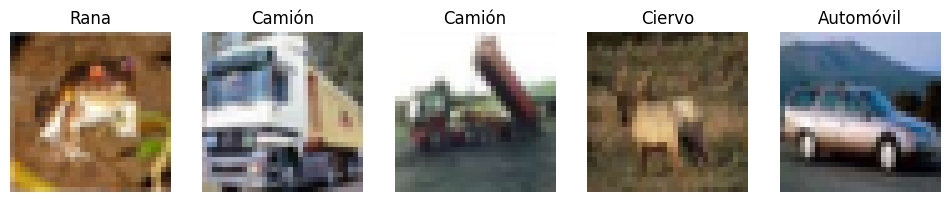

In [ ]:


# Cargar el conjunto de datos CIFAR-10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Definir las etiquetas de clase
class_names = ['Avión', 'Automóvil', 'Pájaro', 'Gato', 'Ciervo',
               'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

# Función para mostrar ejemplos de imágenes
def mostrar_ejemplos(images, labels, num_ejemplos=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_ejemplos):
        plt.subplot(1, num_ejemplos, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.show()

# Mostrar ejemplos del conjunto de entrenamiento
mostrar_ejemplos(train_images, train_labels, num_ejemplos=5)

In [ ]:
print(train_images.shape)

(50000, 32, 32, 3)


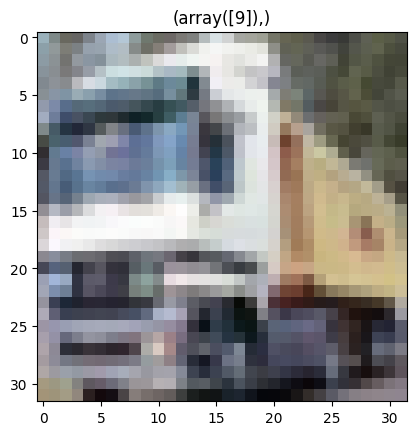

(50000, 32, 32, 3)


In [ ]:
test_labels= LabelBinarizer().fit_transform(test_labels)
train_labels=LabelBinarizer().fit_transform(train_labels)
plt.imshow(train_images[1], cmap = 'Greys')
plt.title(np.where(train_labels[1]==1))
plt.show()

print(train_images.shape)


Normalizamos las imágenes al rango [-1,1]

In [ ]:
train_images = train_images.astype('float32')/127.5 -1

train_images = np.expand_dims(train_images, axis=4)

In [ ]:
element_shape = train_images[0].shape
print("Forma del primer elemento de train_images:", element_shape)

Forma del primer elemento de train_images: (32, 32, 3, 1)


## Generador Prueba CIFAR

Hemos elegido utilizar kernel_initializer='glorot_normal' en nuestro modelo porque esta estrategia de inicialización de pesos, conocida como Xavier normal, ha demostrado ser efectiva al garantizar una convergencia más estable y un mejor rendimiento durante el entrenamiento de redes neuronales. Esta elección se basa en las buenas prácticas ampliamente reconocidas en el campo del aprendizaje profundo. Además hacemos uso de BatchNormalization.


In [ ]:
def create_generatorCF():


    input_z = Input(shape=(32,32,3,1))
    input_ruido = Input(shape=(32,32,3,1))
    concatenated = Concatenate(axis=3)([input_ruido, input_z])
    num_classes = 10

    input_label = Input(shape=(num_classes,))

    # Combine the noise vector and label as input
    flattened_z = Flatten()(concatenated)
    combined_input = Concatenate()([flattened_z, input_label])

    x = Dense(8 * 8 * 384, activation='relu')(combined_input)
    x = Reshape((8, 8, 384))(x)

    x = Conv2DTranspose(192, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='tanh')(x)
    x = Reshape((32, 32, 3))(x)


    input_layer_x = input_z
    input_layer_x=Reshape((32, 32, 3))(input_layer_x)
    input_layer_y = x

    # Dividir x en la mitad izquierda
    x_izquierda = input_layer_x[:, :16, :]

    # Dividir y en la mitad derecha
    y_derecha = input_layer_y[:, 16:, :]

    # Concatenar las mitades izquierda y derecha
    output = Concatenate(axis=1)([x_izquierda, y_derecha])

    # Dividir x en la mitad izquierda
    x_izquierda = output[:, :, :16]

    # Dividir y en la mitad derecha
    y_derecha = input_layer_y[:, :, 16:]

    # Concatenar las mitades izquierda y derecha
    output = Concatenate(axis=2)([x_izquierda, y_derecha])
    output = Reshape((32, 32, 3,1))(output)

    generator = Model(inputs=[input_z, input_label,input_ruido], outputs=output)

    return generator


Lo siguiente, podemos ver la descripción del generador.

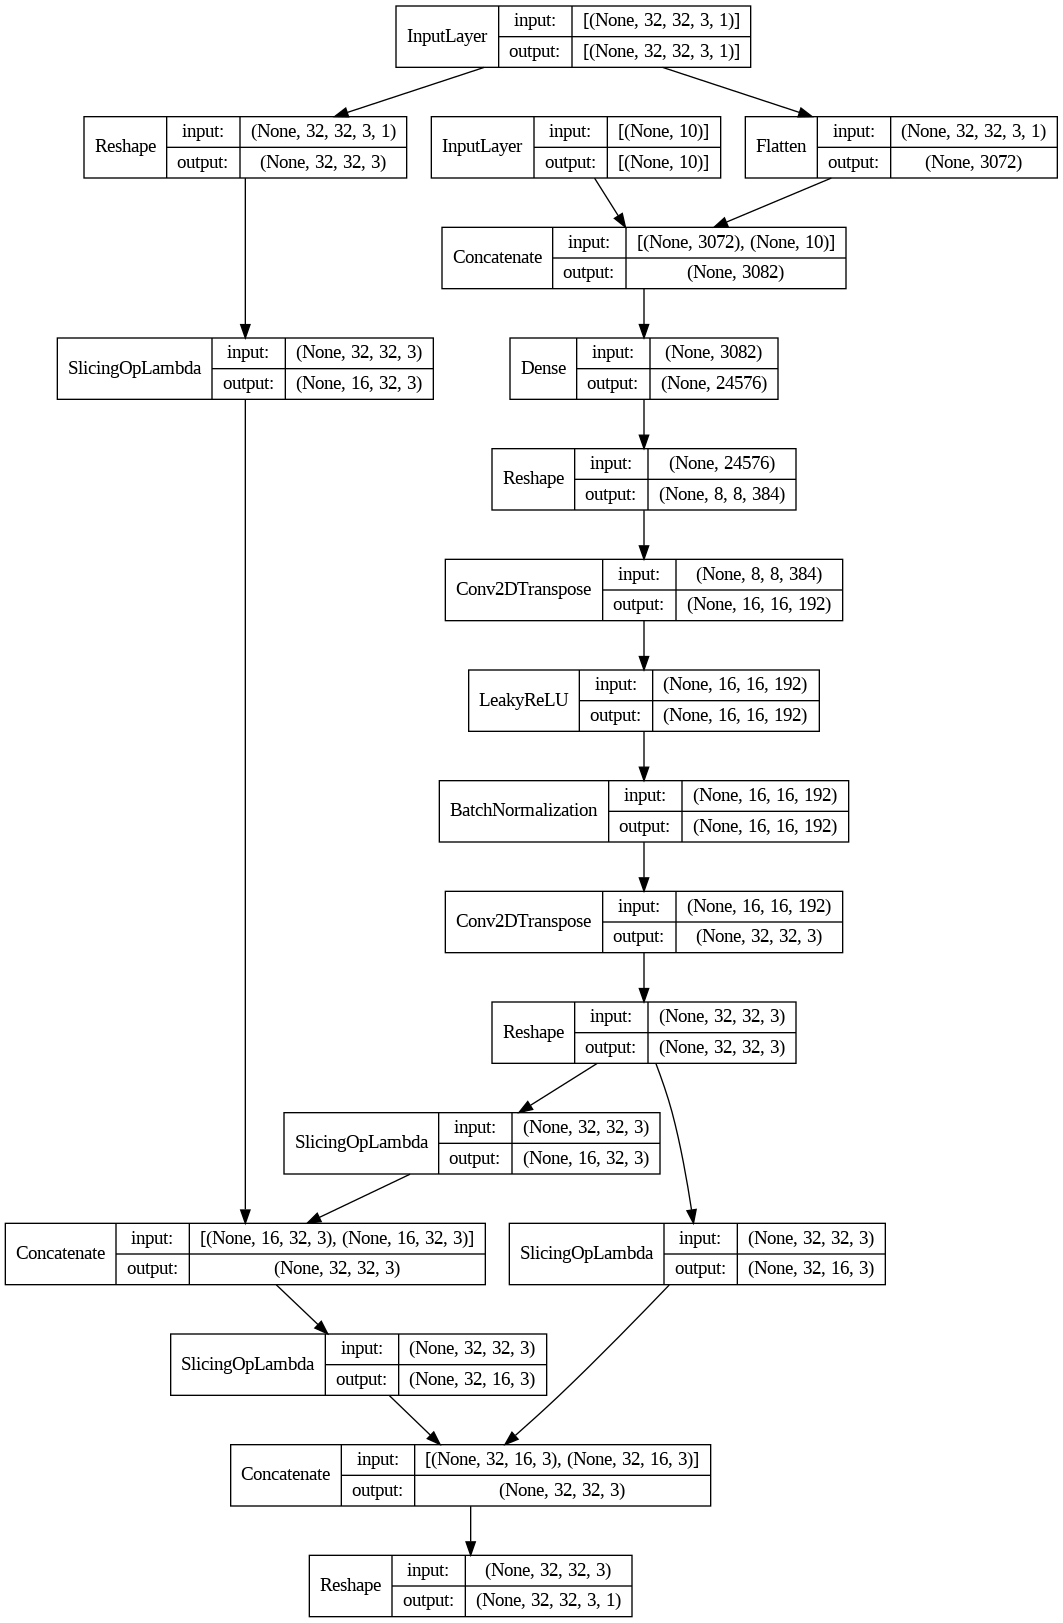

In [ ]:
generatorCF = create_generatorCF()
plot_model(generatorCF, show_shapes=True, show_layer_names=False)

## Discriminador Prueba CIFAR

Creamos un discriminador siguiendo la misma estructura del anterior aunque más simplificado.

In [ ]:
def create_discriminatorCF():
    input = Input(shape=(32, 32, 3, 1))
    num_classes = 10

    x = Conv3D(32, (3, 3, 3), strides=(2, 2, 2), padding='same')(input)  # Reducí el número de filtros
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)  # Reducí el número de filtros
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv3D(128, (3, 3, 3), strides=(2, 2, 2), padding='same')(x)  # Reducí el número de filtros
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)


    x = Flatten()(x)

    # Dropout for regularization
    x = Dropout(0.4)(x)

    # Additional hidden layer for better feature extraction
    x = Dense(256, activation='relu')(x)



    # Salida de clasificación de etiqueta (label output)
    validity = Dense(1, activation='sigmoid')(x)
    label = Dense(num_classes, activation='softmax')(x)
    # Cambiar el modelo para que ahora genere dos salidas

    discriminator = Model(input, [validity, label],name='discriminator')

    return discriminator

Podemos ver el modelado del dicriminador.

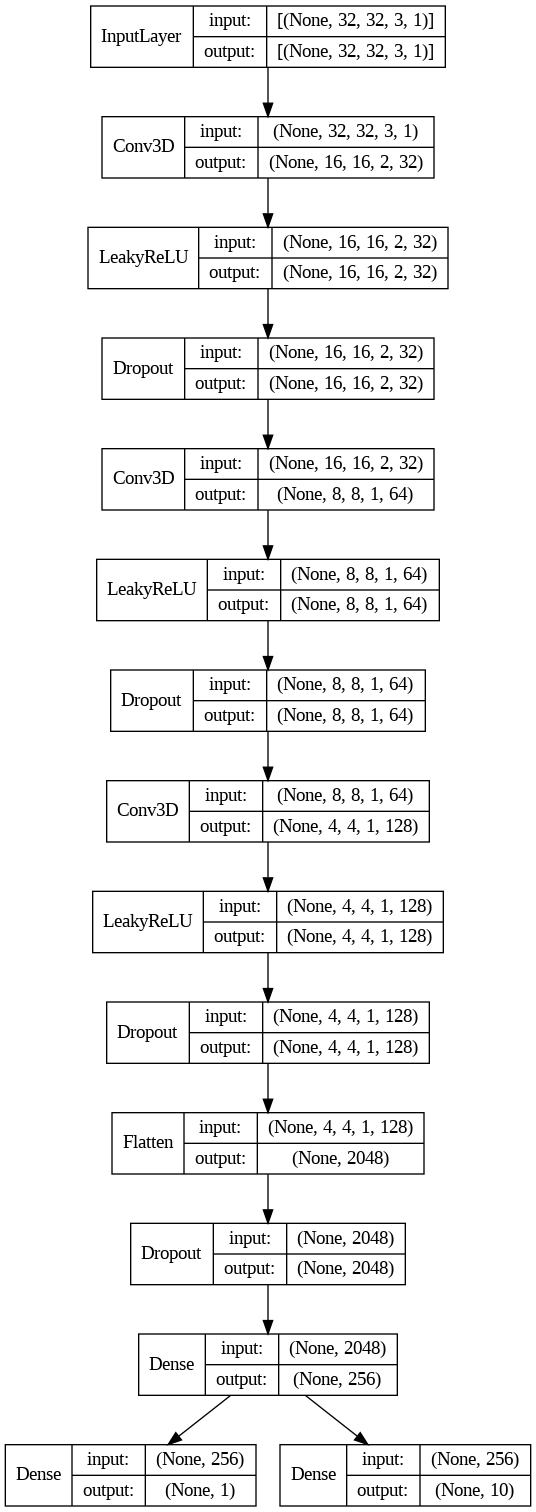

In [ ]:
discriminatorCF = create_discriminatorCF()
plot_model(discriminatorCF, show_shapes=True, show_layer_names=False)

## GAN model definition

En esta sección creamos una función de pérdida customizada para tratar con estos datos etiquetados, compilamos y mostramos el modelo.

In [ ]:
import tensorflow as tf
def custom_combined_loss(y_true, y_pred):
    # Split y_pred into validity predictions and label predictions
    validity_preds = y_pred[:, :1]  # Assuming validity predictions are the first column
    label_preds = y_pred[:, 1:]  # Assuming label predictions follow the validity predictions

    # Split y_true into validity labels and label labels
    validity_labels = y_true[:, :1]
    label_labels = y_true[:, 1:]

    # Calculate the binary cross-entropy loss for the validity component
    validity_loss = tf.keras.losses.binary_crossentropy(validity_labels, validity_preds)

    # Calculate the categorical cross-entropy loss for the label classification component
    label_loss = tf.keras.losses.categorical_crossentropy(label_labels, label_preds)



    # Total combined loss
    combined_loss = validity_loss + label_loss

    return combined_loss




In [ ]:
discriminatorCF.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
discriminatorCF.trainable = False

z = Input(shape=(32,32,3,1))
# Crear una nueva entrada label que tenga tantas dimensiones como clases
num_classes=10
label = Input(shape=(num_classes,))


# Introducir al generador las entradas z y label al mismo tiempo

img = generatorCF([z, label])
# Obtener del discriminador las salidas validity y target_label a la vez
validity, target_label = discriminatorCF(img)

# Modificar combined para que el modelo admita ambas entradas y salidas

combinedCF = Model(inputs=[z, label], outputs=[validity, target_label])
# Compilar el modelo para que ahora tenga 2 funciones de pérdida:
    # binary_crossentropy: para la salida de validez
    # categorical_crossentropy: para la salida de clasificación de etiqueta
combinedCF.compile(loss=custom_combined_loss, optimizer=Adam(learning_rate=0.0001))


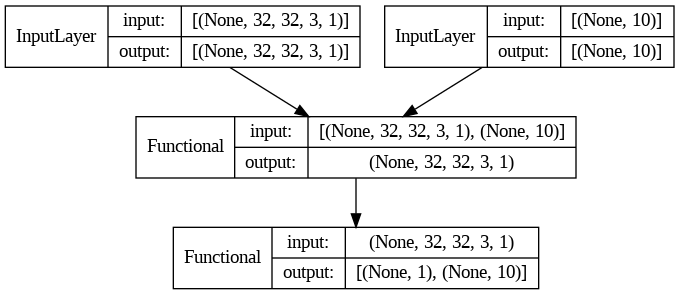

In [ ]:
plot_model(combinedCF, show_shapes=True, show_layer_names=False)

## Training

En esta sección se encuentra la función de train basada en la anterior, adaptada a los nuevos tipos de datos, además de las funciones de plot medificadas para mostrar las etquetas.

In [ ]:
def train(X_train, y_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator

            # Generar un batch de etiquetas de manera aleatoria
            # El generador ahora deberá admitir el noise la mismo tiempo que los gen_labels generados aleatoriamente

            img_labels = y_train[batch * batch_size: (batch + 1) * batch_size]

            cropImgs = X_train[batch * batch_size : (batch + 1) * batch_size]


            imagenes_vacias = np.empty((0, 32, 32, 3, 1), dtype=np.uint8)

            # Copia la esquina de la imagen original en la nueva imagen
            for i in range(batch_size):
              imagenA = np.copy(cropImgs[i])
              imagenA=imagenA.reshape(32,32,3)
              imagen_negra = np.zeros((32, 32, 3, 1), dtype=np.uint8)
              imagen_negra=imagen_negra.reshape(32,32,3)
              imagenA[16:, :16, :] = imagen_negra[16:, :16, :]
              imagenA[16:, 16:, :] = imagen_negra[16:, 16:, :]
              imagenA[:16, 16:, :] = imagen_negra[:16, 16:, :]


              imagenA=imagenA.reshape(32,32,3,1)
              imagenes_vacias = np.append(imagenes_vacias, imagenA[np.newaxis, :], axis=0)


            #image_set = image_set.reshape(batch_size, 32, 32, 3, 1)
            gen_imgs = generator.predict([imagenes_vacias, img_labels],verbose=0)
            imgs = X_train[batch*batch_size : (batch+1)*batch_size]
            # Obtener el batch correspondiente de etiquetas de y_train
            img_labels = y_train[batch * batch_size: (batch + 1) * batch_size]
            # Añadir a las salidas deseadas del discriminador las etiquetas aleatorias y las obtenidas de y_train
            d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, img_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the Generator
            # Añadir como entrada y salida las etiquetas generadas
            g_loss = combined.train_on_batch([imagenes_vacias, img_labels], [valid, img_labels])
            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[3])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[3], g_loss[0]))

            if batch % 500 == 0:

                gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], 32, 32, 3)
                imgs = imgs.reshape(imgs.shape[0], 32, 32, 3)

                imgs = (imgs.astype('float32')+1)*127.5 /255
                gen_imgs = (gen_imgs.astype('float32')+1)*127.5 /255

                sample_images(epoch, batch, gen_imgs, img_labels, imgs, img_labels)

        plot_losses(history)


### Plotting functions

In [ ]:
def sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0, i].imshow(gen_imgs[i])
        class_idx = np.where(gen_labels[i] == 1)[0][0]
        axs[0, i].set_title(class_names[class_idx])
        axs[0, i].axis('off')

    for i in range(5):
        axs[1, i].imshow(imgs[i])
        class_idx = np.where(img_labels[i] == 1)[0][0]
        axs[1, i].set_title(class_names[class_idx])
        axs[1, i].axis('off')
    plt.show()
    plt.close()


In [ ]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()


### Train

Entrenando este modelo, vemos mucho mejores resultados. Podemos observar que, debido a la poca calidad de las imágenes, y a las limitaciones que tuvimos de recursos para ejecutarlo, la imagen generada no es del todo distinguible. Sin embargo, incluso en estas condiciones, podemos observar como el contexto de las imágenes comienza a se más coherente, siendo menos apreciable a primera vista la sección introducida.


----EPOCH 0-----
0 [D loss: 1.3773,	 acc.: 59.38%]	[G loss: 2.9916]


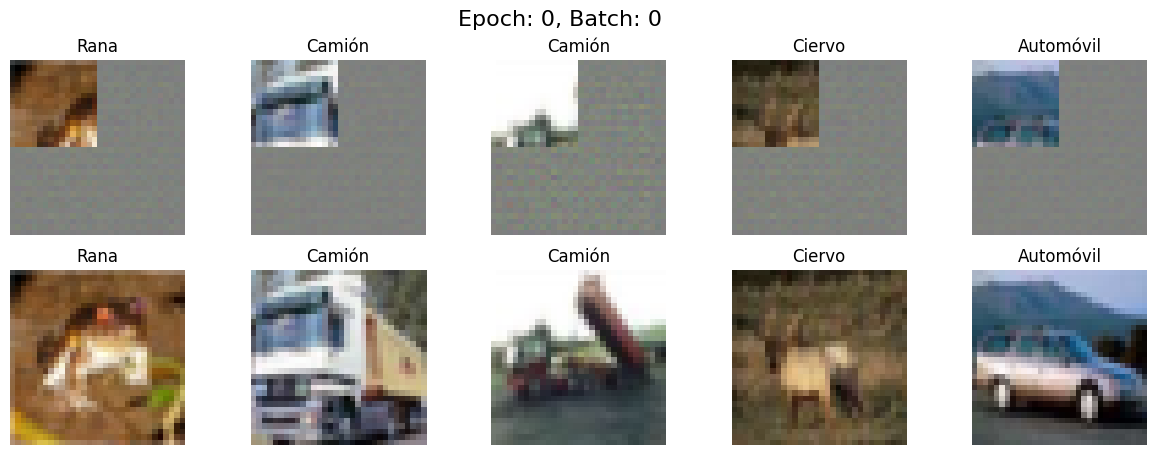

50 [D loss: 0.4303,	 acc.: 100.00%]	[G loss: 2.3432]
100 [D loss: 0.5663,	 acc.: 92.19%]	[G loss: 5.0935]
150 [D loss: 0.4142,	 acc.: 96.88%]	[G loss: 4.6952]
200 [D loss: 0.4540,	 acc.: 96.88%]	[G loss: 4.6534]
250 [D loss: 0.8504,	 acc.: 70.31%]	[G loss: 3.3038]
300 [D loss: 0.6888,	 acc.: 84.38%]	[G loss: 4.7445]
350 [D loss: 0.4890,	 acc.: 96.88%]	[G loss: 5.0133]
400 [D loss: 0.5878,	 acc.: 87.50%]	[G loss: 3.0059]
450 [D loss: 0.6093,	 acc.: 85.94%]	[G loss: 3.9680]
500 [D loss: 0.4185,	 acc.: 98.44%]	[G loss: 2.7446]


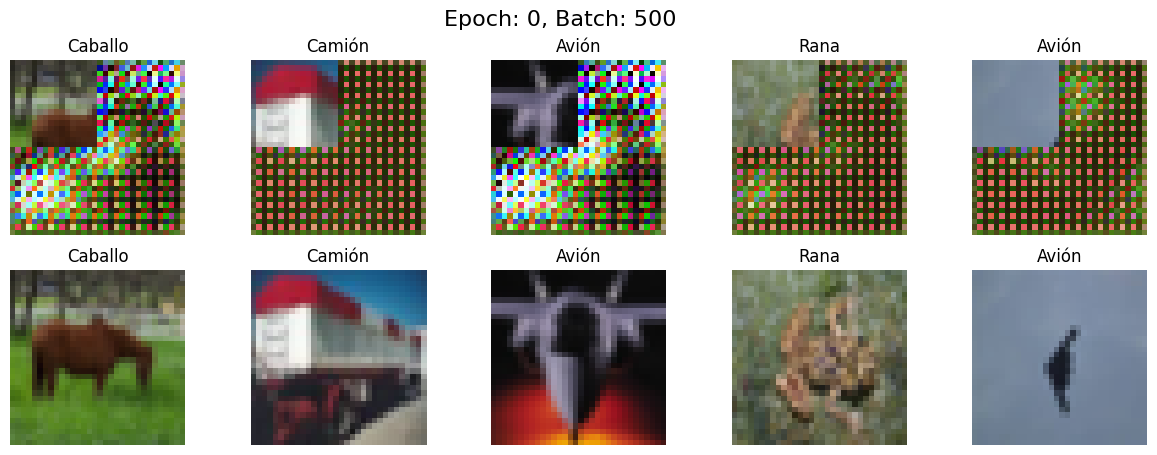

550 [D loss: 0.3671,	 acc.: 100.00%]	[G loss: 2.4620]
600 [D loss: 0.4005,	 acc.: 96.88%]	[G loss: 2.3263]
650 [D loss: 0.3779,	 acc.: 98.44%]	[G loss: 2.5127]
700 [D loss: 0.9130,	 acc.: 78.12%]	[G loss: 2.7402]
750 [D loss: 0.7259,	 acc.: 81.25%]	[G loss: 3.1932]
800 [D loss: 1.0975,	 acc.: 65.62%]	[G loss: 2.7840]
850 [D loss: 0.7710,	 acc.: 82.81%]	[G loss: 2.6251]
900 [D loss: 0.6918,	 acc.: 81.25%]	[G loss: 2.4318]
950 [D loss: 0.7764,	 acc.: 78.12%]	[G loss: 3.2543]
1000 [D loss: 0.7507,	 acc.: 82.81%]	[G loss: 3.6434]


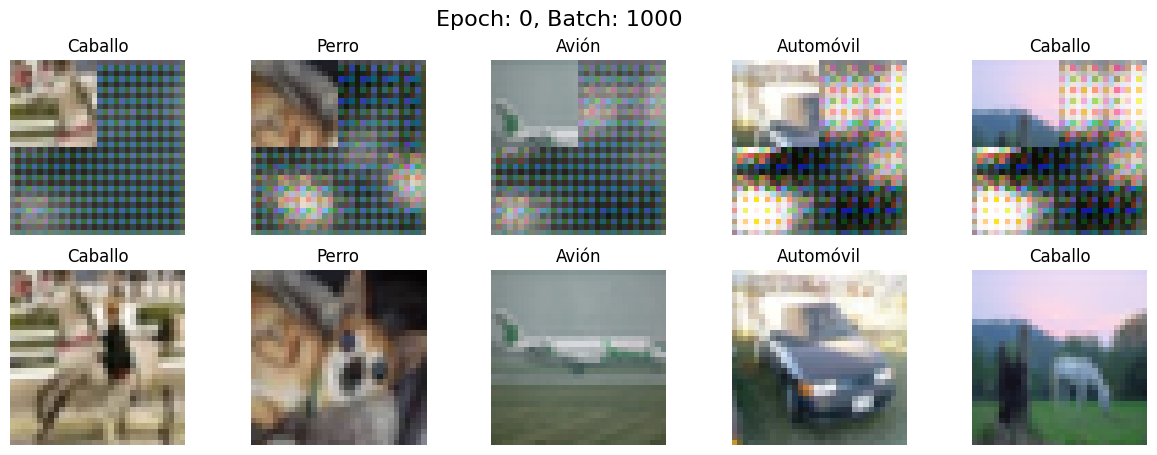

1050 [D loss: 0.9326,	 acc.: 70.31%]	[G loss: 3.6920]
1100 [D loss: 0.8216,	 acc.: 85.94%]	[G loss: 2.4921]
1150 [D loss: 0.6584,	 acc.: 87.50%]	[G loss: 2.2048]
1200 [D loss: 0.5493,	 acc.: 95.31%]	[G loss: 2.5148]
1250 [D loss: 0.6515,	 acc.: 84.38%]	[G loss: 2.4061]
1300 [D loss: 0.8539,	 acc.: 78.12%]	[G loss: 3.1123]
1350 [D loss: 0.8171,	 acc.: 71.88%]	[G loss: 2.6713]
1400 [D loss: 0.6970,	 acc.: 87.50%]	[G loss: 2.2903]
1450 [D loss: 0.5384,	 acc.: 90.62%]	[G loss: 2.5065]
1500 [D loss: 0.9697,	 acc.: 71.88%]	[G loss: 3.3997]


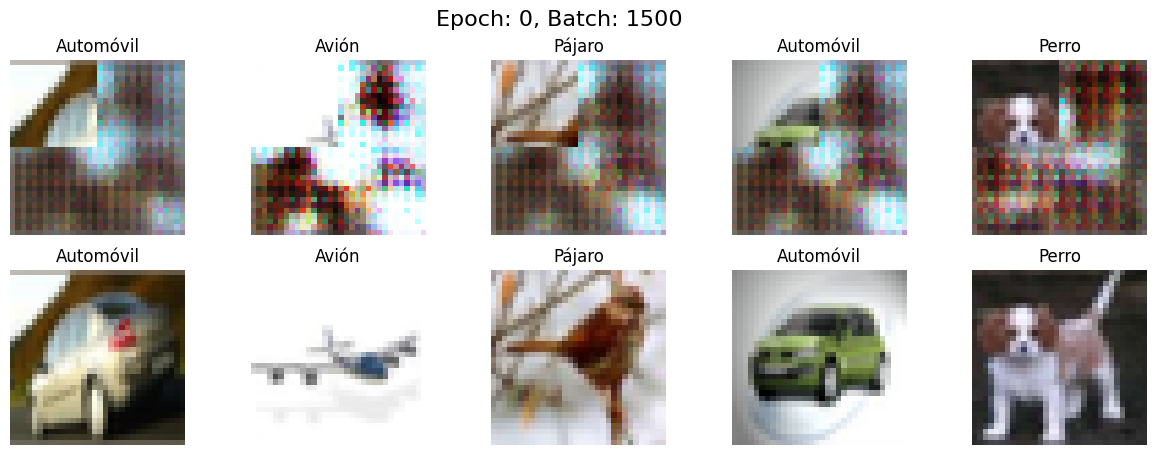

1550 [D loss: 0.8947,	 acc.: 67.19%]	[G loss: 3.1869]


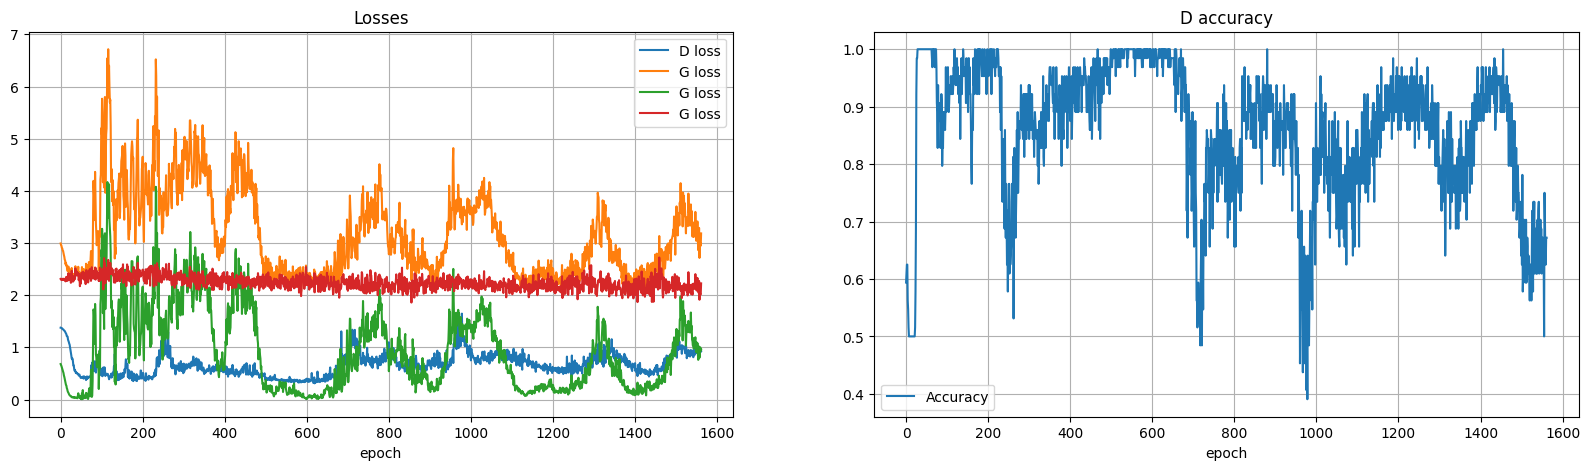

----EPOCH 1-----
0 [D loss: 0.9906,	 acc.: 57.81%]	[G loss: 2.9408]


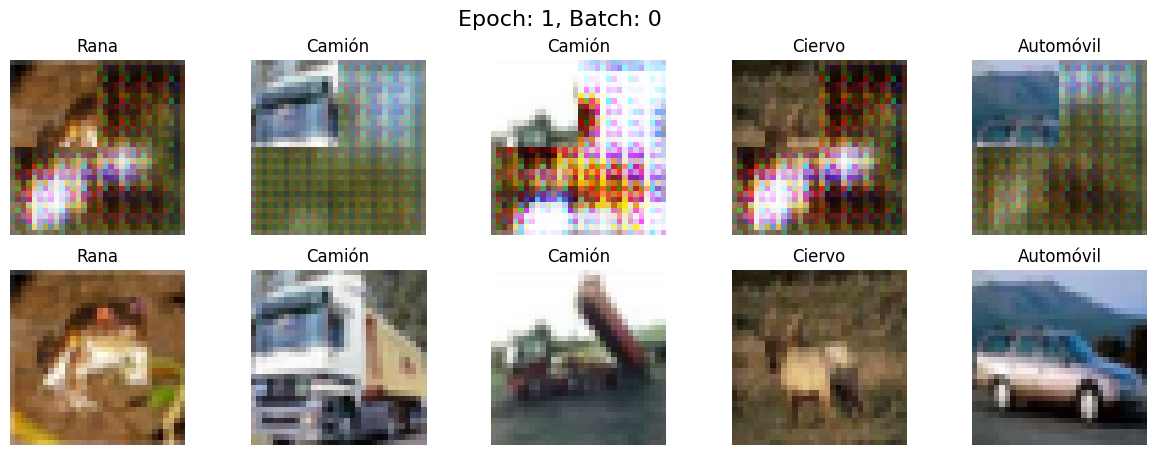

50 [D loss: 0.8256,	 acc.: 75.00%]	[G loss: 2.6867]
100 [D loss: 0.7597,	 acc.: 84.38%]	[G loss: 2.3932]
150 [D loss: 0.7739,	 acc.: 76.56%]	[G loss: 2.5028]
200 [D loss: 0.7491,	 acc.: 82.81%]	[G loss: 2.5884]
250 [D loss: 0.8669,	 acc.: 71.88%]	[G loss: 2.2470]
300 [D loss: 0.9186,	 acc.: 64.06%]	[G loss: 3.1968]
350 [D loss: 0.7359,	 acc.: 81.25%]	[G loss: 2.2479]
400 [D loss: 0.8857,	 acc.: 71.88%]	[G loss: 2.7111]
450 [D loss: 0.8493,	 acc.: 73.44%]	[G loss: 2.7938]
500 [D loss: 0.5620,	 acc.: 98.44%]	[G loss: 2.9959]


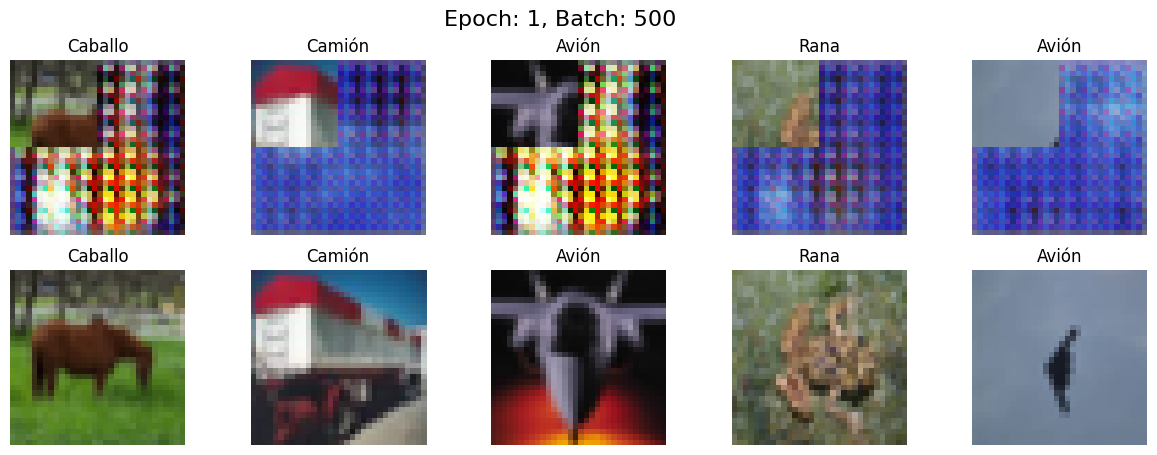

550 [D loss: 0.5625,	 acc.: 95.31%]	[G loss: 2.6215]
600 [D loss: 0.4846,	 acc.: 93.75%]	[G loss: 2.3047]
650 [D loss: 0.8697,	 acc.: 85.94%]	[G loss: 2.3604]
700 [D loss: 0.6684,	 acc.: 85.94%]	[G loss: 2.2661]
750 [D loss: 0.7139,	 acc.: 87.50%]	[G loss: 2.6764]
800 [D loss: 0.7814,	 acc.: 82.81%]	[G loss: 2.5746]
850 [D loss: 0.7003,	 acc.: 78.12%]	[G loss: 2.7629]
900 [D loss: 0.9026,	 acc.: 68.75%]	[G loss: 2.6666]
950 [D loss: 0.5438,	 acc.: 92.19%]	[G loss: 2.2946]
1000 [D loss: 0.6685,	 acc.: 87.50%]	[G loss: 2.1873]


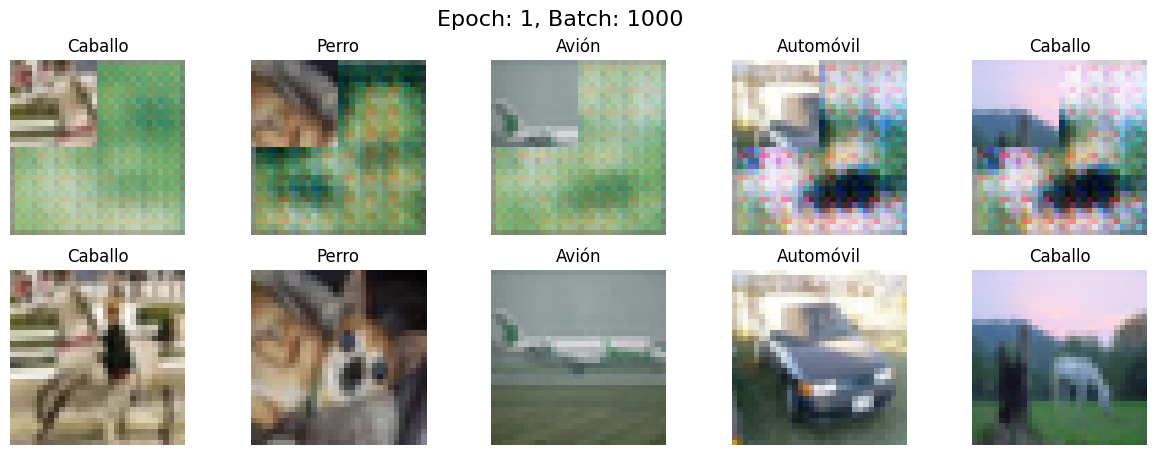

1050 [D loss: 0.7684,	 acc.: 79.69%]	[G loss: 2.6291]
1100 [D loss: 0.7735,	 acc.: 79.69%]	[G loss: 2.4681]
1150 [D loss: 0.9247,	 acc.: 65.62%]	[G loss: 3.0963]
1200 [D loss: 0.8411,	 acc.: 75.00%]	[G loss: 2.5663]
1250 [D loss: 0.8988,	 acc.: 62.50%]	[G loss: 2.2631]
1300 [D loss: 0.8488,	 acc.: 68.75%]	[G loss: 2.5640]
1350 [D loss: 0.9072,	 acc.: 65.62%]	[G loss: 2.3026]
1400 [D loss: 0.8036,	 acc.: 81.25%]	[G loss: 2.6844]
1450 [D loss: 0.7058,	 acc.: 87.50%]	[G loss: 2.4920]
1500 [D loss: 0.8667,	 acc.: 73.44%]	[G loss: 3.3072]


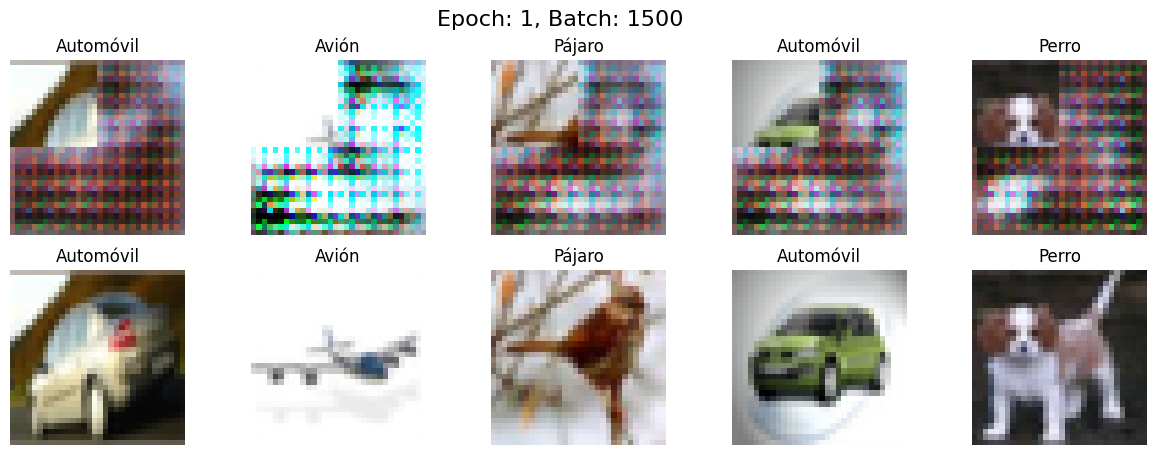

1550 [D loss: 0.3650,	 acc.: 100.00%]	[G loss: 3.3692]


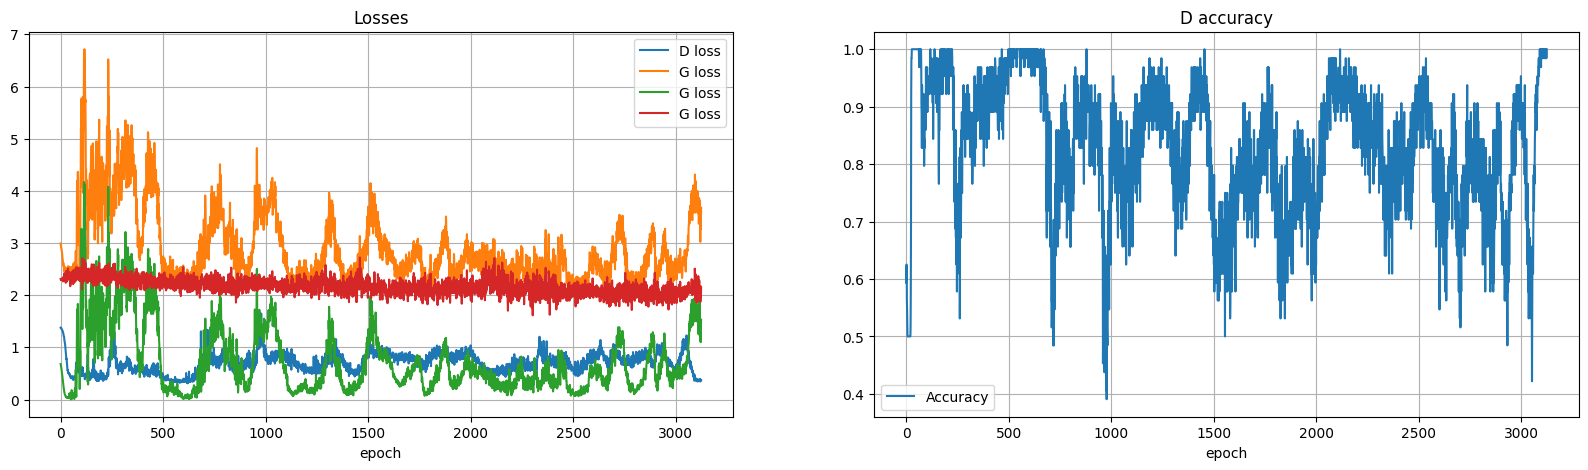

----EPOCH 2-----
0 [D loss: 0.4073,	 acc.: 98.44%]	[G loss: 3.3368]


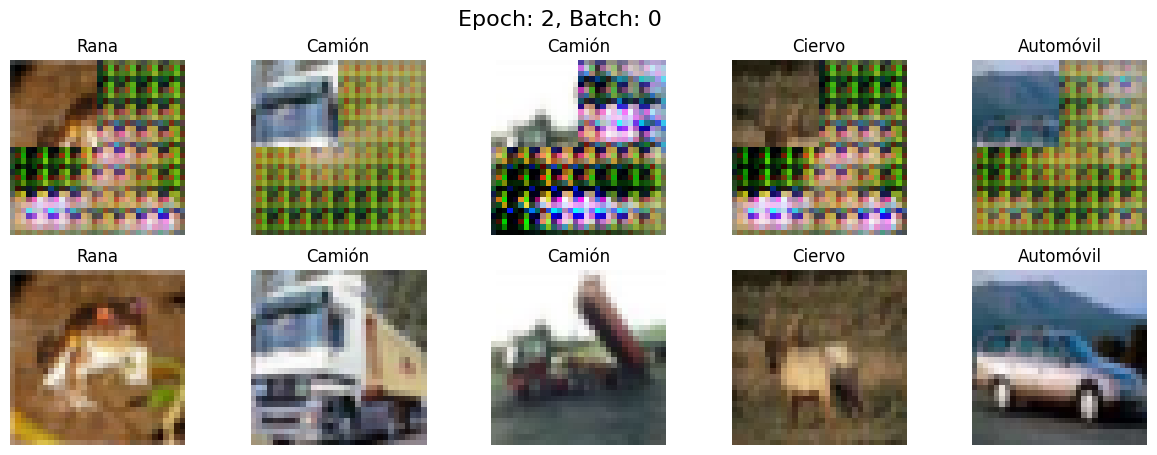

50 [D loss: 0.6795,	 acc.: 84.38%]	[G loss: 2.6540]
100 [D loss: 0.5393,	 acc.: 90.62%]	[G loss: 2.5646]
150 [D loss: 0.5377,	 acc.: 93.75%]	[G loss: 1.9951]
200 [D loss: 0.4777,	 acc.: 95.31%]	[G loss: 1.9575]
250 [D loss: 0.5142,	 acc.: 96.88%]	[G loss: 1.9690]
300 [D loss: 1.0123,	 acc.: 59.38%]	[G loss: 2.9604]
350 [D loss: 0.9043,	 acc.: 62.50%]	[G loss: 2.5357]
400 [D loss: 0.8410,	 acc.: 68.75%]	[G loss: 2.8470]
450 [D loss: 0.4329,	 acc.: 100.00%]	[G loss: 2.9710]
500 [D loss: 0.3389,	 acc.: 100.00%]	[G loss: 2.2296]


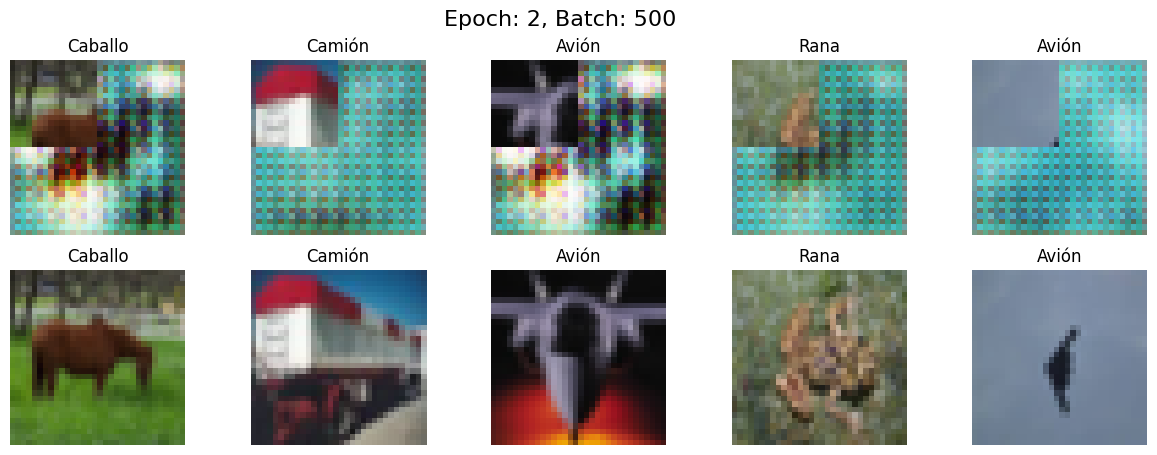

550 [D loss: 0.3728,	 acc.: 98.44%]	[G loss: 1.7139]
600 [D loss: 0.4139,	 acc.: 92.19%]	[G loss: 1.7916]
650 [D loss: 0.4195,	 acc.: 95.31%]	[G loss: 1.6145]
700 [D loss: 0.3340,	 acc.: 96.88%]	[G loss: 1.2897]
750 [D loss: 0.4236,	 acc.: 93.75%]	[G loss: 0.8604]
800 [D loss: 0.4640,	 acc.: 92.19%]	[G loss: 0.6350]
850 [D loss: 0.3619,	 acc.: 95.31%]	[G loss: 0.5587]
900 [D loss: 0.6276,	 acc.: 81.25%]	[G loss: 0.6998]
950 [D loss: 0.4287,	 acc.: 92.19%]	[G loss: 0.4550]
1000 [D loss: 0.4204,	 acc.: 92.19%]	[G loss: 0.3443]


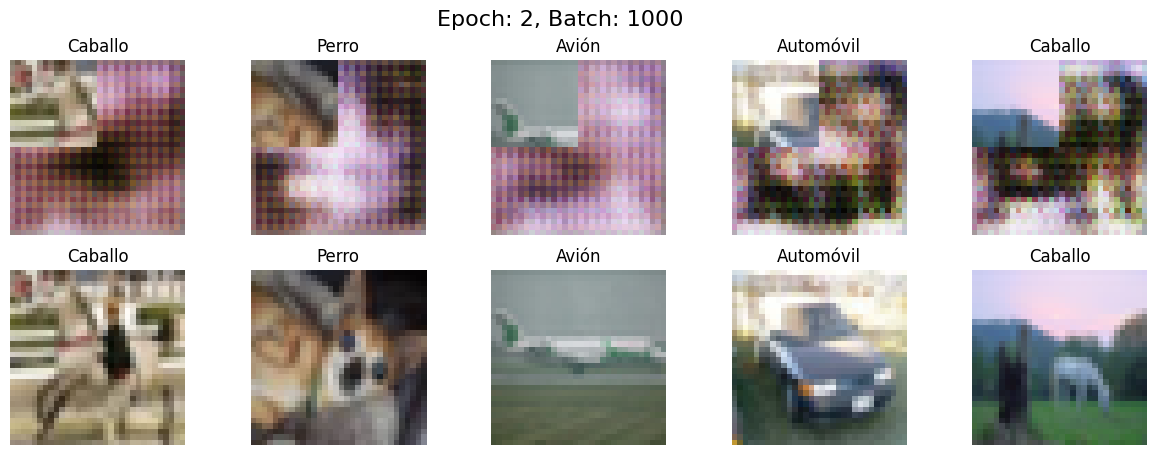

1050 [D loss: 0.4279,	 acc.: 90.62%]	[G loss: 0.2540]
1100 [D loss: 0.3393,	 acc.: 95.31%]	[G loss: 0.1523]
1150 [D loss: 0.2520,	 acc.: 96.88%]	[G loss: 0.1784]
1200 [D loss: 0.3300,	 acc.: 95.31%]	[G loss: 0.1264]
1250 [D loss: 0.3577,	 acc.: 92.19%]	[G loss: 0.2533]
1300 [D loss: 0.2823,	 acc.: 96.88%]	[G loss: 0.1911]
1350 [D loss: 0.2190,	 acc.: 98.44%]	[G loss: 0.1034]
1400 [D loss: 0.3538,	 acc.: 92.19%]	[G loss: 0.1605]
1450 [D loss: 0.2708,	 acc.: 95.31%]	[G loss: 0.1673]
1500 [D loss: 0.2464,	 acc.: 96.88%]	[G loss: 0.1151]


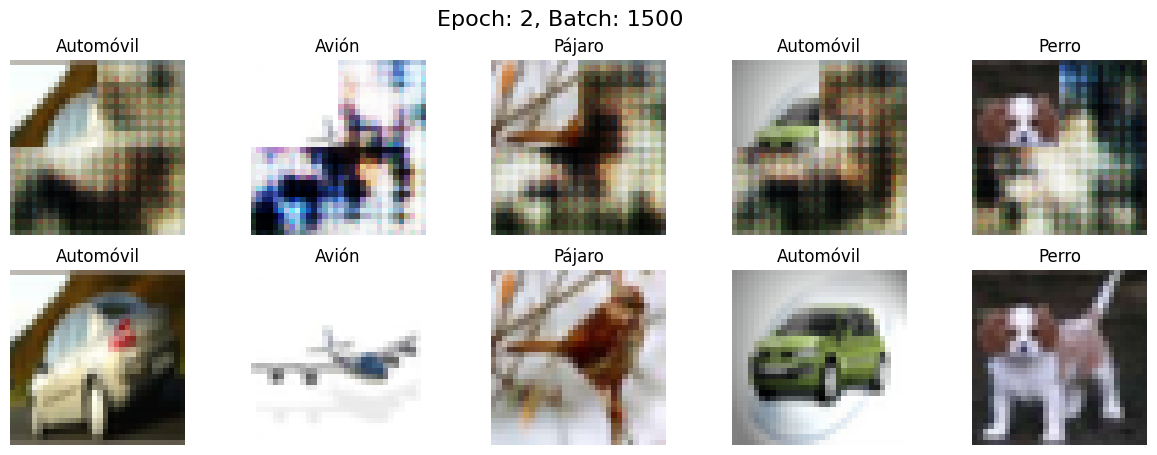

1550 [D loss: 0.2916,	 acc.: 95.31%]	[G loss: 0.0759]


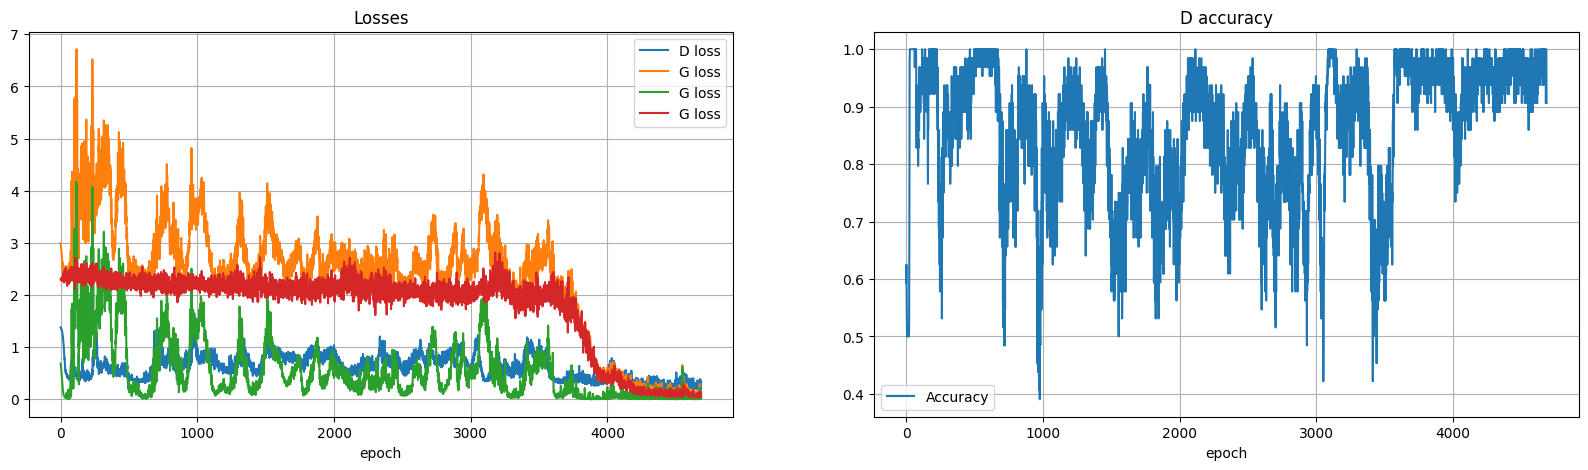

----EPOCH 3-----
0 [D loss: 0.4344,	 acc.: 92.19%]	[G loss: 0.1362]


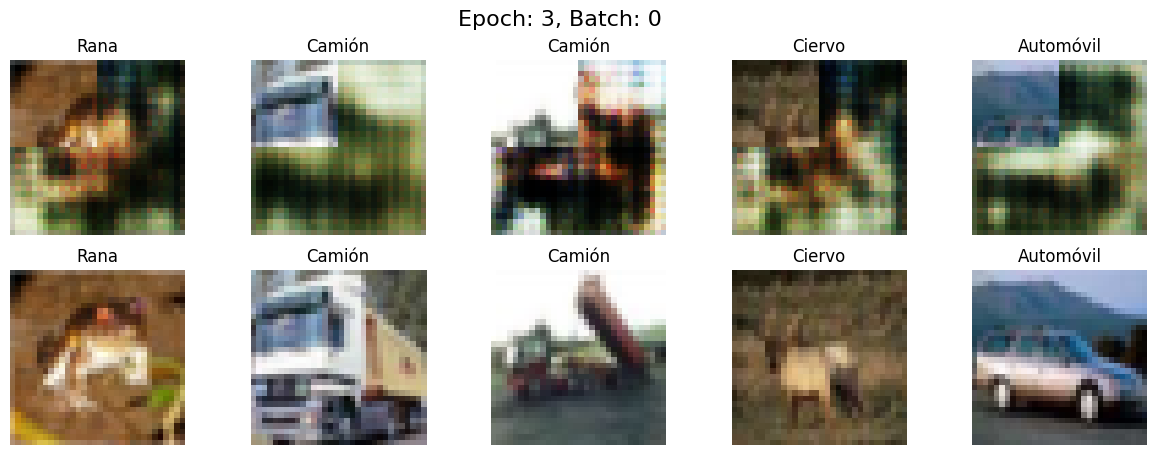

50 [D loss: 0.3796,	 acc.: 90.62%]	[G loss: 0.1721]
100 [D loss: 0.3182,	 acc.: 95.31%]	[G loss: 0.0912]
150 [D loss: 0.2109,	 acc.: 100.00%]	[G loss: 0.1780]
200 [D loss: 0.2421,	 acc.: 96.88%]	[G loss: 0.0867]
250 [D loss: 0.2533,	 acc.: 95.31%]	[G loss: 0.1112]
300 [D loss: 0.3352,	 acc.: 92.19%]	[G loss: 0.1399]
350 [D loss: 0.3550,	 acc.: 92.19%]	[G loss: 0.1535]
400 [D loss: 0.2921,	 acc.: 96.88%]	[G loss: 0.2644]
450 [D loss: 0.2635,	 acc.: 98.44%]	[G loss: 0.0454]
500 [D loss: 0.2571,	 acc.: 96.88%]	[G loss: 0.1084]


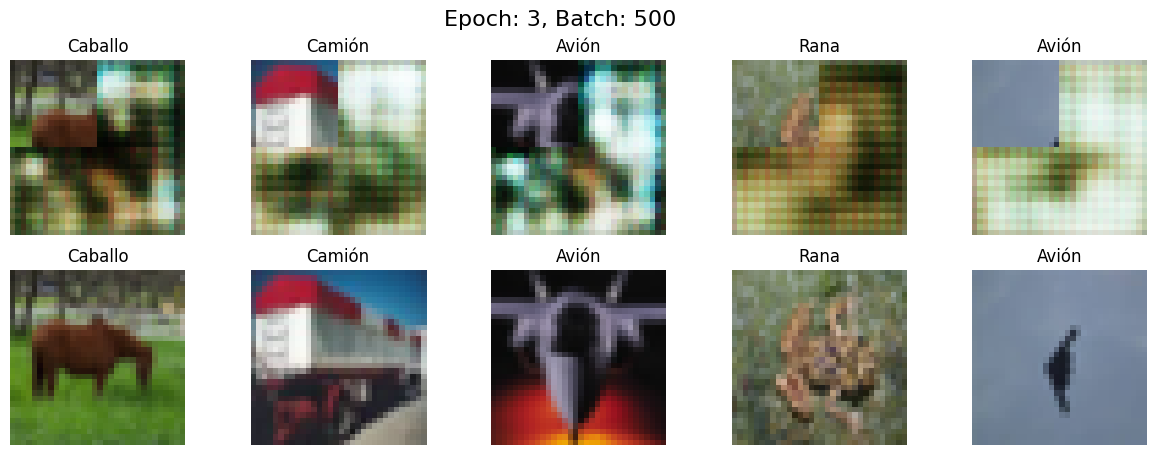

550 [D loss: 0.2405,	 acc.: 96.88%]	[G loss: 0.1187]
600 [D loss: 0.2052,	 acc.: 100.00%]	[G loss: 0.1537]
650 [D loss: 0.2248,	 acc.: 98.44%]	[G loss: 0.0577]
700 [D loss: 0.3578,	 acc.: 96.88%]	[G loss: 0.0496]
750 [D loss: 0.2261,	 acc.: 98.44%]	[G loss: 0.0336]
800 [D loss: 0.3263,	 acc.: 92.19%]	[G loss: 0.1066]
850 [D loss: 0.2580,	 acc.: 96.88%]	[G loss: 0.2150]
900 [D loss: 0.2634,	 acc.: 96.88%]	[G loss: 0.3496]
950 [D loss: 0.1976,	 acc.: 100.00%]	[G loss: 0.1247]
1000 [D loss: 0.1845,	 acc.: 100.00%]	[G loss: 0.1367]


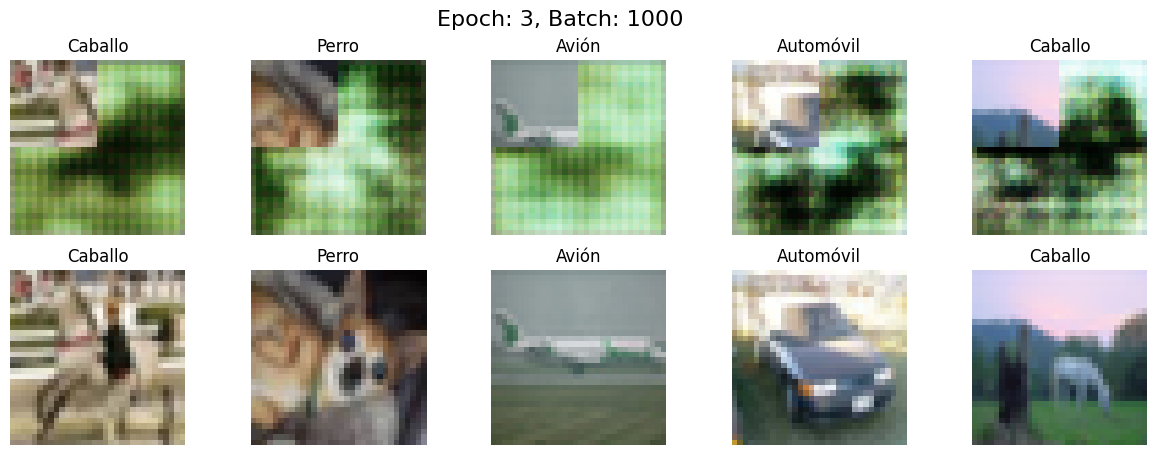

1050 [D loss: 0.3046,	 acc.: 92.19%]	[G loss: 0.0464]
1100 [D loss: 0.2693,	 acc.: 95.31%]	[G loss: 0.0768]
1150 [D loss: 0.2734,	 acc.: 95.31%]	[G loss: 0.0915]
1200 [D loss: 0.2318,	 acc.: 98.44%]	[G loss: 0.2120]
1250 [D loss: 0.1825,	 acc.: 98.44%]	[G loss: 0.0510]
1300 [D loss: 0.1556,	 acc.: 100.00%]	[G loss: 0.0800]
1350 [D loss: 0.1694,	 acc.: 100.00%]	[G loss: 0.0356]
1400 [D loss: 0.2023,	 acc.: 98.44%]	[G loss: 0.0928]
1450 [D loss: 0.1585,	 acc.: 100.00%]	[G loss: 0.0693]
1500 [D loss: 0.2296,	 acc.: 95.31%]	[G loss: 0.1317]


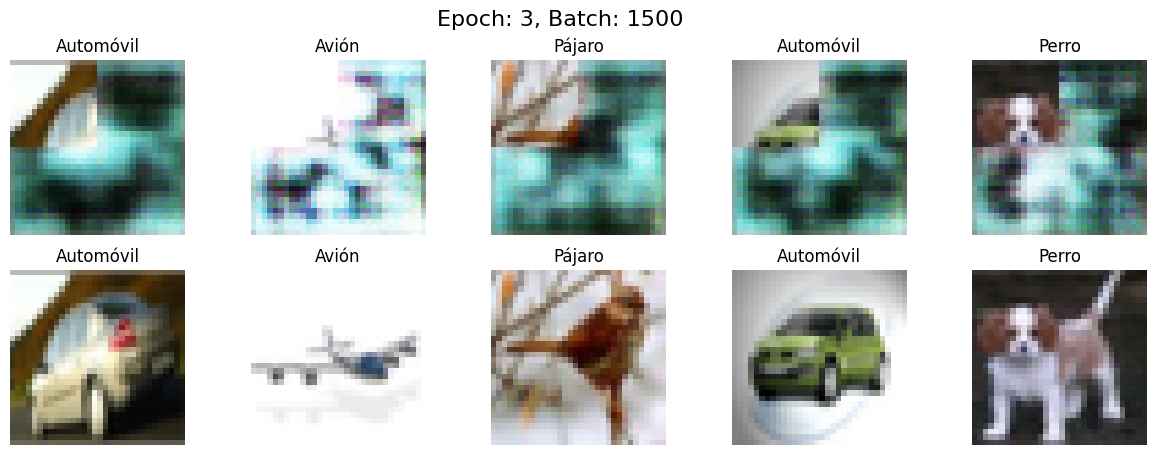

1550 [D loss: 0.2147,	 acc.: 98.44%]	[G loss: 0.1314]


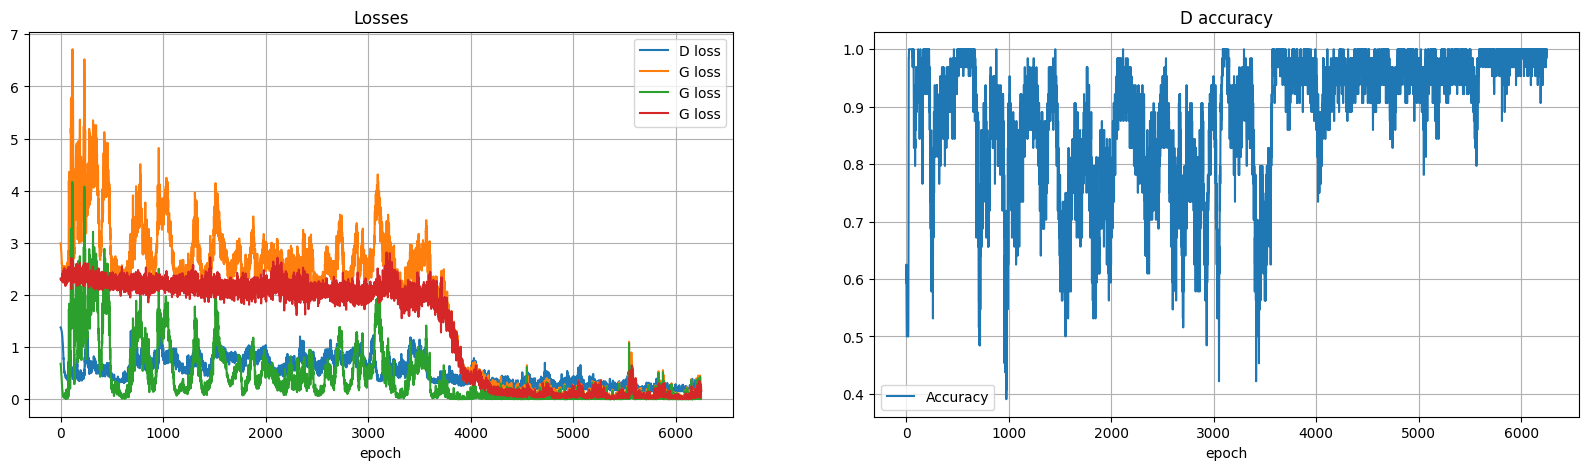

----EPOCH 4-----
0 [D loss: 0.1781,	 acc.: 100.00%]	[G loss: 0.1543]


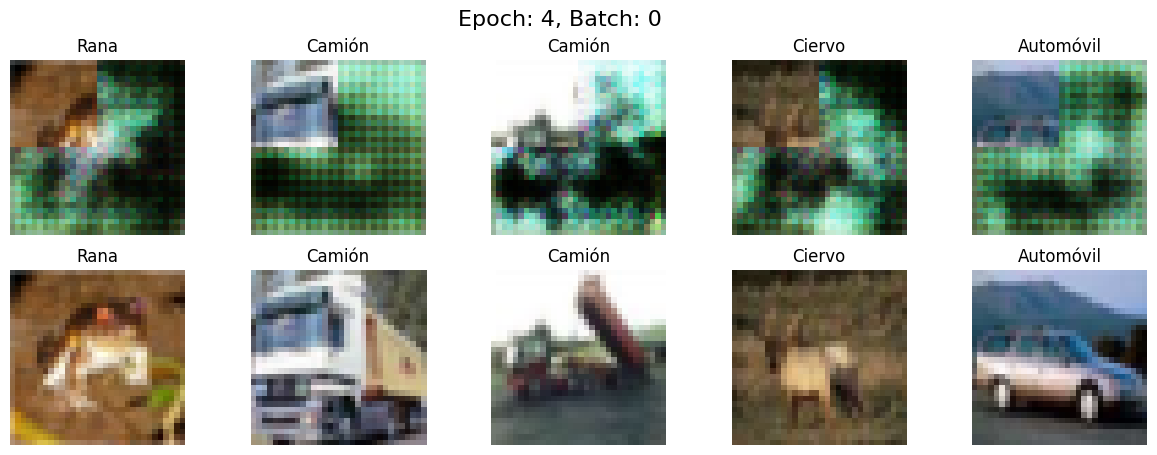

50 [D loss: 0.1758,	 acc.: 98.44%]	[G loss: 0.1681]
100 [D loss: 0.1670,	 acc.: 100.00%]	[G loss: 0.0347]
150 [D loss: 0.2668,	 acc.: 96.88%]	[G loss: 0.0483]
200 [D loss: 0.1468,	 acc.: 100.00%]	[G loss: 0.1062]
250 [D loss: 0.1762,	 acc.: 100.00%]	[G loss: 0.1085]
300 [D loss: 0.3279,	 acc.: 92.19%]	[G loss: 0.0680]
350 [D loss: 0.1498,	 acc.: 100.00%]	[G loss: 0.0311]
400 [D loss: 0.2200,	 acc.: 96.88%]	[G loss: 0.1172]
450 [D loss: 0.2588,	 acc.: 95.31%]	[G loss: 0.4910]
500 [D loss: 0.1575,	 acc.: 100.00%]	[G loss: 0.1535]


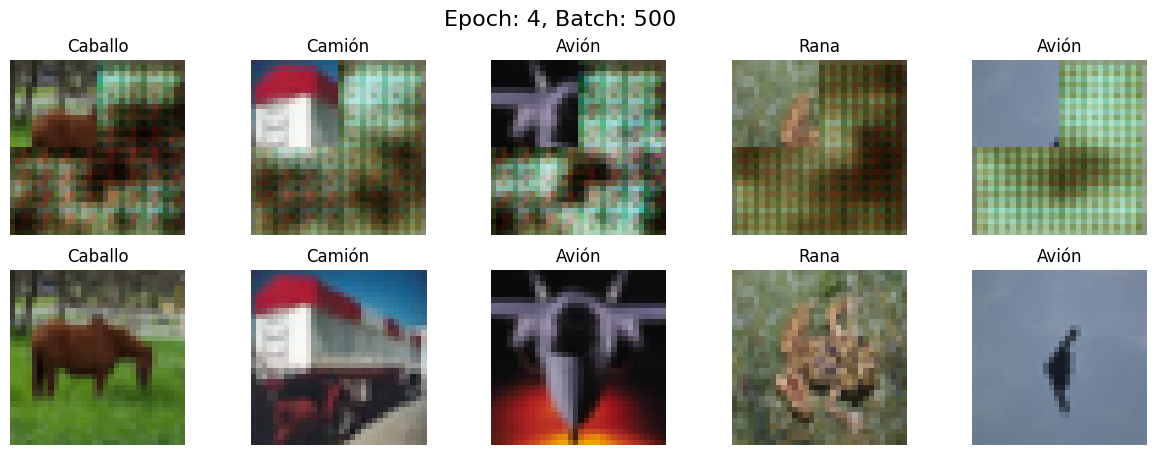

550 [D loss: 0.1738,	 acc.: 98.44%]	[G loss: 0.1546]
600 [D loss: 0.1749,	 acc.: 100.00%]	[G loss: 0.4384]
650 [D loss: 0.2979,	 acc.: 96.88%]	[G loss: 1.0404]
700 [D loss: 0.2955,	 acc.: 95.31%]	[G loss: 0.3481]
750 [D loss: 0.1705,	 acc.: 98.44%]	[G loss: 0.0361]
800 [D loss: 0.2315,	 acc.: 98.44%]	[G loss: 0.1577]
850 [D loss: 0.2419,	 acc.: 96.88%]	[G loss: 0.0895]
900 [D loss: 0.3697,	 acc.: 85.94%]	[G loss: 0.3447]
950 [D loss: 0.1914,	 acc.: 98.44%]	[G loss: 0.3156]
1000 [D loss: 0.1779,	 acc.: 98.44%]	[G loss: 0.1014]


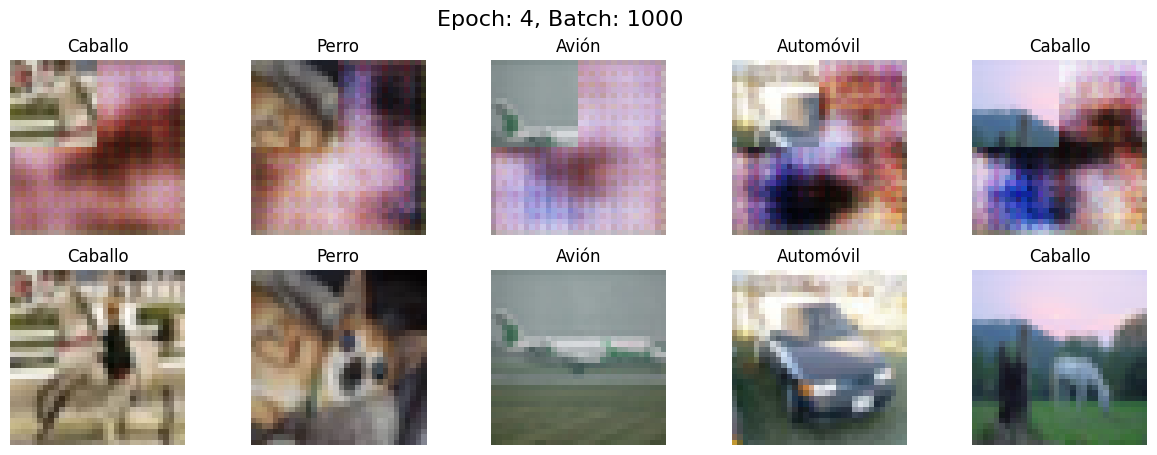

1050 [D loss: 0.2123,	 acc.: 96.88%]	[G loss: 0.2148]
1100 [D loss: 0.2334,	 acc.: 95.31%]	[G loss: 0.2285]
1150 [D loss: 0.2919,	 acc.: 96.88%]	[G loss: 0.1131]
1200 [D loss: 0.2440,	 acc.: 95.31%]	[G loss: 0.0441]
1250 [D loss: 0.2005,	 acc.: 98.44%]	[G loss: 0.0510]
1300 [D loss: 0.1562,	 acc.: 98.44%]	[G loss: 0.1103]
1350 [D loss: 0.1538,	 acc.: 100.00%]	[G loss: 0.0685]
1400 [D loss: 0.2396,	 acc.: 96.88%]	[G loss: 0.1112]
1450 [D loss: 0.1554,	 acc.: 100.00%]	[G loss: 0.1261]
1500 [D loss: 0.1991,	 acc.: 96.88%]	[G loss: 0.1574]


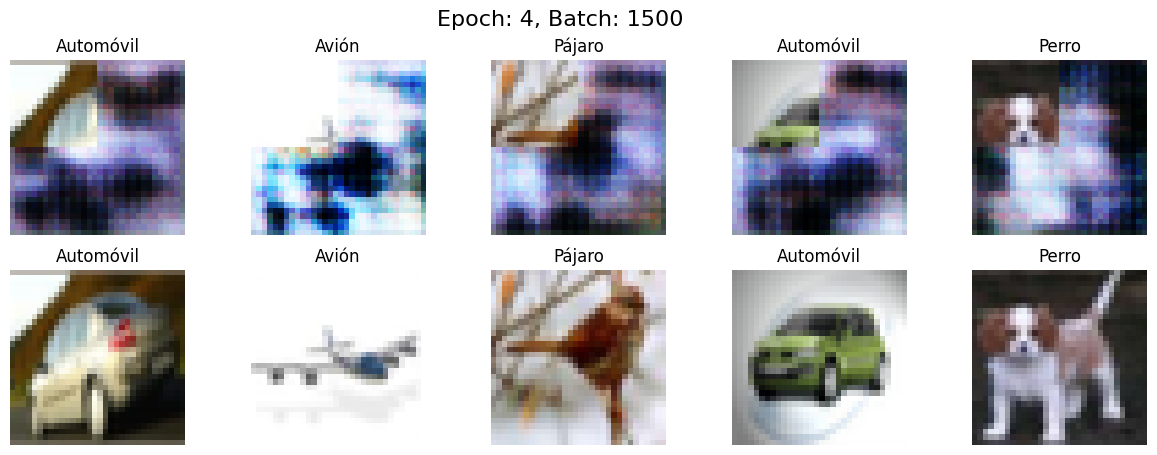

1550 [D loss: 0.1778,	 acc.: 98.44%]	[G loss: 0.2737]


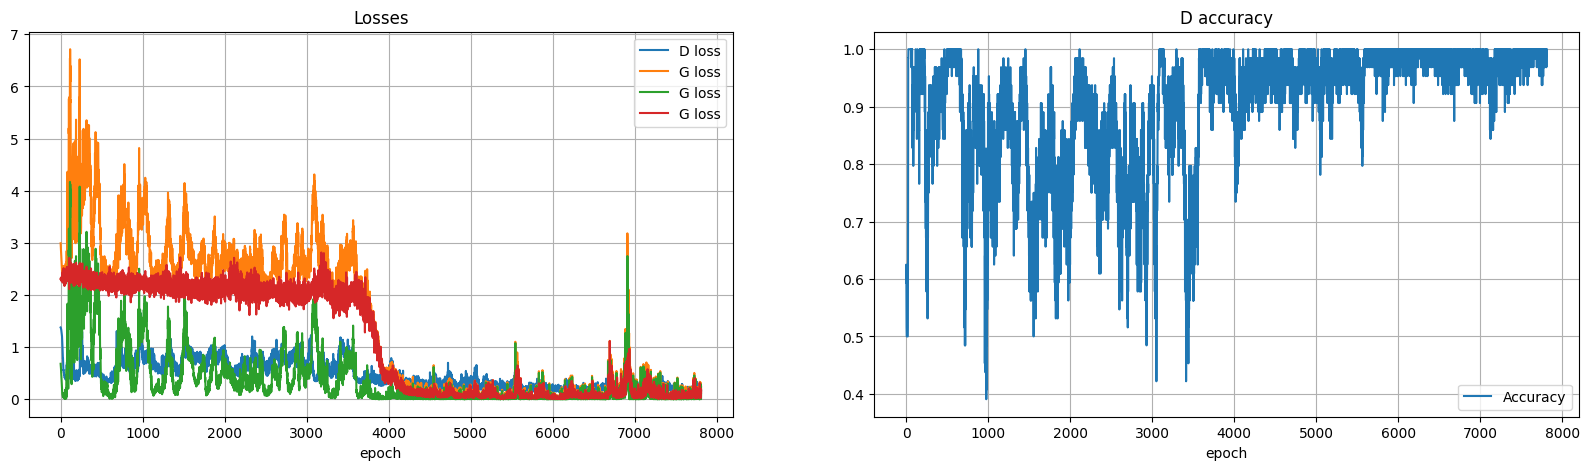

----EPOCH 5-----
0 [D loss: 0.2585,	 acc.: 96.88%]	[G loss: 0.2005]


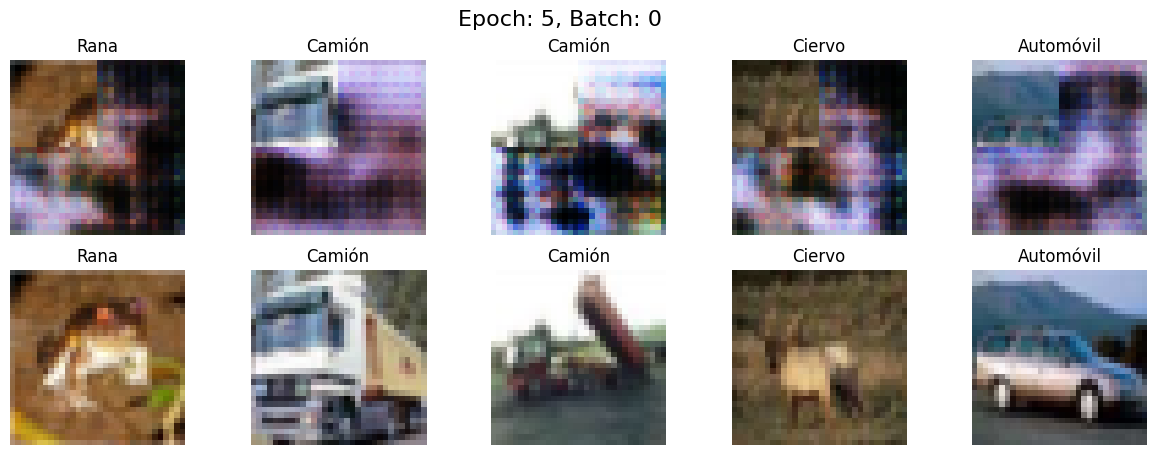

50 [D loss: 0.2001,	 acc.: 98.44%]	[G loss: 0.1026]
100 [D loss: 0.2145,	 acc.: 98.44%]	[G loss: 0.0906]
150 [D loss: 0.1655,	 acc.: 100.00%]	[G loss: 0.1826]
200 [D loss: 0.1650,	 acc.: 98.44%]	[G loss: 0.5227]
250 [D loss: 0.1637,	 acc.: 100.00%]	[G loss: 0.3140]
300 [D loss: 0.1526,	 acc.: 100.00%]	[G loss: 0.1013]
350 [D loss: 0.1376,	 acc.: 100.00%]	[G loss: 0.0611]
400 [D loss: 0.1284,	 acc.: 100.00%]	[G loss: 0.4236]
450 [D loss: 0.1606,	 acc.: 100.00%]	[G loss: 1.9268]
500 [D loss: 0.1528,	 acc.: 100.00%]	[G loss: 0.2566]


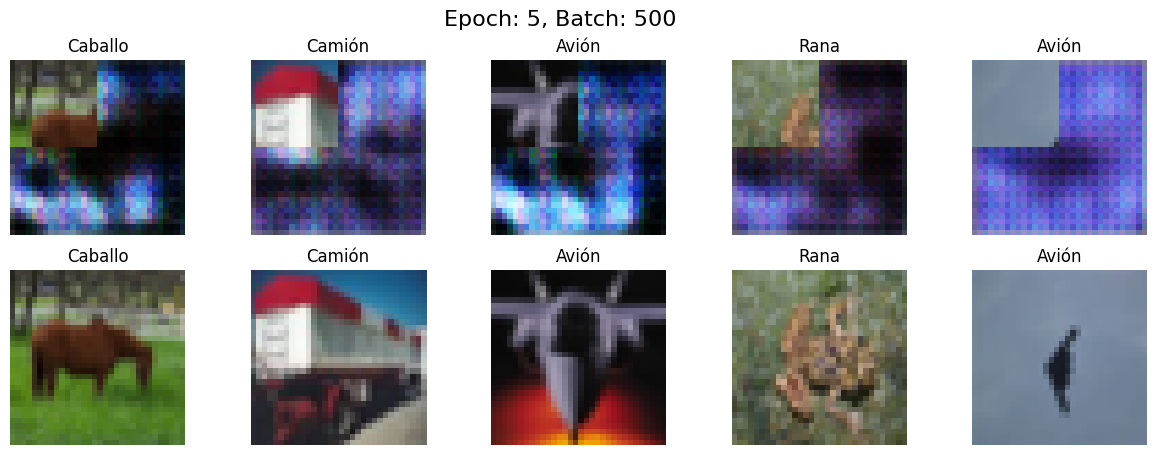

550 [D loss: 0.1535,	 acc.: 100.00%]	[G loss: 0.0210]
600 [D loss: 0.1565,	 acc.: 100.00%]	[G loss: 0.1364]
650 [D loss: 0.1264,	 acc.: 100.00%]	[G loss: 0.1045]
700 [D loss: 0.1635,	 acc.: 98.44%]	[G loss: 0.0595]
750 [D loss: 0.1637,	 acc.: 98.44%]	[G loss: 0.0445]
800 [D loss: 0.1627,	 acc.: 100.00%]	[G loss: 0.3261]
850 [D loss: 0.1908,	 acc.: 96.88%]	[G loss: 0.0553]
900 [D loss: 0.1540,	 acc.: 100.00%]	[G loss: 0.0533]
950 [D loss: 0.1480,	 acc.: 100.00%]	[G loss: 0.0347]
1000 [D loss: 0.2549,	 acc.: 98.44%]	[G loss: 0.0191]


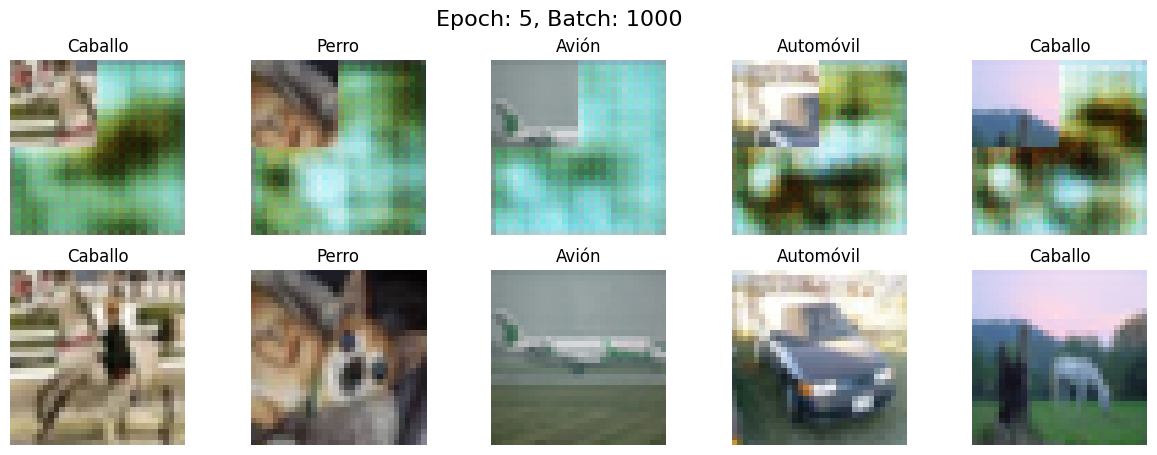

1050 [D loss: 0.1640,	 acc.: 100.00%]	[G loss: 0.1000]
1100 [D loss: 0.1663,	 acc.: 100.00%]	[G loss: 0.0914]
1150 [D loss: 0.1776,	 acc.: 98.44%]	[G loss: 0.5700]
1200 [D loss: 0.2247,	 acc.: 98.44%]	[G loss: 0.2769]
1250 [D loss: 0.1652,	 acc.: 100.00%]	[G loss: 0.1357]
1300 [D loss: 0.1311,	 acc.: 100.00%]	[G loss: 0.1365]
1350 [D loss: 0.1719,	 acc.: 98.44%]	[G loss: 0.1002]
1400 [D loss: 0.1385,	 acc.: 100.00%]	[G loss: 0.1362]
1450 [D loss: 0.1452,	 acc.: 100.00%]	[G loss: 0.3129]
1500 [D loss: 0.1514,	 acc.: 100.00%]	[G loss: 0.3634]


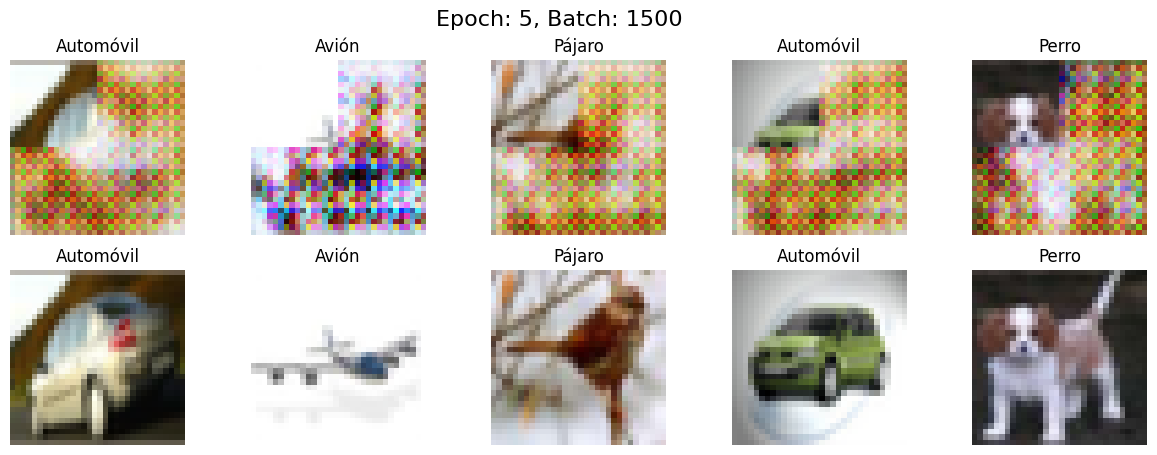

1550 [D loss: 0.1489,	 acc.: 100.00%]	[G loss: 0.8261]


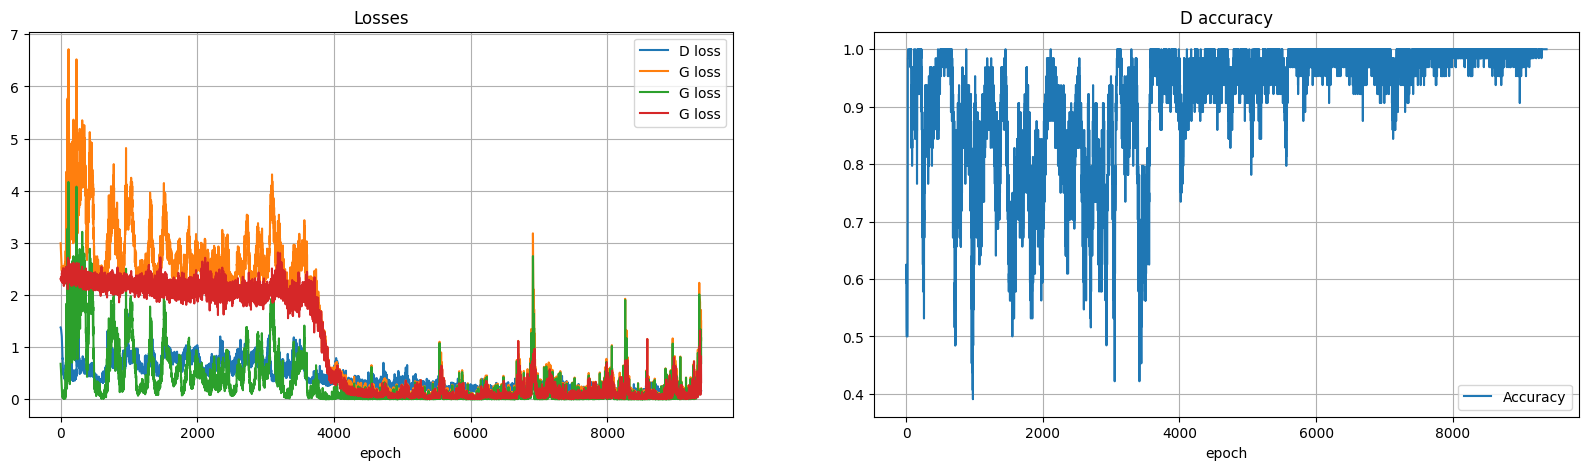

----EPOCH 6-----
0 [D loss: 0.1512,	 acc.: 100.00%]	[G loss: 1.0144]


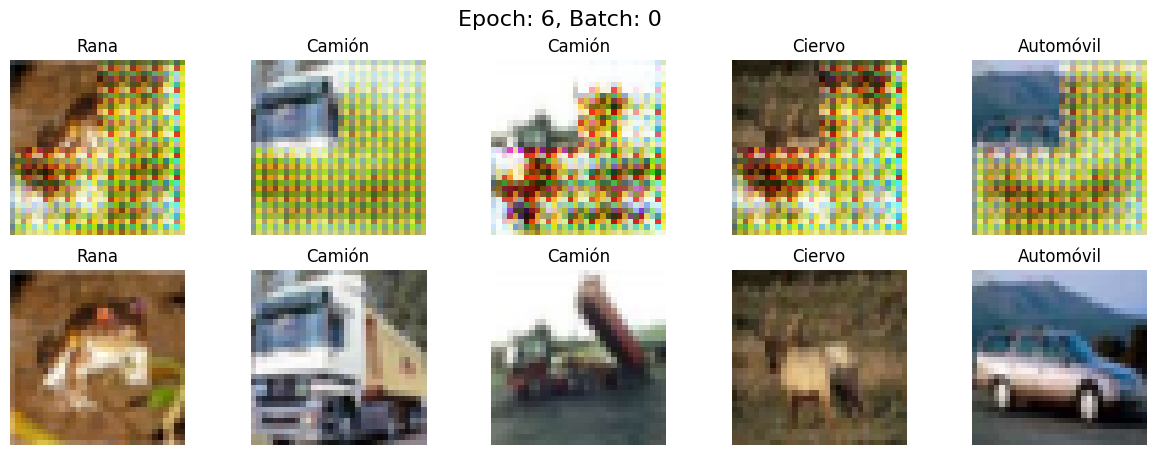

50 [D loss: 0.1221,	 acc.: 100.00%]	[G loss: 0.2773]
100 [D loss: 0.1647,	 acc.: 100.00%]	[G loss: 0.1508]
150 [D loss: 0.1378,	 acc.: 100.00%]	[G loss: 0.0794]
200 [D loss: 0.1325,	 acc.: 100.00%]	[G loss: 0.1464]
250 [D loss: 0.1486,	 acc.: 100.00%]	[G loss: 0.3980]
300 [D loss: 0.1540,	 acc.: 100.00%]	[G loss: 0.1078]
350 [D loss: 0.1720,	 acc.: 98.44%]	[G loss: 0.4423]
400 [D loss: 0.1672,	 acc.: 98.44%]	[G loss: 0.2644]
450 [D loss: 0.2794,	 acc.: 96.88%]	[G loss: 0.5102]
500 [D loss: 0.2838,	 acc.: 95.31%]	[G loss: 1.1345]


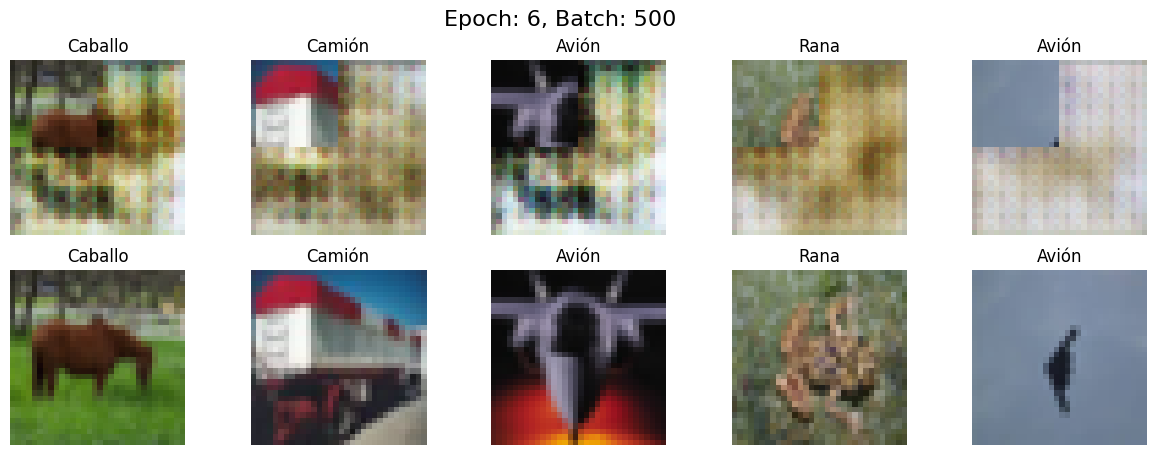

550 [D loss: 0.1844,	 acc.: 98.44%]	[G loss: 0.5038]
600 [D loss: 0.2021,	 acc.: 98.44%]	[G loss: 0.2253]
650 [D loss: 0.1348,	 acc.: 100.00%]	[G loss: 0.0778]
700 [D loss: 0.3346,	 acc.: 95.31%]	[G loss: 0.2020]
750 [D loss: 0.1664,	 acc.: 98.44%]	[G loss: 0.2224]
800 [D loss: 0.2088,	 acc.: 98.44%]	[G loss: 0.4803]
850 [D loss: 0.1760,	 acc.: 100.00%]	[G loss: 0.3131]
900 [D loss: 0.1395,	 acc.: 100.00%]	[G loss: 0.2248]
950 [D loss: 0.1878,	 acc.: 98.44%]	[G loss: 0.1460]
1000 [D loss: 0.1477,	 acc.: 100.00%]	[G loss: 0.0788]


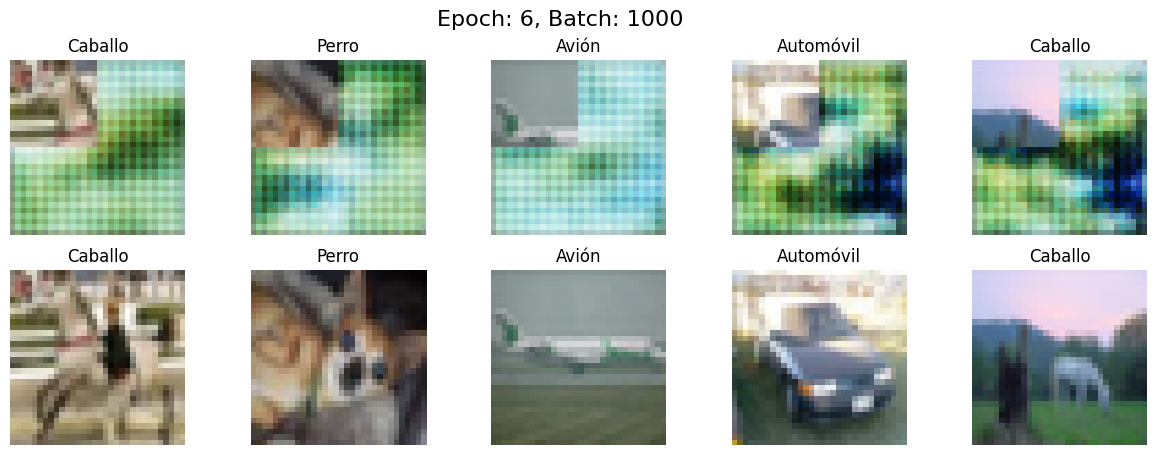

1050 [D loss: 0.1396,	 acc.: 100.00%]	[G loss: 0.0766]
1100 [D loss: 0.1550,	 acc.: 100.00%]	[G loss: 0.1051]
1150 [D loss: 0.1436,	 acc.: 100.00%]	[G loss: 0.1366]
1200 [D loss: 0.1626,	 acc.: 100.00%]	[G loss: 0.1098]
1250 [D loss: 0.1436,	 acc.: 100.00%]	[G loss: 0.1767]
1300 [D loss: 0.1809,	 acc.: 96.88%]	[G loss: 0.5490]
1350 [D loss: 0.1463,	 acc.: 100.00%]	[G loss: 0.2302]
1400 [D loss: 0.1477,	 acc.: 100.00%]	[G loss: 0.2373]
1450 [D loss: 0.2280,	 acc.: 98.44%]	[G loss: 0.0663]
1500 [D loss: 0.2149,	 acc.: 96.88%]	[G loss: 0.2134]


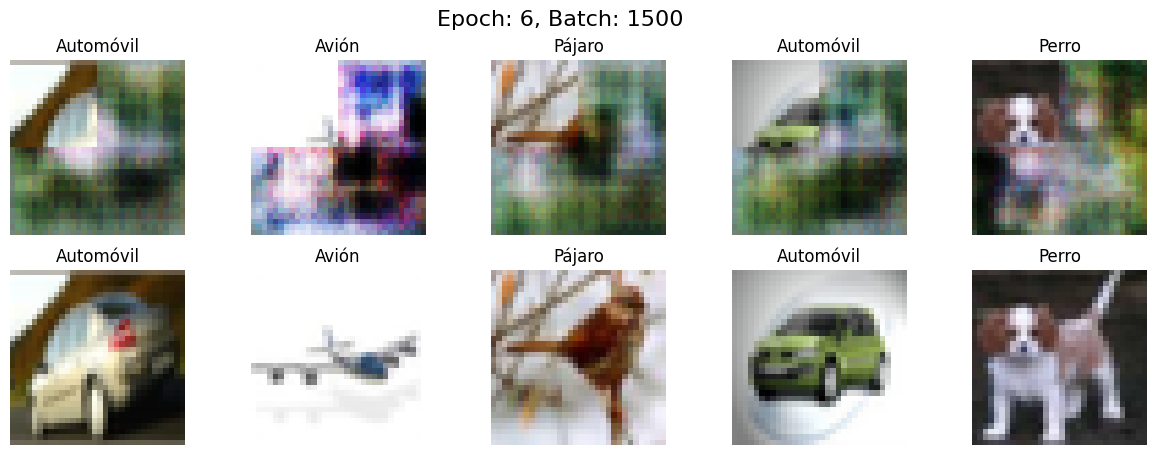

1550 [D loss: 0.1541,	 acc.: 100.00%]	[G loss: 0.8988]


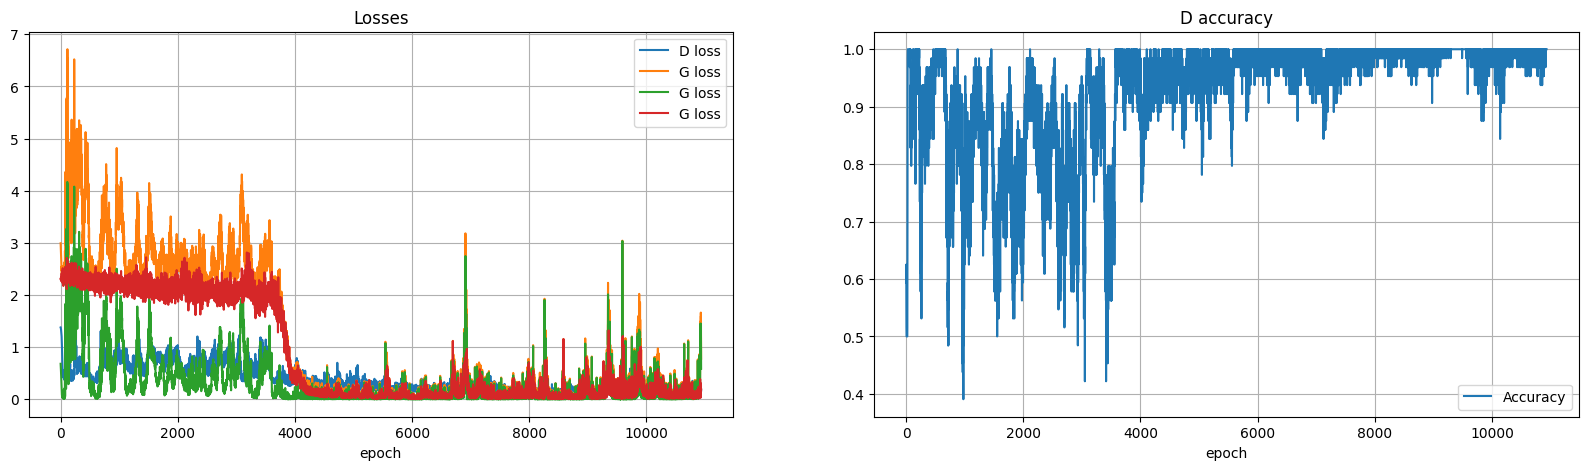

----EPOCH 7-----
0 [D loss: 0.1603,	 acc.: 100.00%]	[G loss: 0.9693]


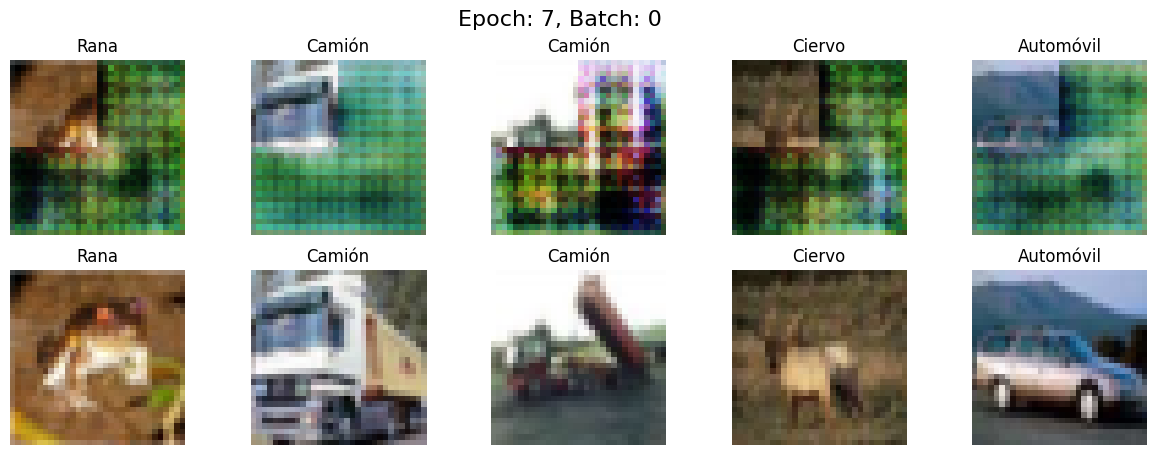

50 [D loss: 0.1294,	 acc.: 100.00%]	[G loss: 0.6937]
100 [D loss: 0.1473,	 acc.: 100.00%]	[G loss: 1.2222]
150 [D loss: 0.1419,	 acc.: 100.00%]	[G loss: 0.2289]
200 [D loss: 0.1868,	 acc.: 96.88%]	[G loss: 0.2569]
250 [D loss: 0.1510,	 acc.: 100.00%]	[G loss: 0.2613]
300 [D loss: 0.1392,	 acc.: 100.00%]	[G loss: 0.2916]
350 [D loss: 0.1616,	 acc.: 98.44%]	[G loss: 0.2449]
400 [D loss: 0.1239,	 acc.: 100.00%]	[G loss: 0.1550]
450 [D loss: 0.2150,	 acc.: 98.44%]	[G loss: 0.1754]
500 [D loss: 0.2908,	 acc.: 92.19%]	[G loss: 0.5874]


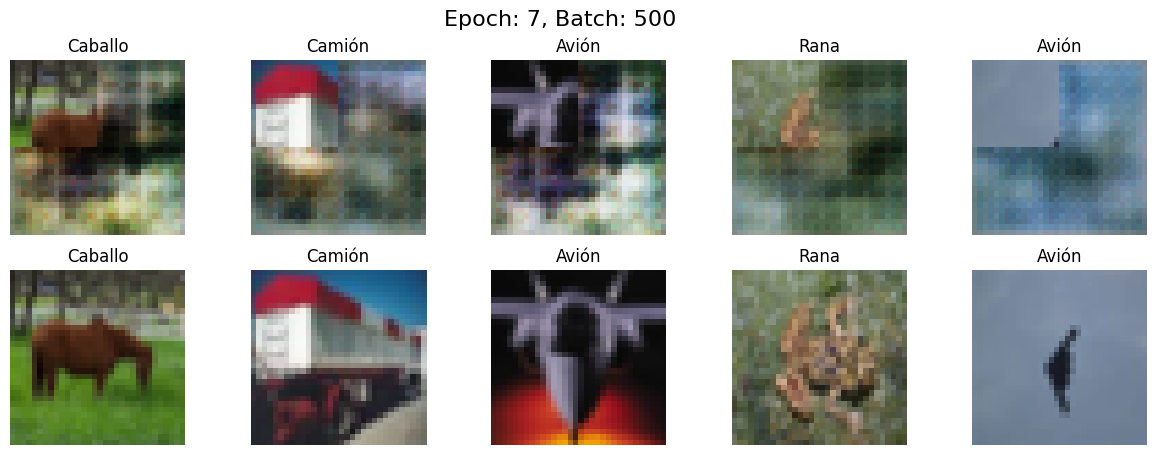

550 [D loss: 0.1900,	 acc.: 100.00%]	[G loss: 0.4187]
600 [D loss: 0.2018,	 acc.: 98.44%]	[G loss: 0.2711]
650 [D loss: 0.1197,	 acc.: 100.00%]	[G loss: 0.1613]
700 [D loss: 0.1312,	 acc.: 100.00%]	[G loss: 0.2550]
750 [D loss: 0.1210,	 acc.: 100.00%]	[G loss: 0.2745]
800 [D loss: 0.1981,	 acc.: 96.88%]	[G loss: 0.6465]
850 [D loss: 0.1615,	 acc.: 100.00%]	[G loss: 0.2263]
900 [D loss: 0.1450,	 acc.: 98.44%]	[G loss: 0.0984]
950 [D loss: 0.1356,	 acc.: 100.00%]	[G loss: 0.1864]
1000 [D loss: 0.1367,	 acc.: 100.00%]	[G loss: 0.1264]


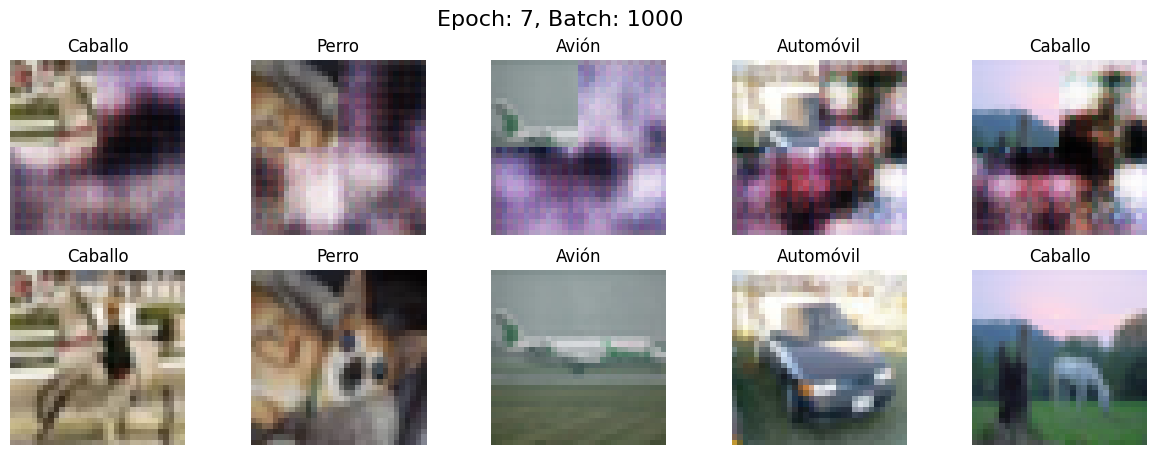

1050 [D loss: 0.1664,	 acc.: 100.00%]	[G loss: 0.0963]
1100 [D loss: 0.1557,	 acc.: 100.00%]	[G loss: 0.1157]
1150 [D loss: 0.2046,	 acc.: 98.44%]	[G loss: 0.4497]
1200 [D loss: 0.2032,	 acc.: 98.44%]	[G loss: 0.2609]
1250 [D loss: 0.1275,	 acc.: 100.00%]	[G loss: 0.1142]
1300 [D loss: 0.1976,	 acc.: 98.44%]	[G loss: 0.3159]
1350 [D loss: 0.1448,	 acc.: 100.00%]	[G loss: 0.4059]
1400 [D loss: 0.1494,	 acc.: 100.00%]	[G loss: 2.9479]
1450 [D loss: 0.1500,	 acc.: 100.00%]	[G loss: 1.6466]
1500 [D loss: 0.1580,	 acc.: 100.00%]	[G loss: 0.8757]


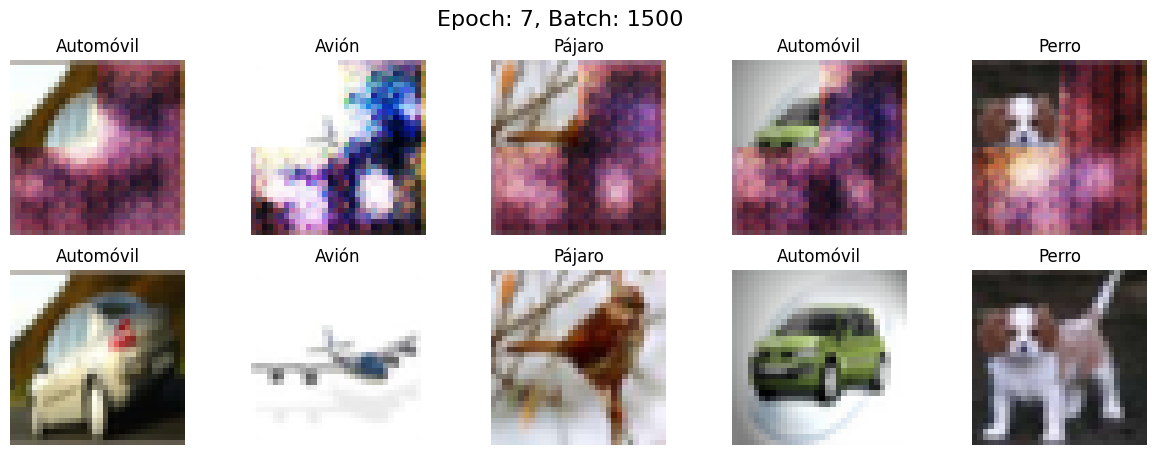

1550 [D loss: 0.1227,	 acc.: 100.00%]	[G loss: 0.1767]


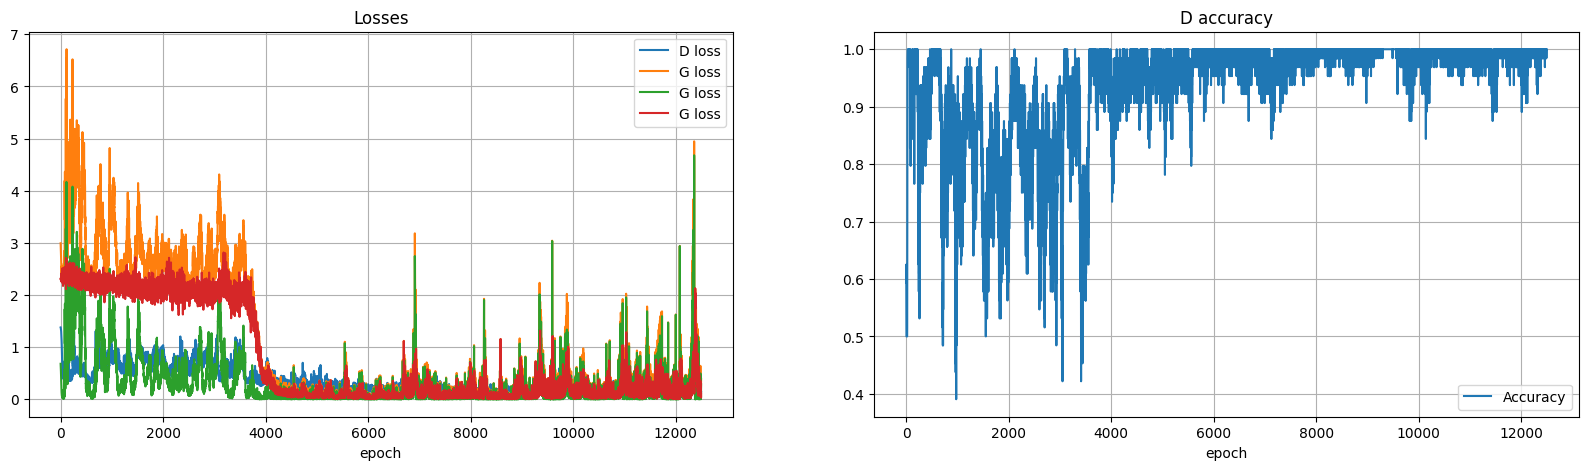

----EPOCH 8-----
0 [D loss: 0.2760,	 acc.: 98.44%]	[G loss: 0.3565]


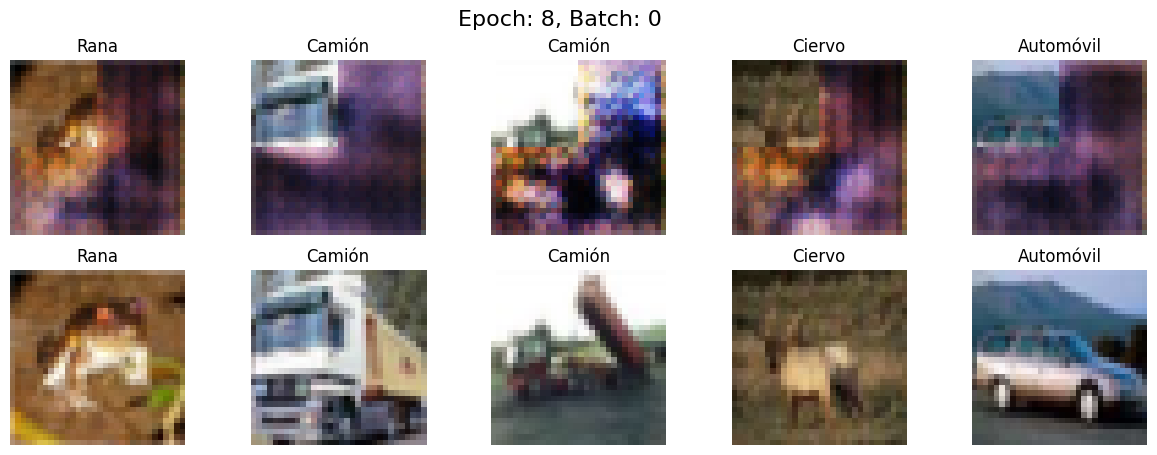

50 [D loss: 0.2605,	 acc.: 96.88%]	[G loss: 0.2368]
100 [D loss: 0.1540,	 acc.: 100.00%]	[G loss: 0.0966]
150 [D loss: 0.1353,	 acc.: 100.00%]	[G loss: 0.2020]
200 [D loss: 0.1517,	 acc.: 100.00%]	[G loss: 0.2855]
250 [D loss: 0.1457,	 acc.: 100.00%]	[G loss: 0.1795]
300 [D loss: 0.1321,	 acc.: 100.00%]	[G loss: 0.1093]
350 [D loss: 0.1393,	 acc.: 100.00%]	[G loss: 0.0992]
400 [D loss: 0.1600,	 acc.: 98.44%]	[G loss: 0.3121]
450 [D loss: 0.1454,	 acc.: 100.00%]	[G loss: 0.1229]
500 [D loss: 0.1483,	 acc.: 100.00%]	[G loss: 0.3909]


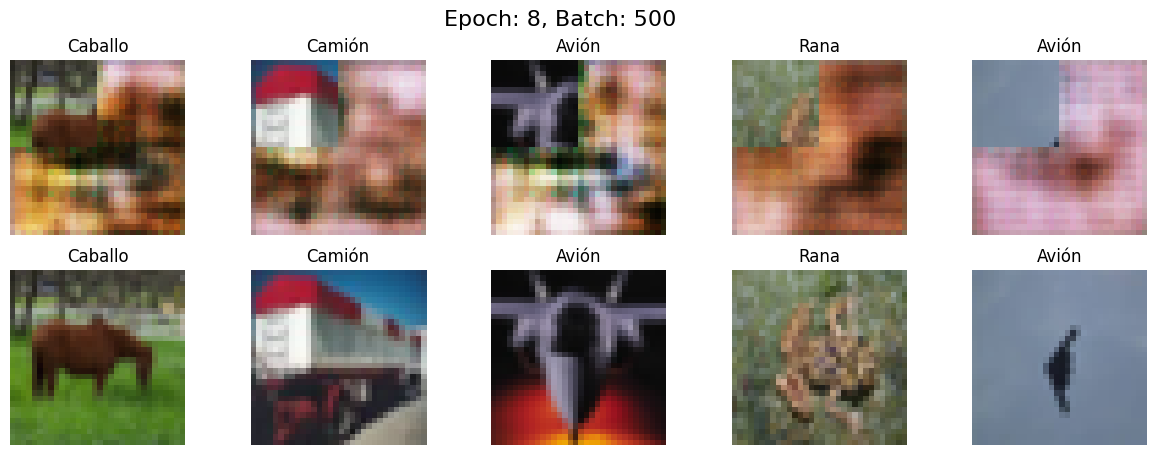

550 [D loss: 0.1225,	 acc.: 100.00%]	[G loss: 0.2565]
600 [D loss: 0.1407,	 acc.: 100.00%]	[G loss: 0.0718]
650 [D loss: 0.1183,	 acc.: 100.00%]	[G loss: 0.0853]
700 [D loss: 0.1227,	 acc.: 100.00%]	[G loss: 0.1130]
750 [D loss: 0.1181,	 acc.: 100.00%]	[G loss: 0.0419]
800 [D loss: 0.1895,	 acc.: 98.44%]	[G loss: 0.1401]
850 [D loss: 0.1513,	 acc.: 100.00%]	[G loss: 0.1348]
900 [D loss: 0.1748,	 acc.: 98.44%]	[G loss: 0.3466]
950 [D loss: 0.1820,	 acc.: 98.44%]	[G loss: 0.1830]
1000 [D loss: 0.1742,	 acc.: 98.44%]	[G loss: 0.0863]


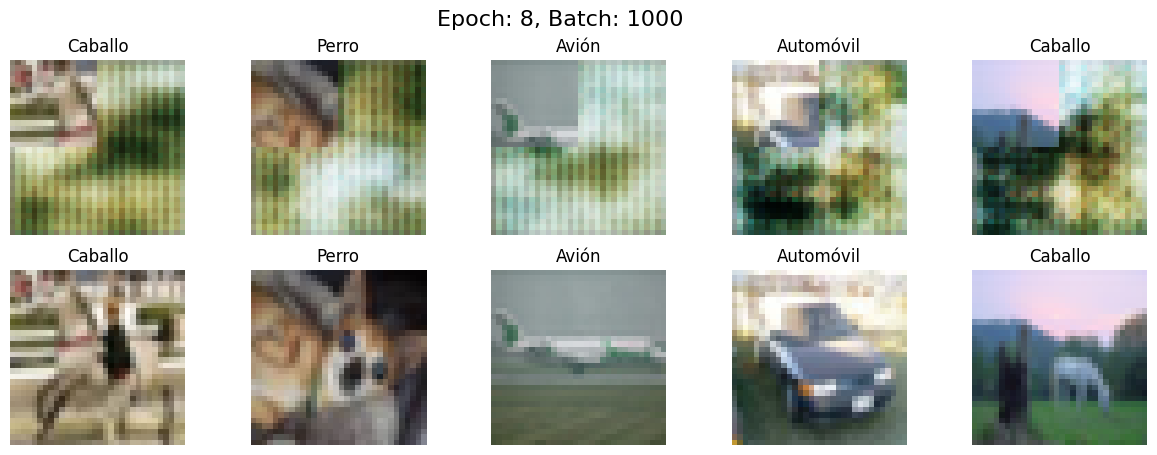

1050 [D loss: 0.1623,	 acc.: 100.00%]	[G loss: 0.0748]
1100 [D loss: 0.1520,	 acc.: 100.00%]	[G loss: 0.0440]
1150 [D loss: 0.1305,	 acc.: 100.00%]	[G loss: 0.1009]
1200 [D loss: 0.1348,	 acc.: 100.00%]	[G loss: 0.1856]
1250 [D loss: 0.1344,	 acc.: 100.00%]	[G loss: 0.3292]
1300 [D loss: 0.1232,	 acc.: 100.00%]	[G loss: 0.1580]
1350 [D loss: 0.1516,	 acc.: 100.00%]	[G loss: 0.9871]
1400 [D loss: 0.1278,	 acc.: 100.00%]	[G loss: 0.7273]
1450 [D loss: 0.1318,	 acc.: 100.00%]	[G loss: 1.6699]
1500 [D loss: 0.1678,	 acc.: 100.00%]	[G loss: 0.8140]


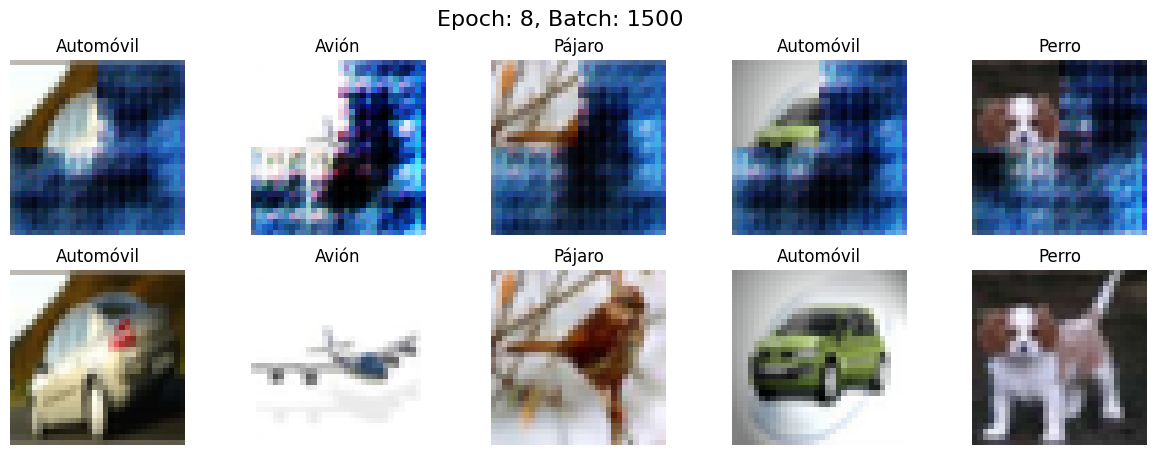

1550 [D loss: 0.1261,	 acc.: 100.00%]	[G loss: 0.1318]


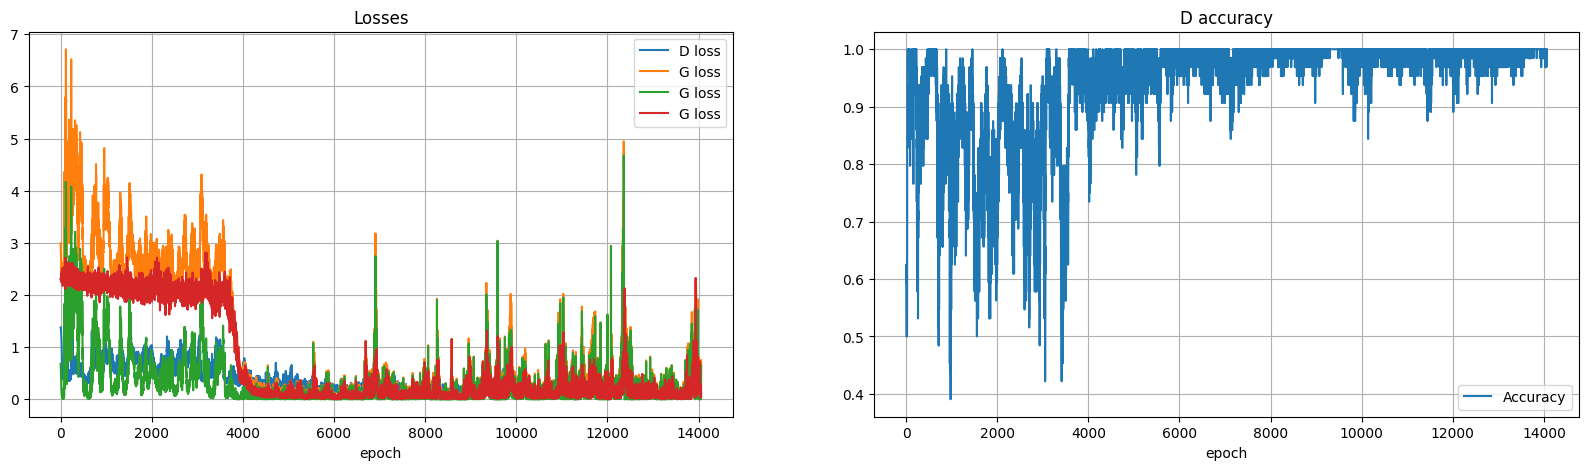

----EPOCH 9-----
0 [D loss: 0.1424,	 acc.: 100.00%]	[G loss: 0.3998]


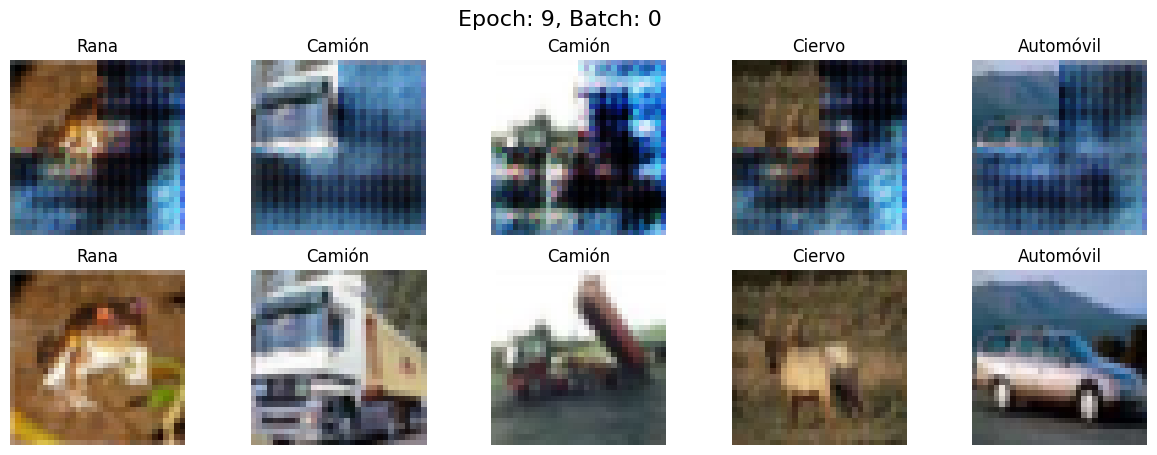

50 [D loss: 0.1663,	 acc.: 98.44%]	[G loss: 0.3236]
100 [D loss: 0.1713,	 acc.: 100.00%]	[G loss: 0.1176]
150 [D loss: 0.2940,	 acc.: 93.75%]	[G loss: 0.4923]
200 [D loss: 0.2330,	 acc.: 98.44%]	[G loss: 0.9040]
250 [D loss: 0.2201,	 acc.: 98.44%]	[G loss: 1.0888]
300 [D loss: 0.1540,	 acc.: 100.00%]	[G loss: 0.4076]
350 [D loss: 0.1806,	 acc.: 98.44%]	[G loss: 0.3483]
400 [D loss: 0.1305,	 acc.: 100.00%]	[G loss: 0.3932]
450 [D loss: 0.1551,	 acc.: 100.00%]	[G loss: 0.5782]
500 [D loss: 0.1431,	 acc.: 98.44%]	[G loss: 0.5915]


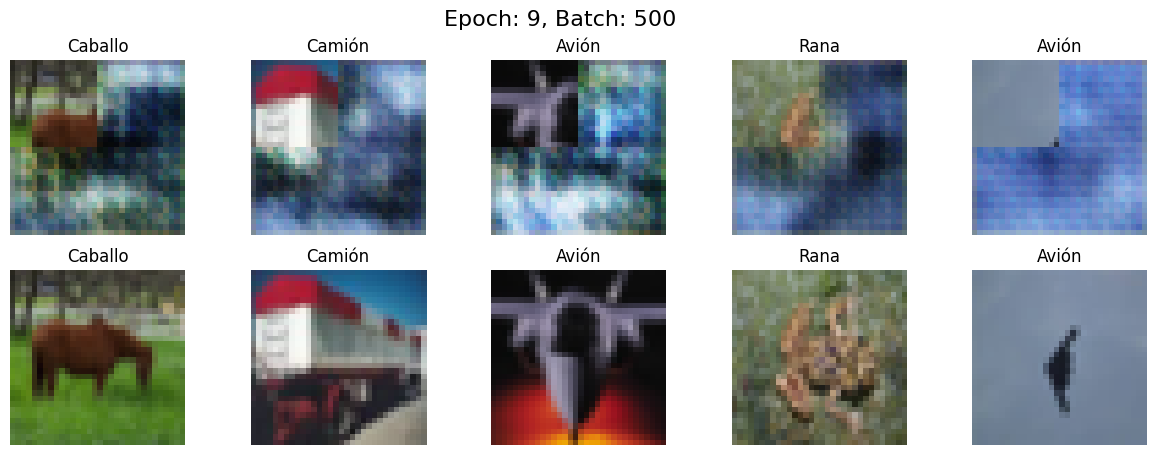

550 [D loss: 0.2297,	 acc.: 96.88%]	[G loss: 0.2737]
600 [D loss: 0.1442,	 acc.: 100.00%]	[G loss: 0.1081]
650 [D loss: 0.1380,	 acc.: 98.44%]	[G loss: 0.2741]
700 [D loss: 0.1663,	 acc.: 98.44%]	[G loss: 0.1216]
750 [D loss: 0.1246,	 acc.: 100.00%]	[G loss: 0.0415]
800 [D loss: 0.2098,	 acc.: 95.31%]	[G loss: 0.3232]
850 [D loss: 0.1435,	 acc.: 100.00%]	[G loss: 0.4027]
900 [D loss: 0.1543,	 acc.: 98.44%]	[G loss: 0.3982]
950 [D loss: 0.1459,	 acc.: 100.00%]	[G loss: 0.4321]
1000 [D loss: 0.1944,	 acc.: 98.44%]	[G loss: 0.2421]


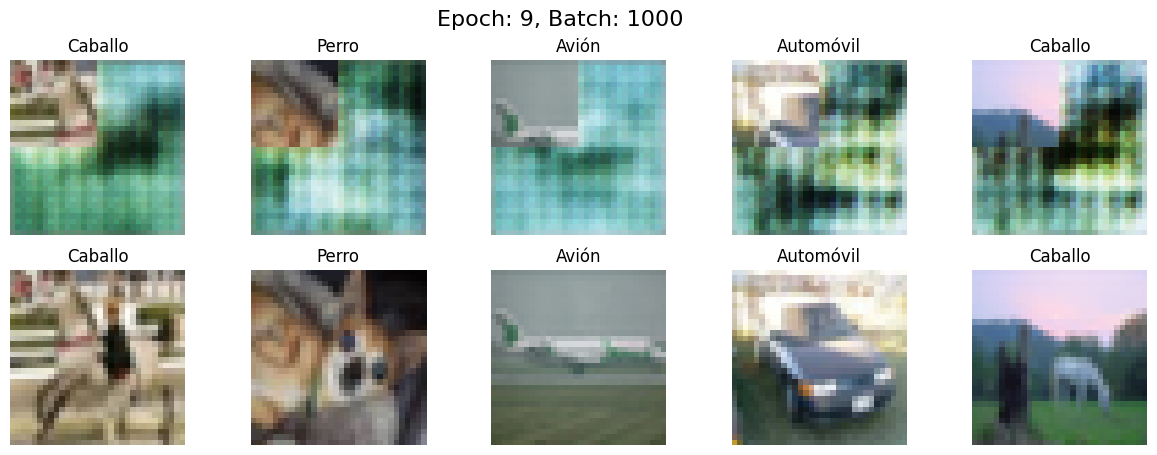

1050 [D loss: 0.1608,	 acc.: 98.44%]	[G loss: 0.0917]
1100 [D loss: 0.1429,	 acc.: 100.00%]	[G loss: 0.2180]
1150 [D loss: 0.1458,	 acc.: 100.00%]	[G loss: 0.1248]
1200 [D loss: 0.1505,	 acc.: 100.00%]	[G loss: 0.1018]
1250 [D loss: 0.1223,	 acc.: 100.00%]	[G loss: 0.0840]
1300 [D loss: 0.1284,	 acc.: 98.44%]	[G loss: 0.2505]
1350 [D loss: 0.1341,	 acc.: 100.00%]	[G loss: 0.2429]
1400 [D loss: 0.1448,	 acc.: 98.44%]	[G loss: 0.4430]
1450 [D loss: 0.1309,	 acc.: 100.00%]	[G loss: 0.5218]
1500 [D loss: 0.1806,	 acc.: 100.00%]	[G loss: 1.2089]


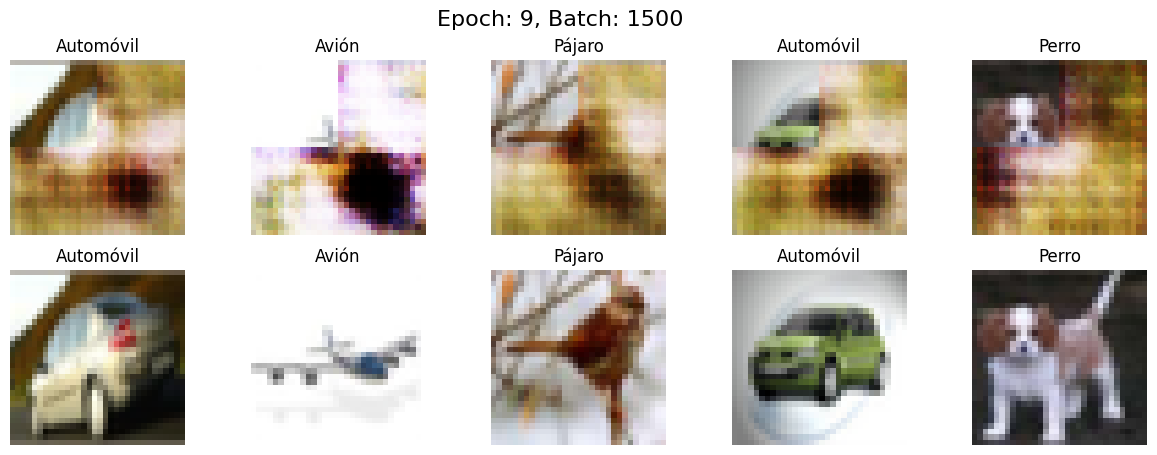

1550 [D loss: 0.1973,	 acc.: 98.44%]	[G loss: 0.3834]


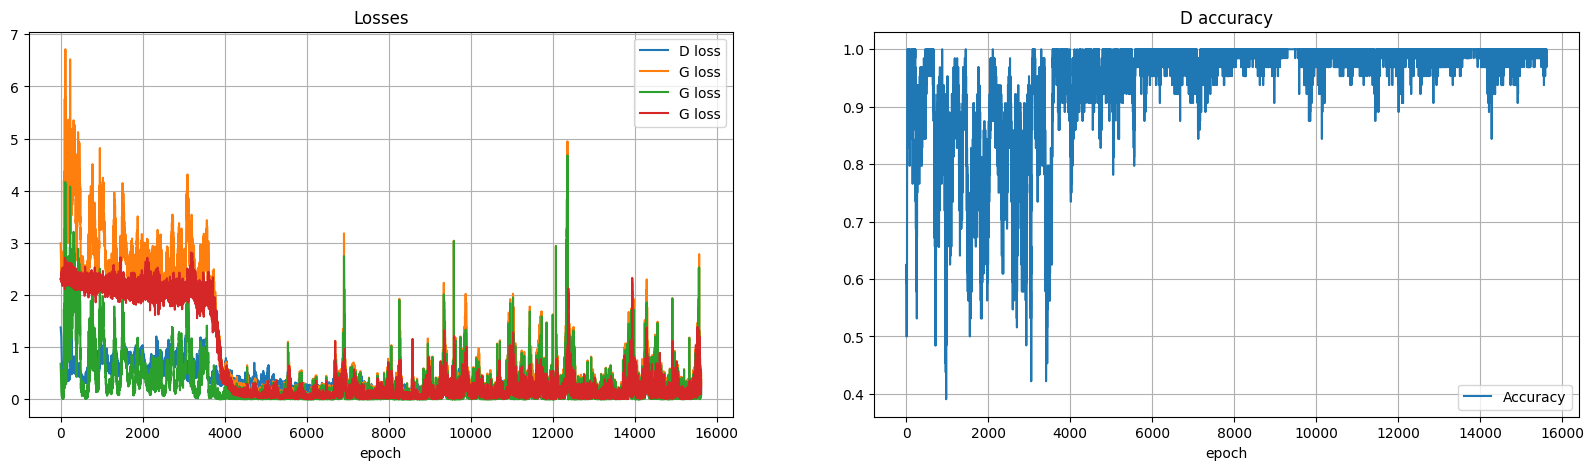

----EPOCH 10-----
0 [D loss: 0.1409,	 acc.: 100.00%]	[G loss: 0.4629]


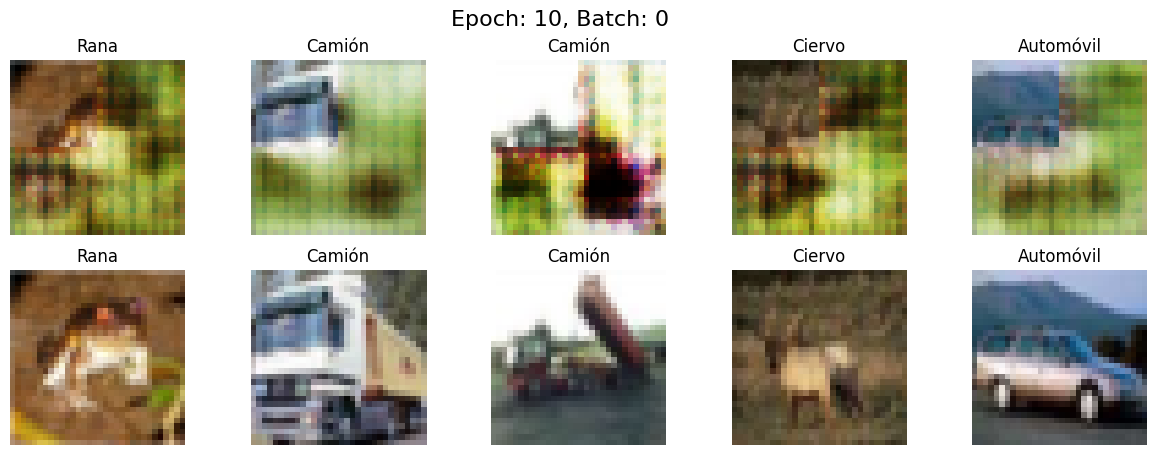

50 [D loss: 0.1170,	 acc.: 100.00%]	[G loss: 0.1279]
100 [D loss: 0.1439,	 acc.: 100.00%]	[G loss: 0.1092]
150 [D loss: 0.1231,	 acc.: 100.00%]	[G loss: 0.0443]
200 [D loss: 0.1132,	 acc.: 100.00%]	[G loss: 0.1403]
250 [D loss: 0.1192,	 acc.: 100.00%]	[G loss: 0.1738]
300 [D loss: 0.1493,	 acc.: 98.44%]	[G loss: 0.2906]
350 [D loss: 0.1661,	 acc.: 96.88%]	[G loss: 0.2683]
400 [D loss: 0.1764,	 acc.: 98.44%]	[G loss: 0.3362]
450 [D loss: 0.1990,	 acc.: 98.44%]	[G loss: 0.3632]
500 [D loss: 0.1726,	 acc.: 98.44%]	[G loss: 0.1293]


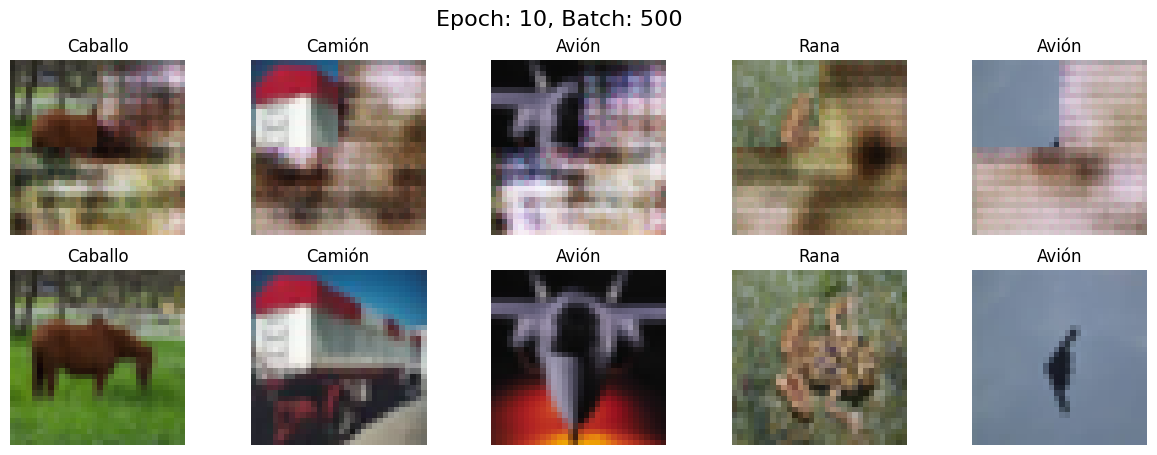

550 [D loss: 0.1901,	 acc.: 98.44%]	[G loss: 0.3165]
600 [D loss: 0.1657,	 acc.: 100.00%]	[G loss: 0.5096]
650 [D loss: 0.1484,	 acc.: 100.00%]	[G loss: 0.1736]
700 [D loss: 0.1290,	 acc.: 100.00%]	[G loss: 0.2970]
750 [D loss: 0.1223,	 acc.: 100.00%]	[G loss: 0.7364]
800 [D loss: 0.1343,	 acc.: 100.00%]	[G loss: 0.2168]
850 [D loss: 0.1319,	 acc.: 100.00%]	[G loss: 0.1274]
900 [D loss: 0.1533,	 acc.: 98.44%]	[G loss: 0.3725]
950 [D loss: 0.1699,	 acc.: 98.44%]	[G loss: 0.1057]
1000 [D loss: 0.1051,	 acc.: 100.00%]	[G loss: 0.1774]


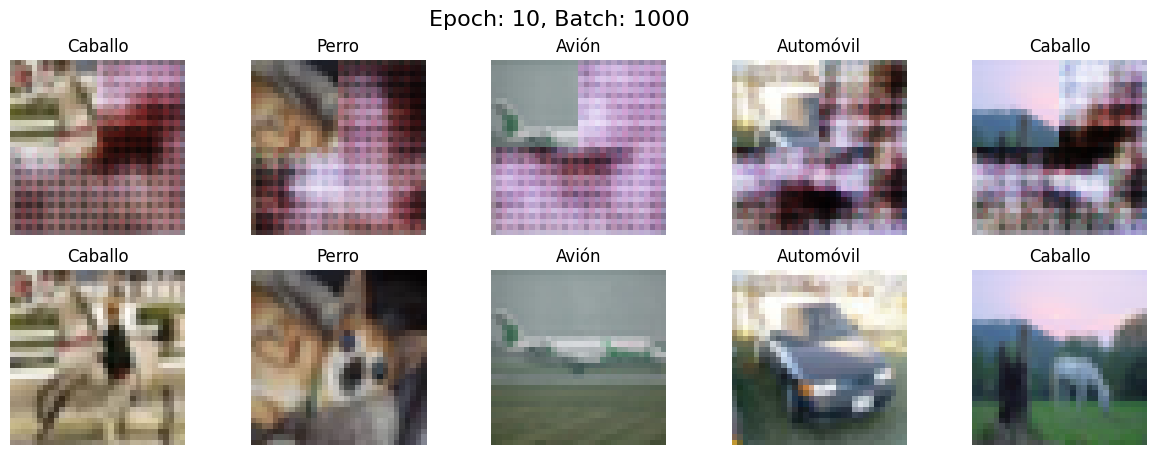

1050 [D loss: 0.1282,	 acc.: 100.00%]	[G loss: 0.2229]
1100 [D loss: 0.1330,	 acc.: 100.00%]	[G loss: 0.1614]
1150 [D loss: 0.1276,	 acc.: 100.00%]	[G loss: 0.1268]
1200 [D loss: 0.3382,	 acc.: 98.44%]	[G loss: 0.1512]
1250 [D loss: 0.1206,	 acc.: 100.00%]	[G loss: 0.1825]
1300 [D loss: 0.1295,	 acc.: 100.00%]	[G loss: 0.1690]
1350 [D loss: 0.1329,	 acc.: 100.00%]	[G loss: 0.1031]
1400 [D loss: 0.1305,	 acc.: 100.00%]	[G loss: 0.1169]
1450 [D loss: 0.1545,	 acc.: 98.44%]	[G loss: 0.0930]
1500 [D loss: 0.1701,	 acc.: 98.44%]	[G loss: 0.1386]


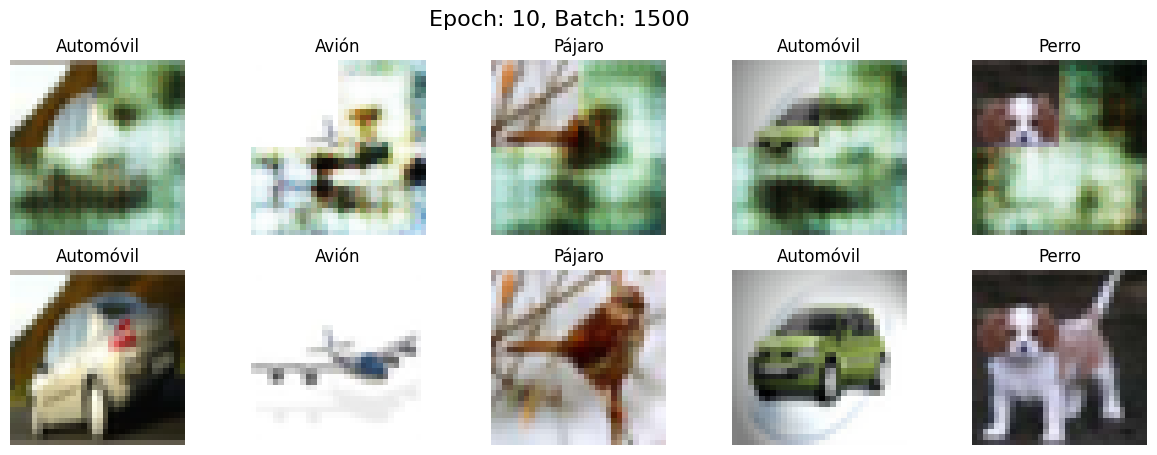

1550 [D loss: 0.1262,	 acc.: 98.44%]	[G loss: 0.0988]


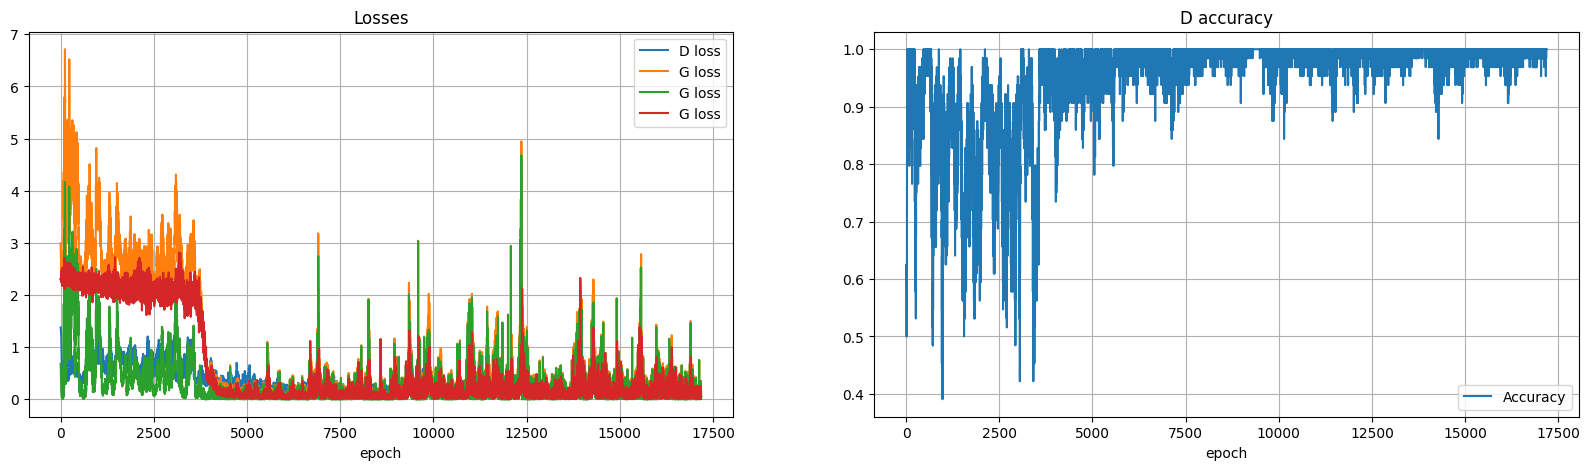

----EPOCH 11-----
0 [D loss: 0.1258,	 acc.: 100.00%]	[G loss: 0.3433]


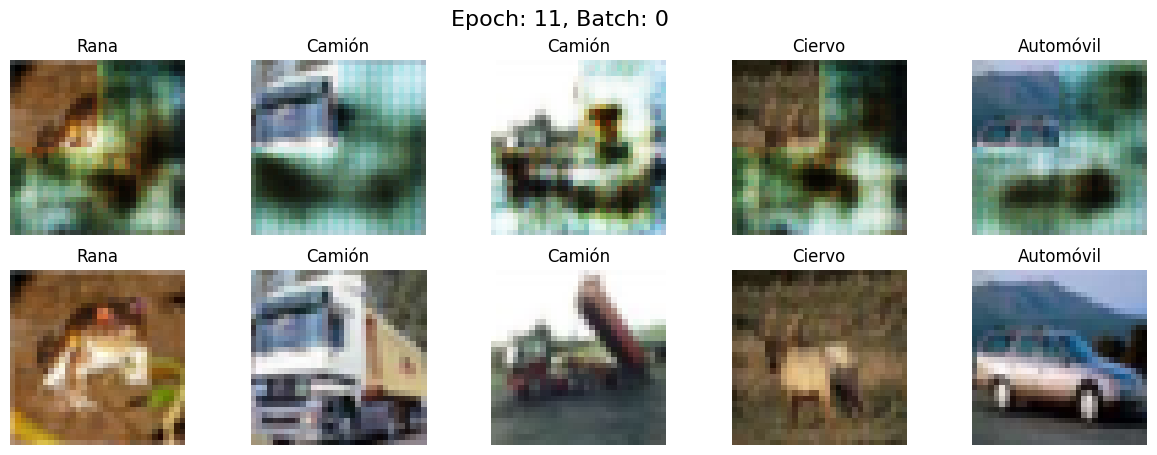

50 [D loss: 0.1034,	 acc.: 100.00%]	[G loss: 0.0814]
100 [D loss: 0.1327,	 acc.: 100.00%]	[G loss: 0.0743]
150 [D loss: 0.1188,	 acc.: 100.00%]	[G loss: 0.1387]
200 [D loss: 0.1146,	 acc.: 100.00%]	[G loss: 0.2234]
250 [D loss: 0.1288,	 acc.: 100.00%]	[G loss: 0.2441]
300 [D loss: 0.1210,	 acc.: 100.00%]	[G loss: 0.3129]
350 [D loss: 0.1111,	 acc.: 100.00%]	[G loss: 0.2492]
400 [D loss: 0.1180,	 acc.: 100.00%]	[G loss: 0.4938]
450 [D loss: 0.1448,	 acc.: 100.00%]	[G loss: 1.6198]
500 [D loss: 0.1560,	 acc.: 100.00%]	[G loss: 1.4634]


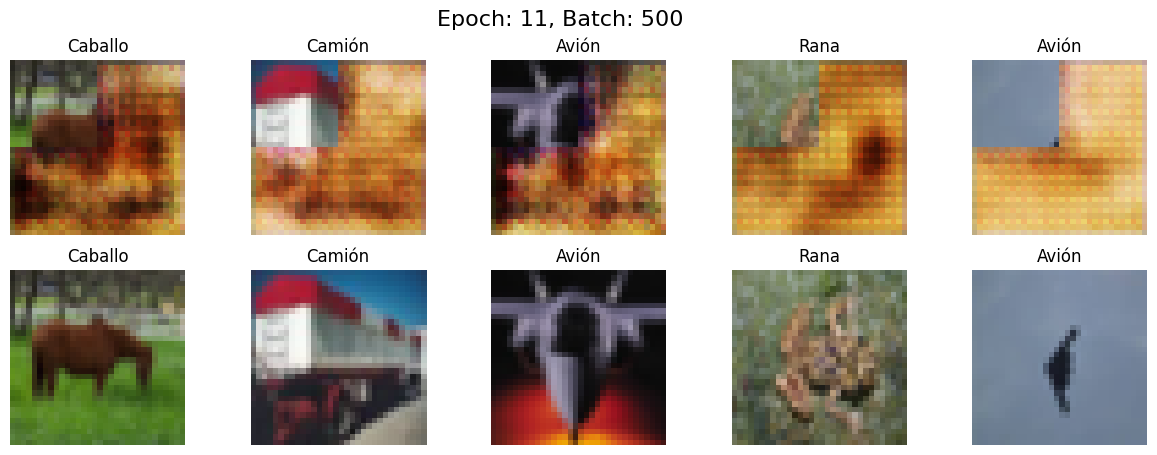

550 [D loss: 0.1288,	 acc.: 100.00%]	[G loss: 1.4506]
600 [D loss: 0.1348,	 acc.: 100.00%]	[G loss: 0.1504]
650 [D loss: 0.1175,	 acc.: 100.00%]	[G loss: 0.0563]
700 [D loss: 0.1237,	 acc.: 100.00%]	[G loss: 0.1517]
750 [D loss: 0.1133,	 acc.: 100.00%]	[G loss: 0.0472]
800 [D loss: 0.1358,	 acc.: 100.00%]	[G loss: 0.3314]
850 [D loss: 0.1472,	 acc.: 98.44%]	[G loss: 0.6118]
900 [D loss: 0.1683,	 acc.: 98.44%]	[G loss: 0.4371]
950 [D loss: 0.1596,	 acc.: 100.00%]	[G loss: 0.8157]
1000 [D loss: 0.1317,	 acc.: 100.00%]	[G loss: 0.1462]


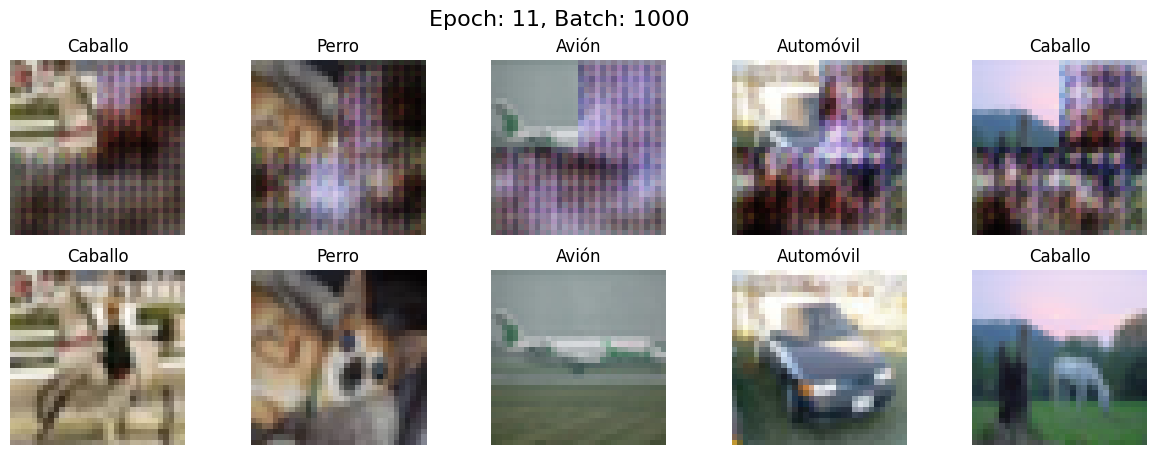

1050 [D loss: 0.1571,	 acc.: 98.44%]	[G loss: 0.1182]
1100 [D loss: 0.1401,	 acc.: 100.00%]	[G loss: 0.1188]
1150 [D loss: 0.1310,	 acc.: 100.00%]	[G loss: 0.1431]
1200 [D loss: 0.1583,	 acc.: 100.00%]	[G loss: 0.6804]
1250 [D loss: 0.1505,	 acc.: 100.00%]	[G loss: 0.7514]
1300 [D loss: 0.1248,	 acc.: 100.00%]	[G loss: 0.3452]
1350 [D loss: 0.1529,	 acc.: 100.00%]	[G loss: 0.2434]
1400 [D loss: 0.2435,	 acc.: 95.31%]	[G loss: 0.1603]
1450 [D loss: 0.1694,	 acc.: 98.44%]	[G loss: 0.2557]
1500 [D loss: 0.2044,	 acc.: 100.00%]	[G loss: 0.4936]


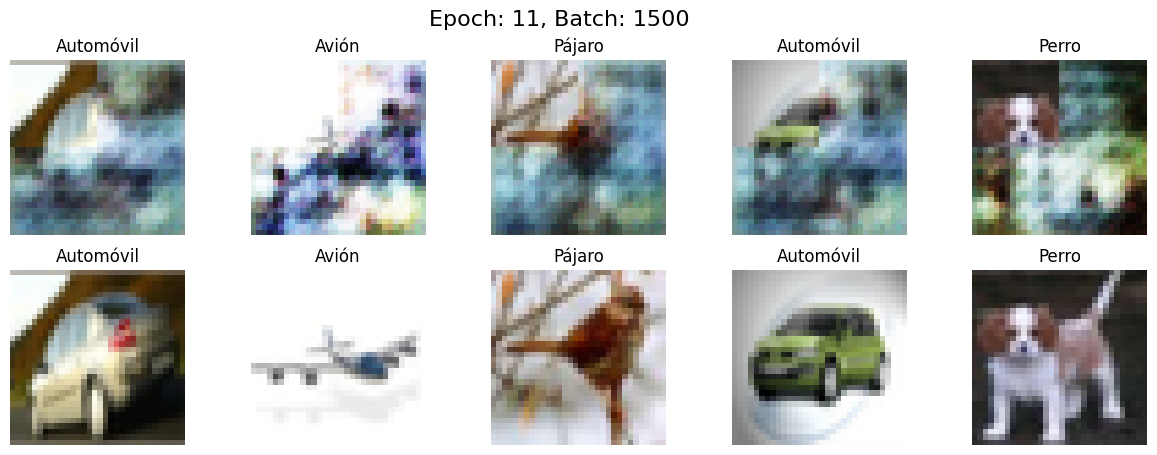

1550 [D loss: 0.1359,	 acc.: 100.00%]	[G loss: 0.5371]


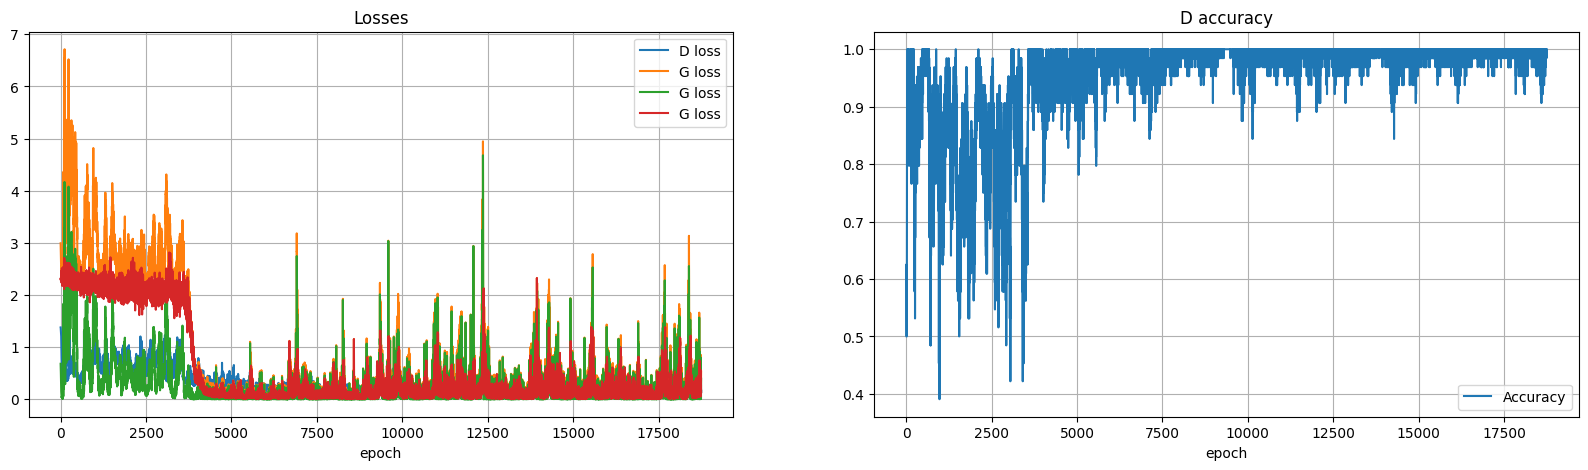

----EPOCH 12-----
0 [D loss: 0.1617,	 acc.: 100.00%]	[G loss: 0.6461]


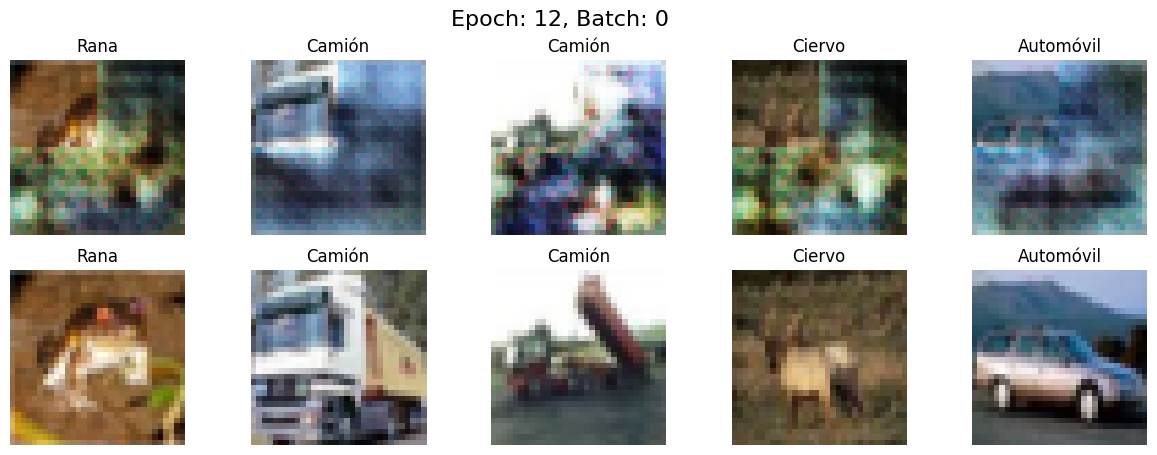

50 [D loss: 0.3259,	 acc.: 96.88%]	[G loss: 0.6035]
100 [D loss: 0.1907,	 acc.: 98.44%]	[G loss: 0.2266]
150 [D loss: 0.1520,	 acc.: 100.00%]	[G loss: 0.1771]
200 [D loss: 0.1400,	 acc.: 98.44%]	[G loss: 0.1454]
250 [D loss: 0.1228,	 acc.: 100.00%]	[G loss: 0.1905]
300 [D loss: 0.1663,	 acc.: 98.44%]	[G loss: 0.5753]
350 [D loss: 0.1248,	 acc.: 100.00%]	[G loss: 0.8096]
400 [D loss: 0.1731,	 acc.: 98.44%]	[G loss: 0.6145]
450 [D loss: 0.1271,	 acc.: 100.00%]	[G loss: 0.3375]
500 [D loss: 0.1281,	 acc.: 100.00%]	[G loss: 0.1034]


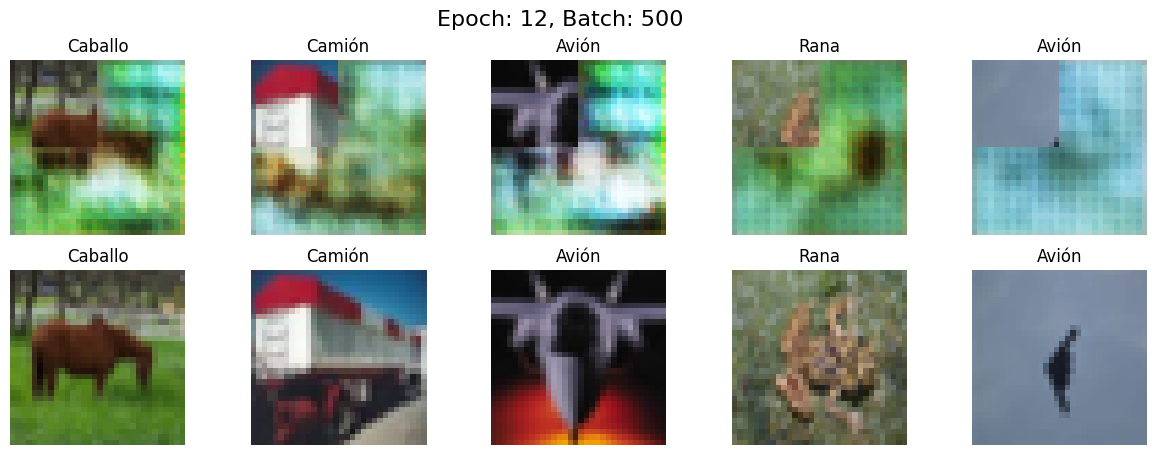

550 [D loss: 0.1301,	 acc.: 100.00%]	[G loss: 0.4567]
600 [D loss: 0.1671,	 acc.: 98.44%]	[G loss: 0.1043]
650 [D loss: 0.2117,	 acc.: 96.88%]	[G loss: 0.3021]
700 [D loss: 0.1163,	 acc.: 100.00%]	[G loss: 0.1868]
750 [D loss: 0.1218,	 acc.: 100.00%]	[G loss: 0.0676]
800 [D loss: 0.1219,	 acc.: 100.00%]	[G loss: 0.1438]
850 [D loss: 0.1370,	 acc.: 100.00%]	[G loss: 0.2261]
900 [D loss: 0.1301,	 acc.: 100.00%]	[G loss: 1.0144]
950 [D loss: 0.1745,	 acc.: 96.88%]	[G loss: 1.2493]
1000 [D loss: 0.1389,	 acc.: 100.00%]	[G loss: 0.2232]


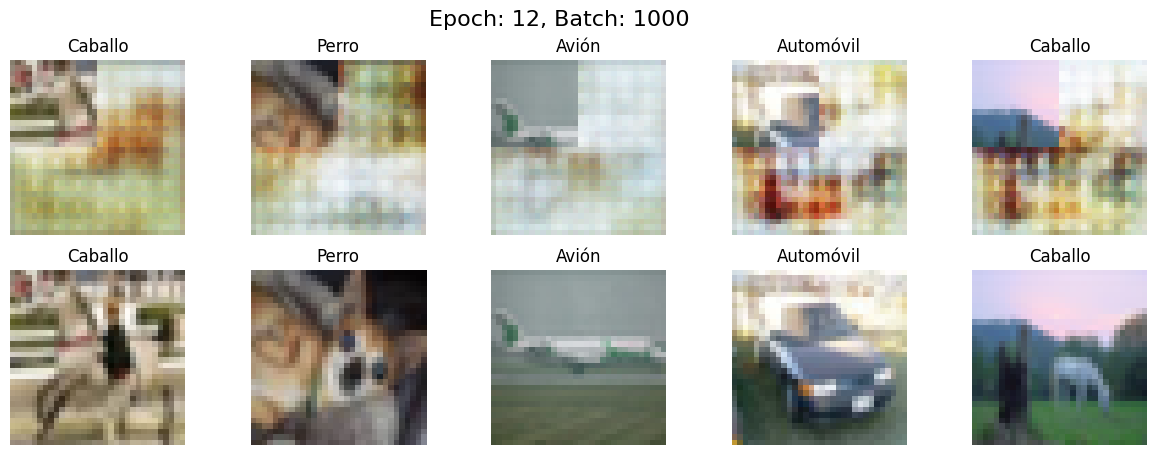

1050 [D loss: 0.1390,	 acc.: 98.44%]	[G loss: 0.0887]
1100 [D loss: 0.1452,	 acc.: 98.44%]	[G loss: 0.0496]
1150 [D loss: 0.1323,	 acc.: 100.00%]	[G loss: 0.0450]
1200 [D loss: 0.1288,	 acc.: 100.00%]	[G loss: 0.0726]
1250 [D loss: 0.1118,	 acc.: 100.00%]	[G loss: 0.1388]
1300 [D loss: 0.1257,	 acc.: 100.00%]	[G loss: 0.3064]
1350 [D loss: 0.1553,	 acc.: 98.44%]	[G loss: 0.6777]
1400 [D loss: 0.2445,	 acc.: 95.31%]	[G loss: 0.4684]
1450 [D loss: 0.1230,	 acc.: 100.00%]	[G loss: 0.1349]
1500 [D loss: 0.1711,	 acc.: 100.00%]	[G loss: 0.2428]


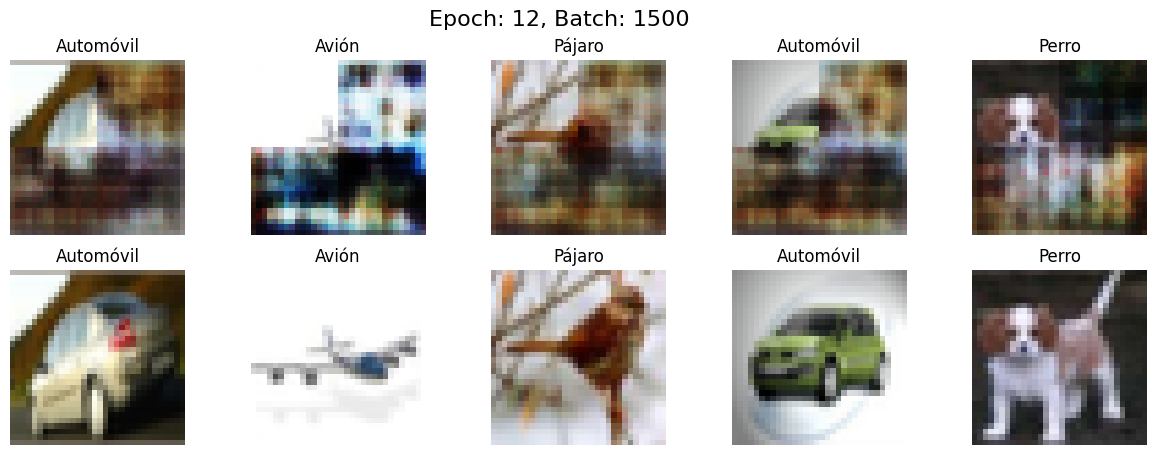

1550 [D loss: 0.1978,	 acc.: 98.44%]	[G loss: 0.1805]


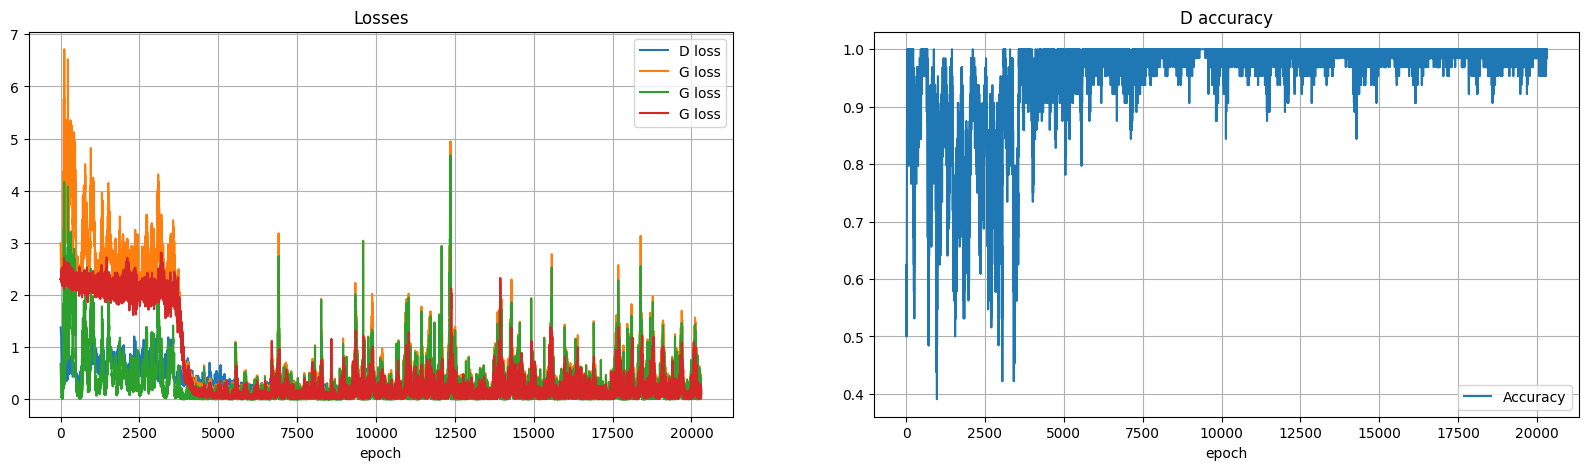

----EPOCH 13-----
0 [D loss: 0.1979,	 acc.: 96.88%]	[G loss: 0.1970]


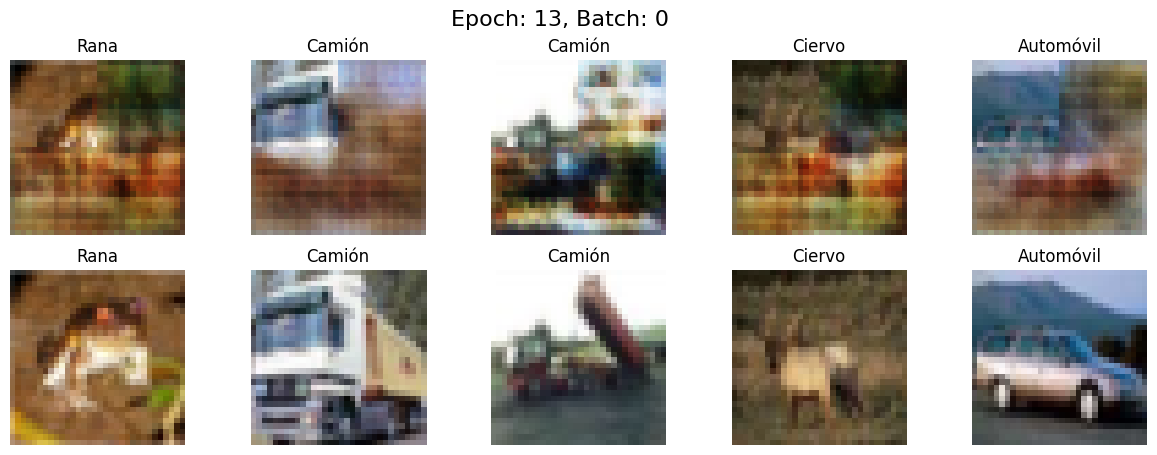

50 [D loss: 0.1186,	 acc.: 100.00%]	[G loss: 0.0681]
100 [D loss: 0.1440,	 acc.: 100.00%]	[G loss: 0.1329]
150 [D loss: 0.1267,	 acc.: 100.00%]	[G loss: 0.5232]
200 [D loss: 0.1017,	 acc.: 100.00%]	[G loss: 0.6585]
250 [D loss: 0.1417,	 acc.: 100.00%]	[G loss: 0.3002]
300 [D loss: 0.1140,	 acc.: 100.00%]	[G loss: 0.1458]
350 [D loss: 0.1157,	 acc.: 100.00%]	[G loss: 0.1218]
400 [D loss: 0.1370,	 acc.: 98.44%]	[G loss: 0.3758]
450 [D loss: 0.1687,	 acc.: 96.88%]	[G loss: 0.2455]
500 [D loss: 0.1424,	 acc.: 98.44%]	[G loss: 0.2542]


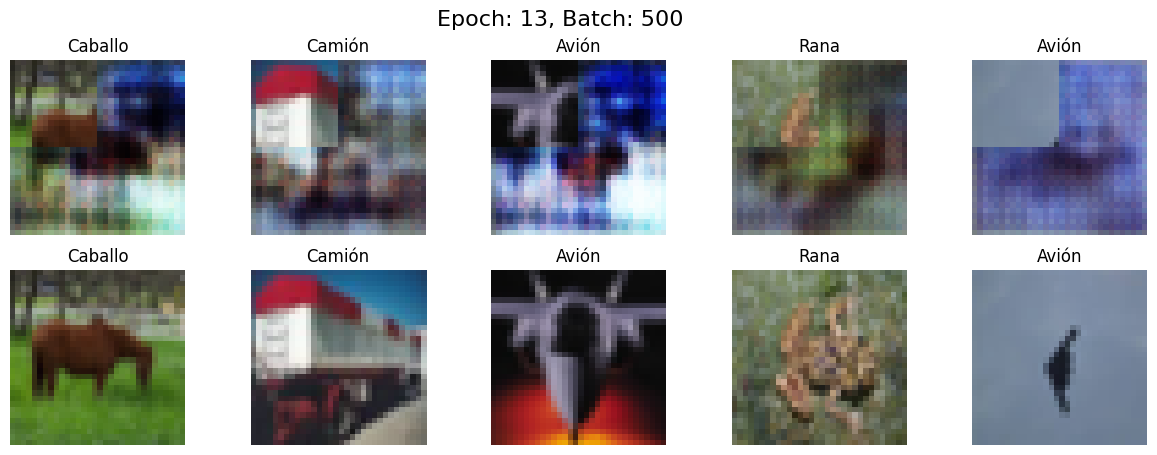

550 [D loss: 0.1401,	 acc.: 98.44%]	[G loss: 0.1398]
600 [D loss: 0.1411,	 acc.: 100.00%]	[G loss: 0.1453]
650 [D loss: 0.1323,	 acc.: 98.44%]	[G loss: 0.3316]
700 [D loss: 0.1305,	 acc.: 100.00%]	[G loss: 0.3228]
750 [D loss: 0.1123,	 acc.: 100.00%]	[G loss: 0.6012]
800 [D loss: 0.1902,	 acc.: 95.31%]	[G loss: 0.6251]
850 [D loss: 0.1151,	 acc.: 100.00%]	[G loss: 0.4944]
900 [D loss: 0.1036,	 acc.: 100.00%]	[G loss: 0.2679]
950 [D loss: 0.1497,	 acc.: 98.44%]	[G loss: 0.1144]
1000 [D loss: 0.1448,	 acc.: 100.00%]	[G loss: 0.1893]


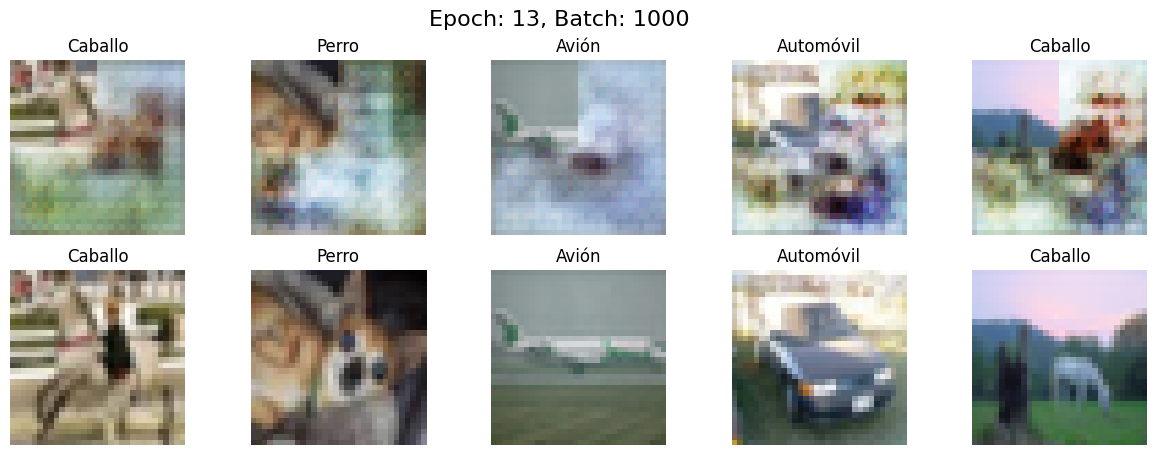

1050 [D loss: 0.1382,	 acc.: 100.00%]	[G loss: 0.2674]
1100 [D loss: 0.1317,	 acc.: 100.00%]	[G loss: 0.3309]
1150 [D loss: 0.1541,	 acc.: 100.00%]	[G loss: 0.9040]
1200 [D loss: 0.1872,	 acc.: 98.44%]	[G loss: 0.2015]
1250 [D loss: 0.1082,	 acc.: 100.00%]	[G loss: 0.1728]
1300 [D loss: 0.1172,	 acc.: 100.00%]	[G loss: 0.0788]
1350 [D loss: 0.1300,	 acc.: 100.00%]	[G loss: 0.3196]
1400 [D loss: 0.1335,	 acc.: 100.00%]	[G loss: 0.8846]
1450 [D loss: 0.1351,	 acc.: 100.00%]	[G loss: 0.7122]
1500 [D loss: 0.1587,	 acc.: 100.00%]	[G loss: 0.4443]


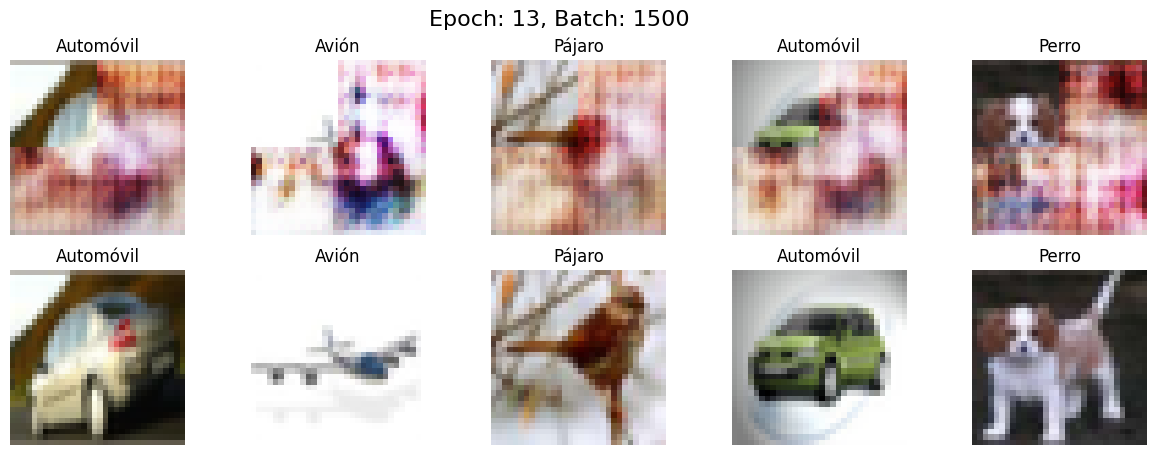

1550 [D loss: 0.1259,	 acc.: 100.00%]	[G loss: 0.1525]


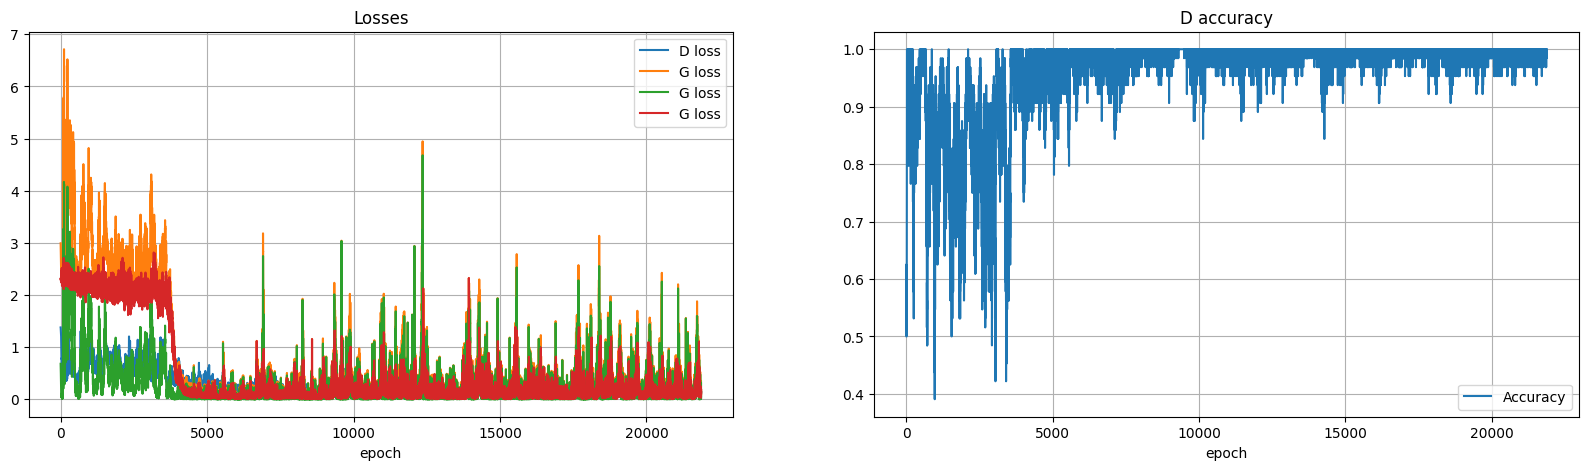

----EPOCH 14-----
0 [D loss: 0.1215,	 acc.: 100.00%]	[G loss: 0.1757]


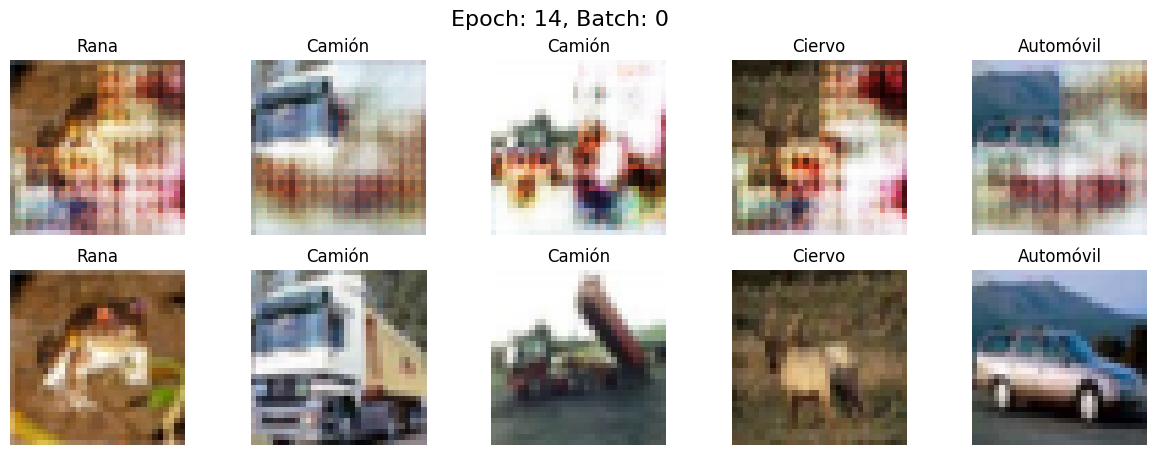

50 [D loss: 0.1068,	 acc.: 100.00%]	[G loss: 0.1433]
100 [D loss: 0.1343,	 acc.: 100.00%]	[G loss: 0.1734]
150 [D loss: 0.1574,	 acc.: 98.44%]	[G loss: 0.2382]
200 [D loss: 0.1142,	 acc.: 100.00%]	[G loss: 0.1585]
250 [D loss: 0.1227,	 acc.: 100.00%]	[G loss: 0.2614]
300 [D loss: 0.1374,	 acc.: 98.44%]	[G loss: 0.2701]
350 [D loss: 0.1135,	 acc.: 100.00%]	[G loss: 0.3901]
400 [D loss: 0.1124,	 acc.: 100.00%]	[G loss: 0.2464]
450 [D loss: 0.1522,	 acc.: 98.44%]	[G loss: 0.1078]
500 [D loss: 0.1420,	 acc.: 98.44%]	[G loss: 0.0898]


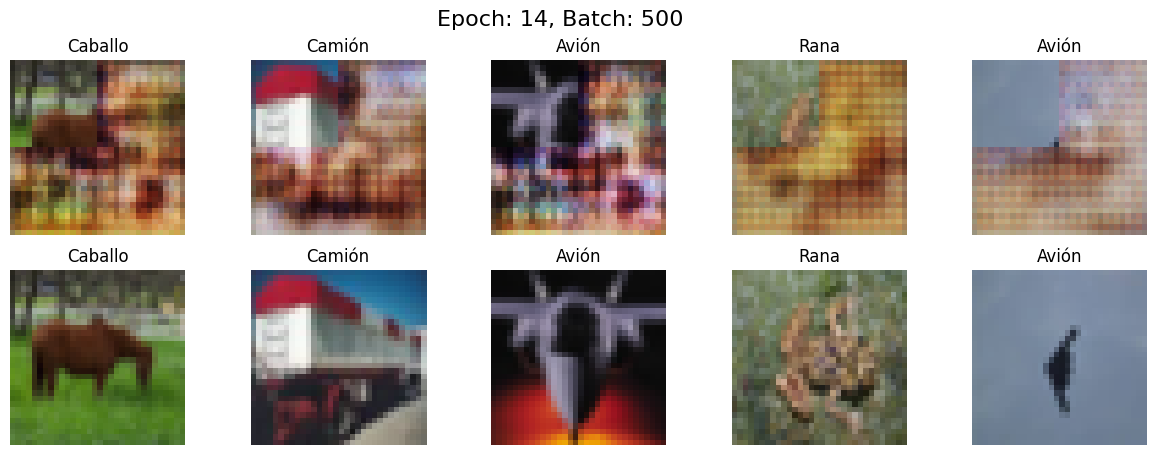

550 [D loss: 0.1139,	 acc.: 100.00%]	[G loss: 0.2163]
600 [D loss: 0.1371,	 acc.: 100.00%]	[G loss: 0.0982]
650 [D loss: 0.1271,	 acc.: 100.00%]	[G loss: 1.0015]
700 [D loss: 0.1146,	 acc.: 100.00%]	[G loss: 0.4457]
750 [D loss: 0.1133,	 acc.: 100.00%]	[G loss: 0.0572]
800 [D loss: 0.1286,	 acc.: 100.00%]	[G loss: 0.1247]
850 [D loss: 0.1497,	 acc.: 98.44%]	[G loss: 0.2156]
900 [D loss: 0.1315,	 acc.: 98.44%]	[G loss: 0.2115]
950 [D loss: 0.1847,	 acc.: 95.31%]	[G loss: 0.2991]
1000 [D loss: 0.1631,	 acc.: 98.44%]	[G loss: 0.3450]


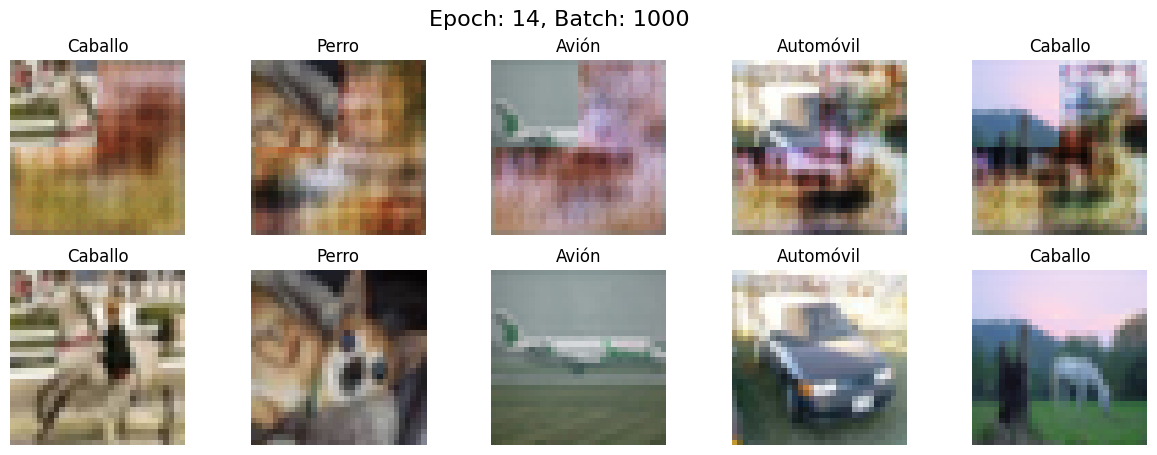

1050 [D loss: 0.1455,	 acc.: 100.00%]	[G loss: 0.4415]
1100 [D loss: 0.1712,	 acc.: 98.44%]	[G loss: 0.3458]
1150 [D loss: 0.1480,	 acc.: 98.44%]	[G loss: 0.3195]
1200 [D loss: 0.1794,	 acc.: 98.44%]	[G loss: 0.2447]
1250 [D loss: 0.1144,	 acc.: 100.00%]	[G loss: 0.0554]
1300 [D loss: 0.1096,	 acc.: 100.00%]	[G loss: 0.0718]
1350 [D loss: 0.1385,	 acc.: 100.00%]	[G loss: 0.1205]
1400 [D loss: 0.1933,	 acc.: 98.44%]	[G loss: 0.4391]
1450 [D loss: 0.1200,	 acc.: 100.00%]	[G loss: 0.4422]
1500 [D loss: 0.1462,	 acc.: 100.00%]	[G loss: 0.7126]


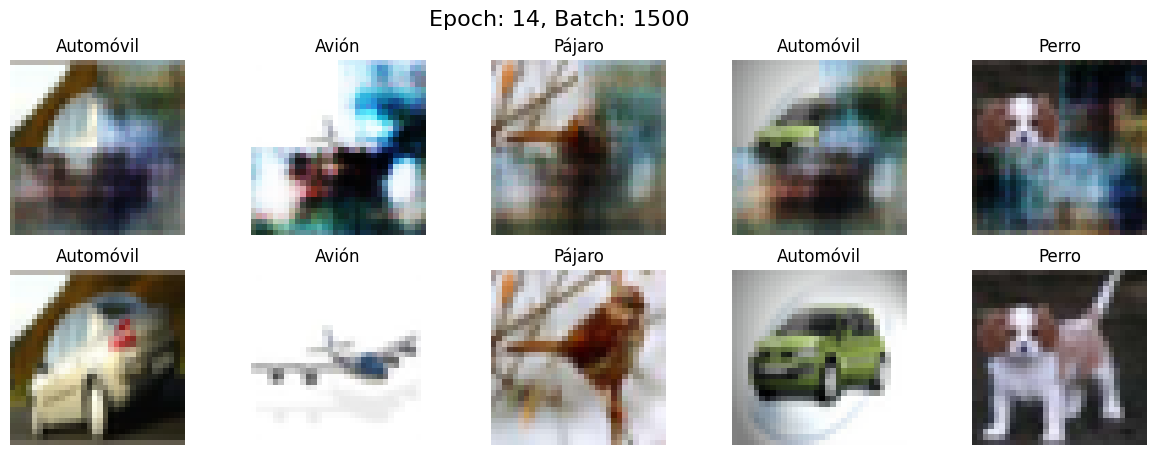

1550 [D loss: 0.1277,	 acc.: 100.00%]	[G loss: 0.1231]


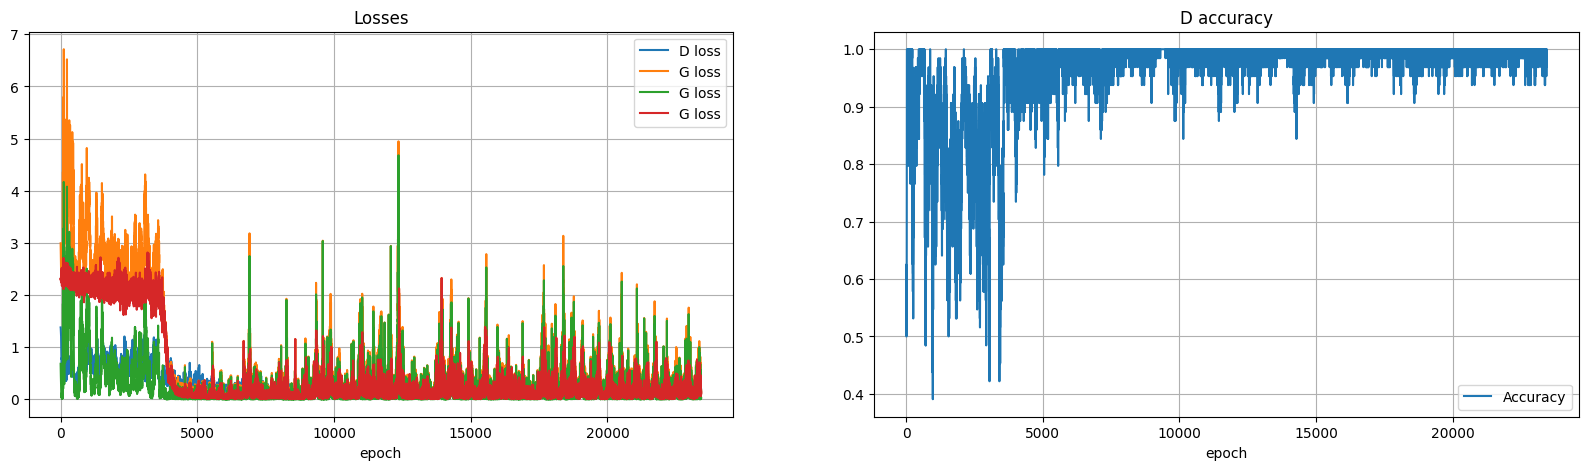

----EPOCH 15-----
0 [D loss: 0.1405,	 acc.: 100.00%]	[G loss: 0.1037]


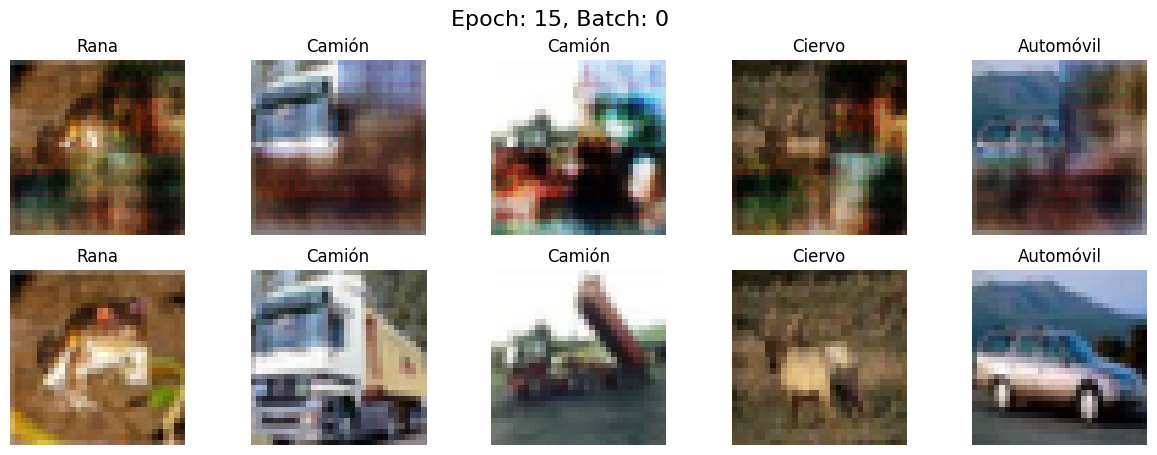

50 [D loss: 0.1517,	 acc.: 98.44%]	[G loss: 0.1203]
100 [D loss: 0.1696,	 acc.: 98.44%]	[G loss: 0.1662]
150 [D loss: 0.1288,	 acc.: 100.00%]	[G loss: 0.1272]
200 [D loss: 0.1046,	 acc.: 100.00%]	[G loss: 0.2333]
250 [D loss: 0.1313,	 acc.: 100.00%]	[G loss: 0.2549]
300 [D loss: 0.1231,	 acc.: 100.00%]	[G loss: 0.1877]
350 [D loss: 0.1134,	 acc.: 100.00%]	[G loss: 0.3620]
400 [D loss: 0.1393,	 acc.: 98.44%]	[G loss: 0.5070]
450 [D loss: 0.1826,	 acc.: 98.44%]	[G loss: 0.0762]
500 [D loss: 0.1335,	 acc.: 98.44%]	[G loss: 0.1405]


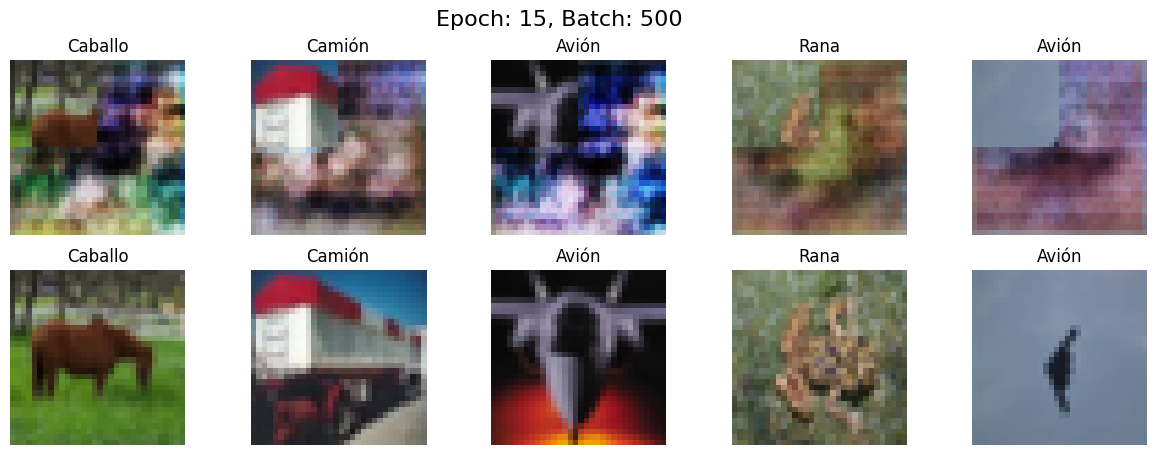

550 [D loss: 0.1169,	 acc.: 100.00%]	[G loss: 0.6340]
600 [D loss: 0.1395,	 acc.: 100.00%]	[G loss: 1.1079]
650 [D loss: 0.1161,	 acc.: 100.00%]	[G loss: 0.8237]
700 [D loss: 0.1718,	 acc.: 96.88%]	[G loss: 0.2860]
750 [D loss: 0.1012,	 acc.: 100.00%]	[G loss: 0.0857]
800 [D loss: 0.1171,	 acc.: 100.00%]	[G loss: 0.4650]
850 [D loss: 0.1284,	 acc.: 100.00%]	[G loss: 0.0336]
900 [D loss: 0.1029,	 acc.: 100.00%]	[G loss: 0.0979]
950 [D loss: 0.1533,	 acc.: 98.44%]	[G loss: 0.1769]
1000 [D loss: 0.1192,	 acc.: 100.00%]	[G loss: 0.1552]


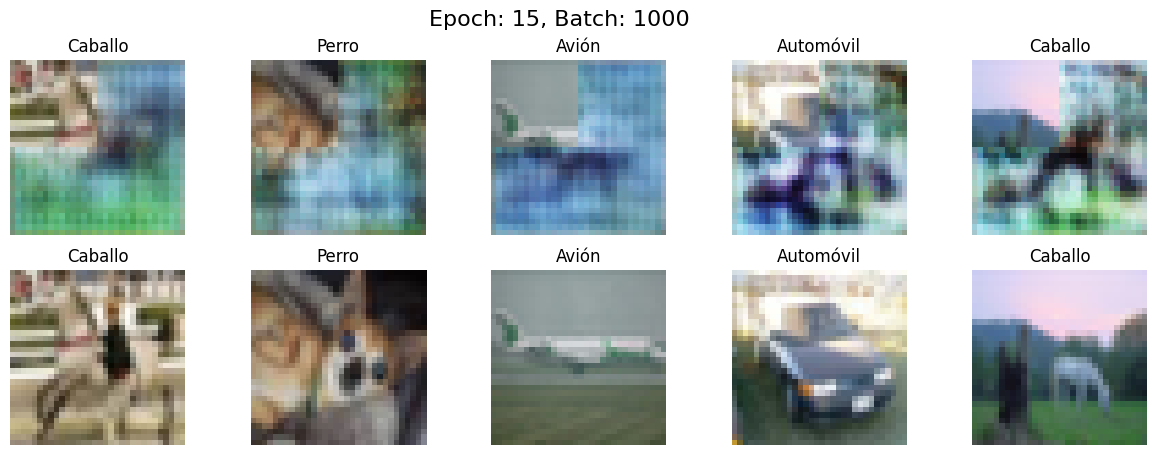

1050 [D loss: 0.1087,	 acc.: 100.00%]	[G loss: 0.1432]
1100 [D loss: 0.1344,	 acc.: 100.00%]	[G loss: 0.0976]
1150 [D loss: 0.1338,	 acc.: 100.00%]	[G loss: 0.5278]
1200 [D loss: 0.1280,	 acc.: 100.00%]	[G loss: 0.2355]
1250 [D loss: 0.1306,	 acc.: 98.44%]	[G loss: 0.0903]
1300 [D loss: 0.1696,	 acc.: 95.31%]	[G loss: 0.1298]
1350 [D loss: 0.1475,	 acc.: 100.00%]	[G loss: 0.1778]
1400 [D loss: 0.1198,	 acc.: 100.00%]	[G loss: 0.1866]
1450 [D loss: 0.1023,	 acc.: 100.00%]	[G loss: 0.3392]
1500 [D loss: 0.1620,	 acc.: 100.00%]	[G loss: 0.3997]


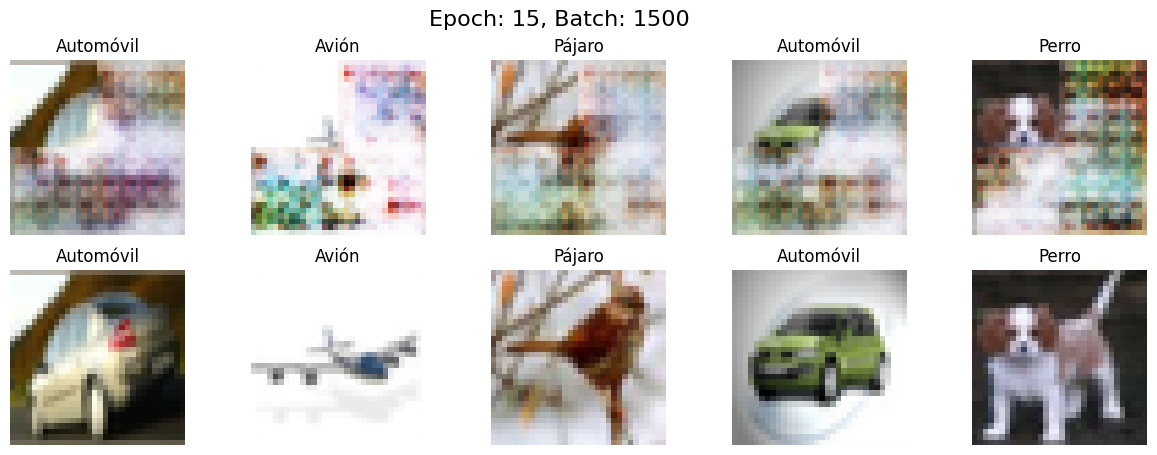

1550 [D loss: 0.1136,	 acc.: 100.00%]	[G loss: 0.3521]


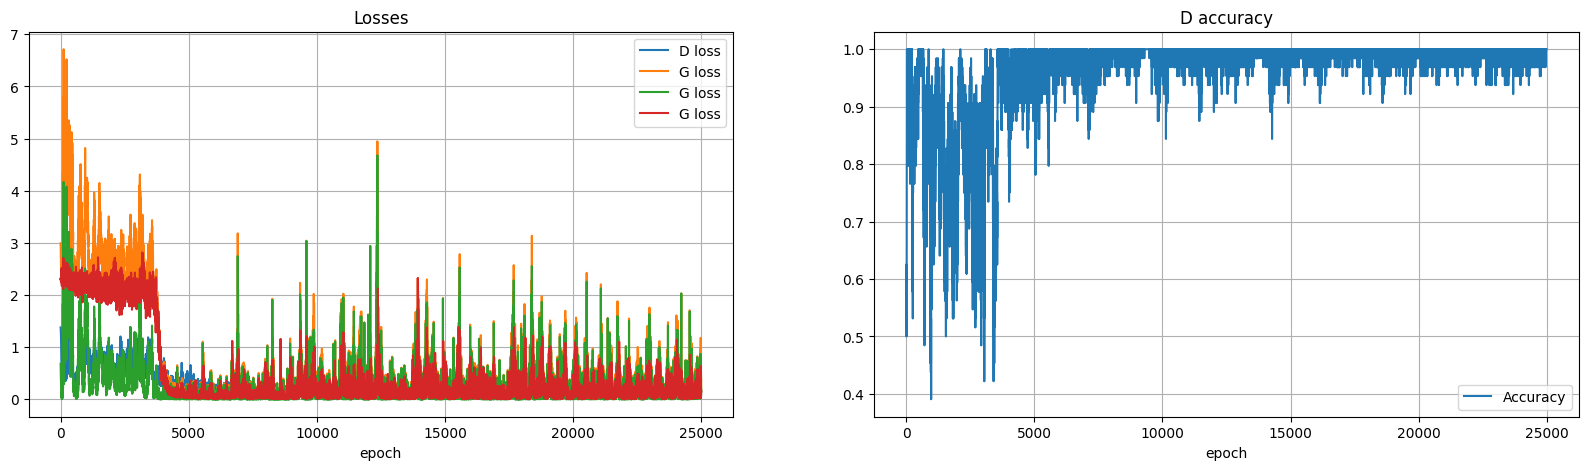

----EPOCH 16-----
0 [D loss: 0.1309,	 acc.: 100.00%]	[G loss: 0.4799]


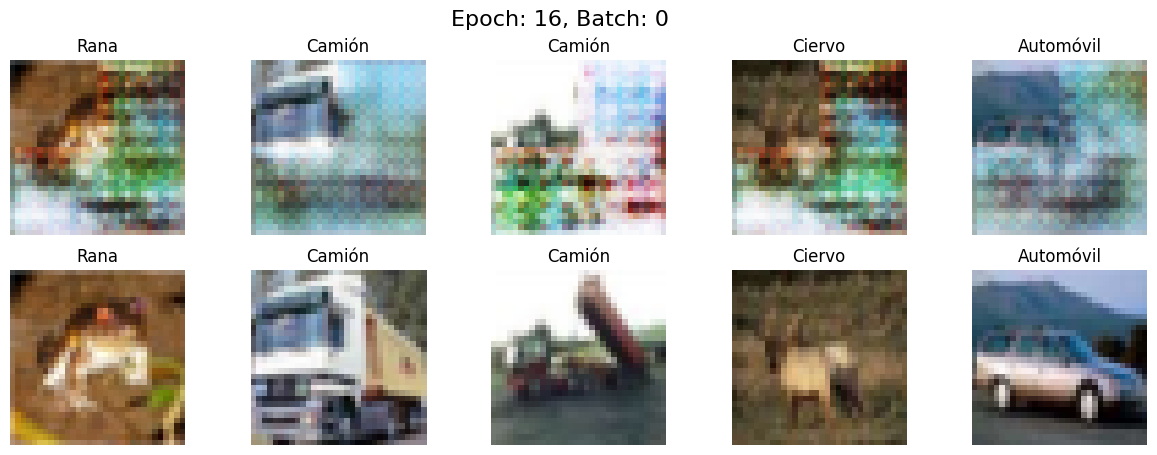

50 [D loss: 0.1093,	 acc.: 100.00%]	[G loss: 1.3356]
100 [D loss: 0.1422,	 acc.: 100.00%]	[G loss: 0.8679]
150 [D loss: 0.1386,	 acc.: 100.00%]	[G loss: 0.5098]
200 [D loss: 0.1191,	 acc.: 100.00%]	[G loss: 0.5859]
250 [D loss: 0.1402,	 acc.: 98.44%]	[G loss: 0.6364]
300 [D loss: 0.1307,	 acc.: 100.00%]	[G loss: 0.0400]
350 [D loss: 0.1205,	 acc.: 100.00%]	[G loss: 0.1094]
400 [D loss: 0.1582,	 acc.: 96.88%]	[G loss: 0.2475]
450 [D loss: 0.1275,	 acc.: 100.00%]	[G loss: 0.6539]
500 [D loss: 0.1358,	 acc.: 100.00%]	[G loss: 0.2260]


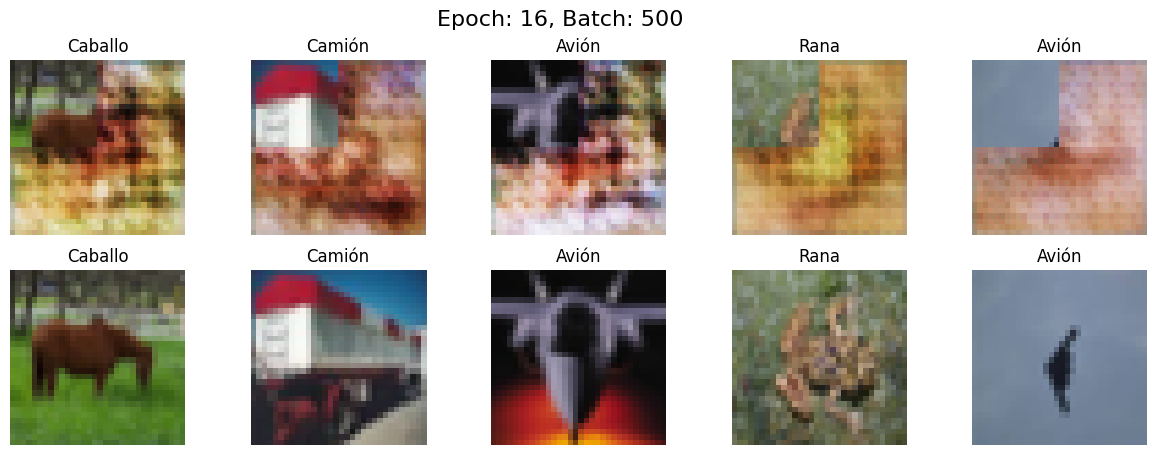

550 [D loss: 0.1238,	 acc.: 100.00%]	[G loss: 0.3744]
600 [D loss: 0.1460,	 acc.: 100.00%]	[G loss: 0.2918]
650 [D loss: 0.1586,	 acc.: 98.44%]	[G loss: 0.1455]
700 [D loss: 0.1340,	 acc.: 100.00%]	[G loss: 0.1722]
750 [D loss: 0.1296,	 acc.: 98.44%]	[G loss: 0.0569]
800 [D loss: 0.1064,	 acc.: 100.00%]	[G loss: 0.1284]
850 [D loss: 0.1247,	 acc.: 100.00%]	[G loss: 0.3200]
900 [D loss: 0.0985,	 acc.: 100.00%]	[G loss: 0.4798]
950 [D loss: 0.2537,	 acc.: 95.31%]	[G loss: 0.5112]
1000 [D loss: 0.1253,	 acc.: 100.00%]	[G loss: 0.4030]


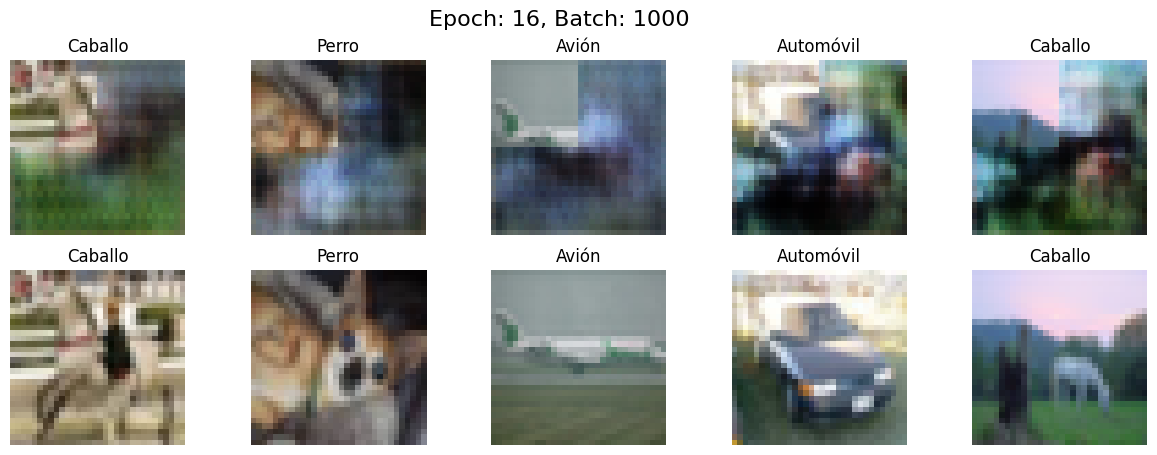

1050 [D loss: 0.1390,	 acc.: 98.44%]	[G loss: 0.2506]
1100 [D loss: 0.1271,	 acc.: 100.00%]	[G loss: 0.1405]
1150 [D loss: 0.1347,	 acc.: 100.00%]	[G loss: 0.0856]
1200 [D loss: 0.1541,	 acc.: 98.44%]	[G loss: 0.1089]
1250 [D loss: 0.1548,	 acc.: 98.44%]	[G loss: 0.3109]
1300 [D loss: 0.1080,	 acc.: 100.00%]	[G loss: 0.4966]
1350 [D loss: 0.1325,	 acc.: 100.00%]	[G loss: 0.2402]
1400 [D loss: 0.1146,	 acc.: 100.00%]	[G loss: 0.1851]
1450 [D loss: 0.1222,	 acc.: 100.00%]	[G loss: 0.1953]
1500 [D loss: 0.1508,	 acc.: 100.00%]	[G loss: 0.2614]


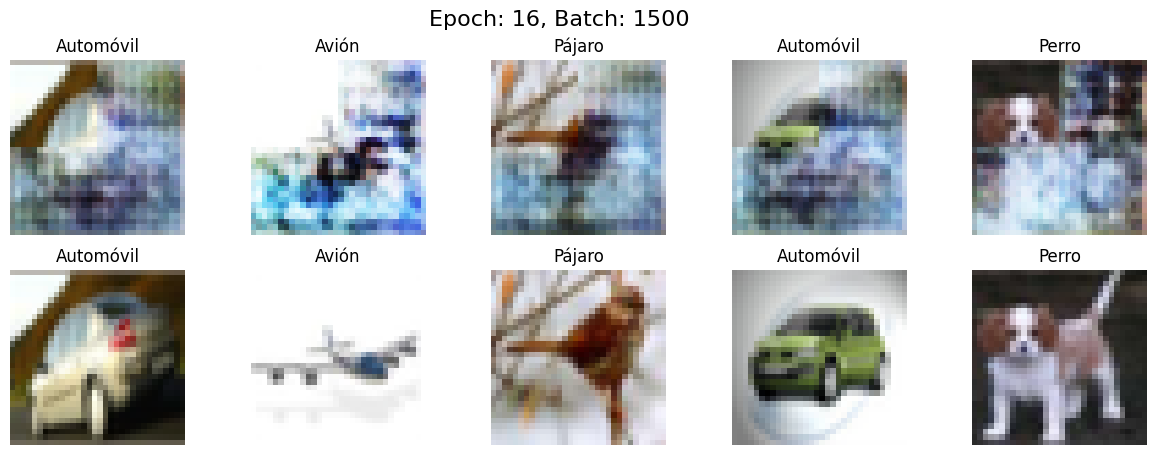

1550 [D loss: 0.1159,	 acc.: 100.00%]	[G loss: 0.1055]


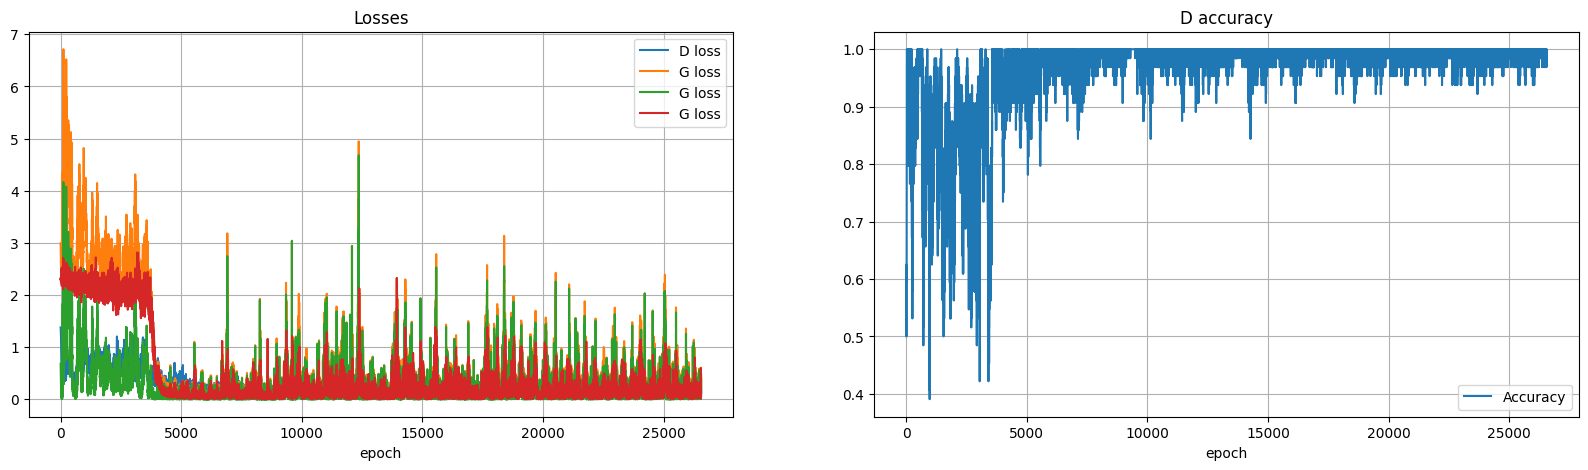

----EPOCH 17-----
0 [D loss: 0.1787,	 acc.: 96.88%]	[G loss: 0.8133]


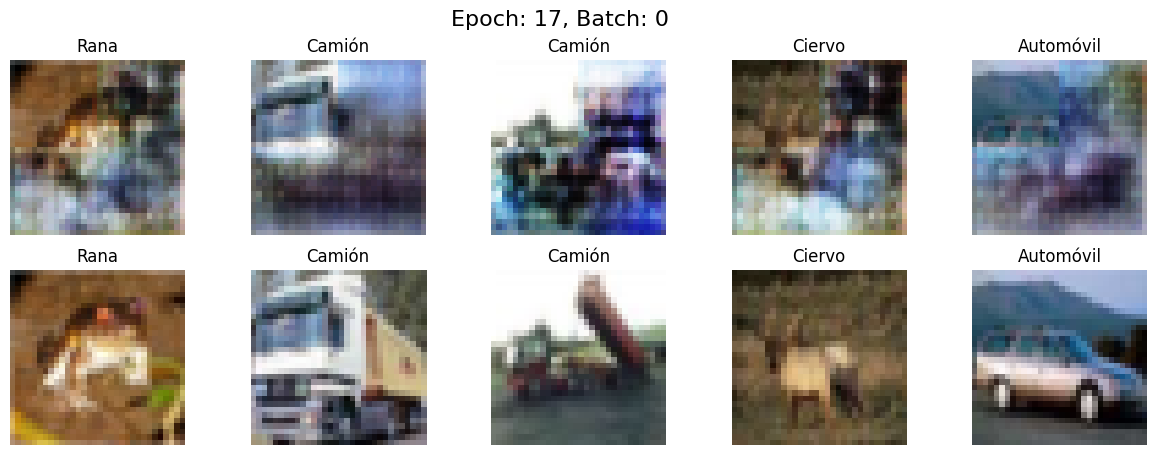

50 [D loss: 0.1992,	 acc.: 98.44%]	[G loss: 0.2973]
100 [D loss: 0.1337,	 acc.: 100.00%]	[G loss: 0.1290]
150 [D loss: 0.1225,	 acc.: 100.00%]	[G loss: 0.3091]
200 [D loss: 0.1700,	 acc.: 95.31%]	[G loss: 0.2770]
250 [D loss: 0.1229,	 acc.: 100.00%]	[G loss: 0.6494]
300 [D loss: 0.1143,	 acc.: 100.00%]	[G loss: 0.8321]
350 [D loss: 0.1512,	 acc.: 98.44%]	[G loss: 0.0763]
400 [D loss: 0.1143,	 acc.: 100.00%]	[G loss: 0.1578]
450 [D loss: 0.1278,	 acc.: 100.00%]	[G loss: 0.0366]
500 [D loss: 0.1644,	 acc.: 98.44%]	[G loss: 0.1309]


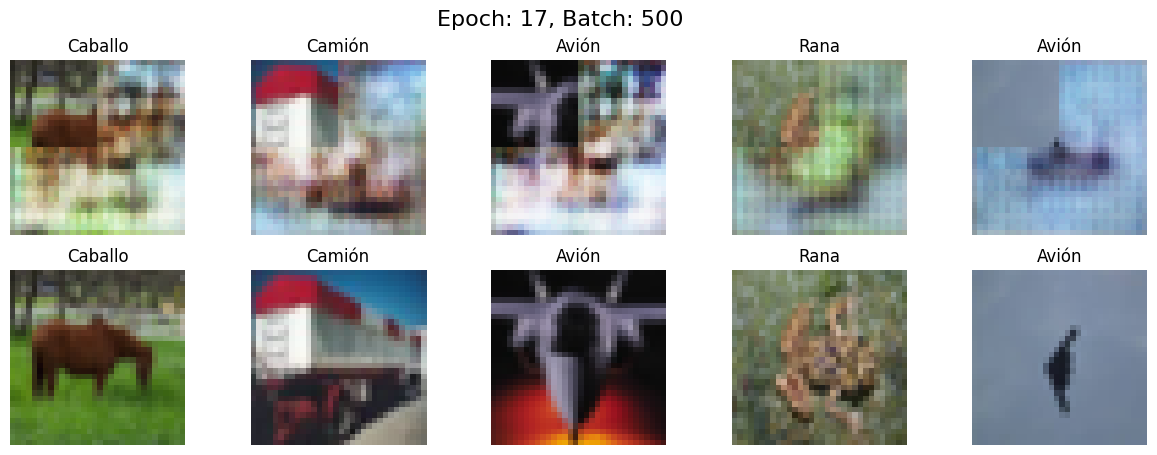

550 [D loss: 0.1434,	 acc.: 98.44%]	[G loss: 0.1245]
600 [D loss: 0.1492,	 acc.: 98.44%]	[G loss: 0.1639]
650 [D loss: 0.1042,	 acc.: 100.00%]	[G loss: 0.5221]
700 [D loss: 0.1161,	 acc.: 100.00%]	[G loss: 0.4214]
750 [D loss: 0.1063,	 acc.: 100.00%]	[G loss: 0.0813]
800 [D loss: 0.1959,	 acc.: 96.88%]	[G loss: 0.2843]
850 [D loss: 0.1361,	 acc.: 98.44%]	[G loss: 0.1118]
900 [D loss: 0.0983,	 acc.: 100.00%]	[G loss: 0.1074]
950 [D loss: 0.1255,	 acc.: 100.00%]	[G loss: 0.9930]
1000 [D loss: 0.1413,	 acc.: 98.44%]	[G loss: 0.2722]


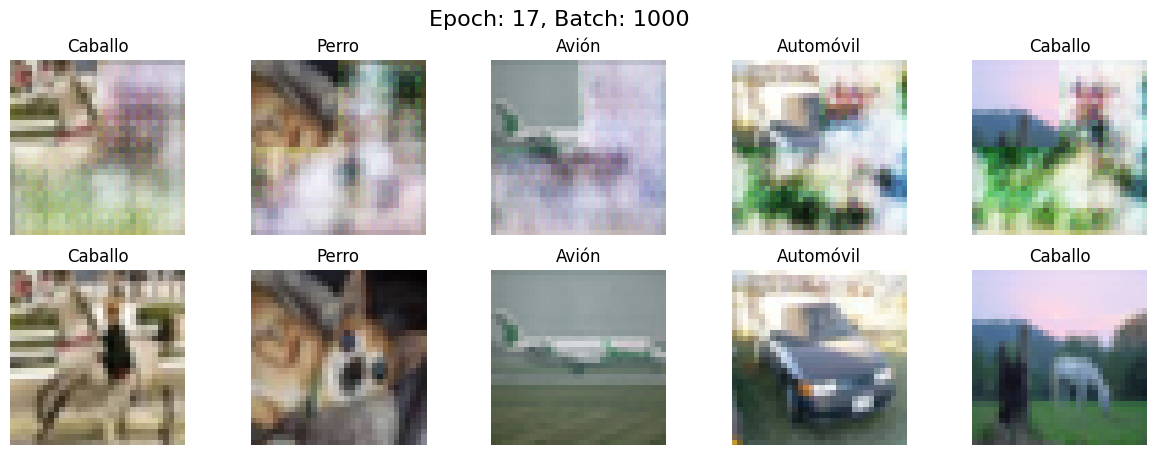

1050 [D loss: 0.2115,	 acc.: 96.88%]	[G loss: 0.5003]
1100 [D loss: 0.1167,	 acc.: 100.00%]	[G loss: 0.2805]
1150 [D loss: 0.1109,	 acc.: 100.00%]	[G loss: 0.3117]
1200 [D loss: 0.3449,	 acc.: 96.88%]	[G loss: 0.2870]
1250 [D loss: 0.1109,	 acc.: 100.00%]	[G loss: 0.1164]
1300 [D loss: 0.1376,	 acc.: 96.88%]	[G loss: 0.1493]
1350 [D loss: 0.1258,	 acc.: 100.00%]	[G loss: 0.1632]
1400 [D loss: 0.1144,	 acc.: 100.00%]	[G loss: 0.1159]
1450 [D loss: 0.1210,	 acc.: 100.00%]	[G loss: 0.2418]
1500 [D loss: 0.1474,	 acc.: 100.00%]	[G loss: 0.2296]


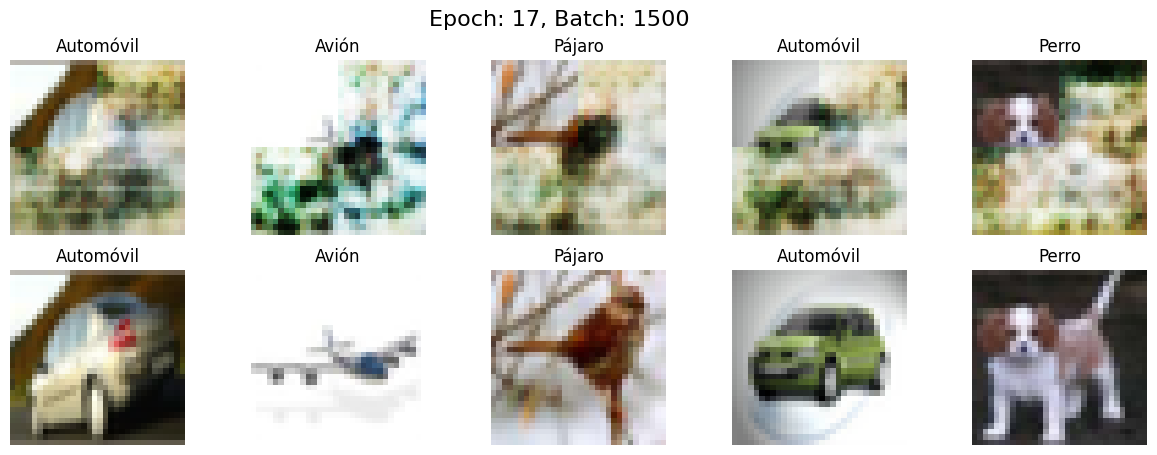

1550 [D loss: 0.1160,	 acc.: 100.00%]	[G loss: 0.1333]


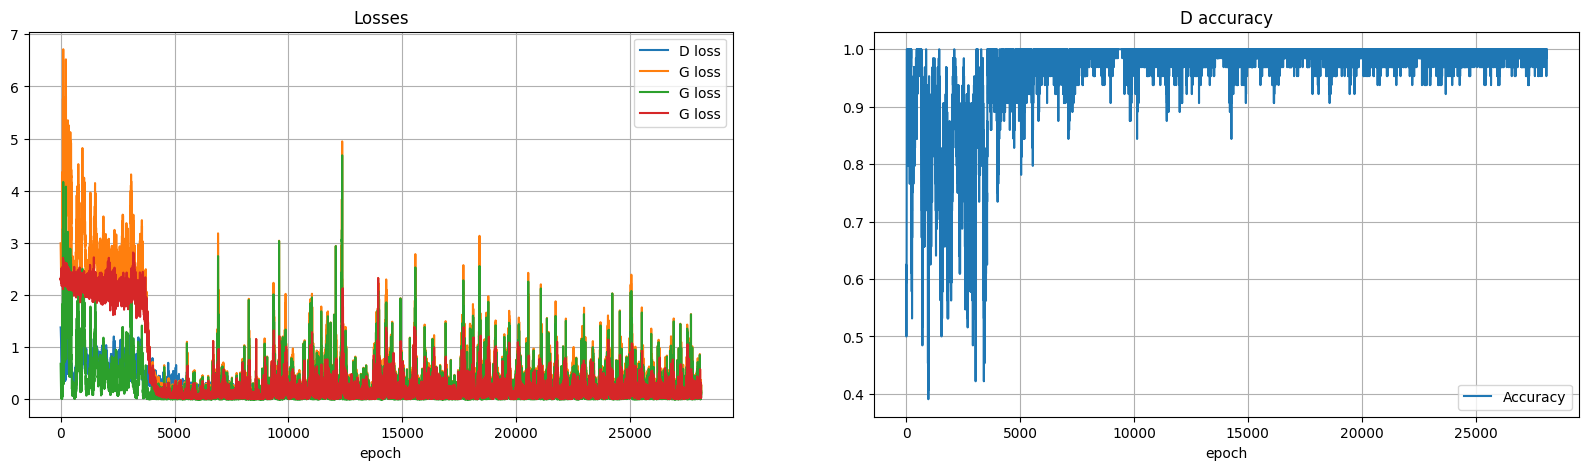

----EPOCH 18-----
0 [D loss: 0.1936,	 acc.: 98.44%]	[G loss: 0.2148]


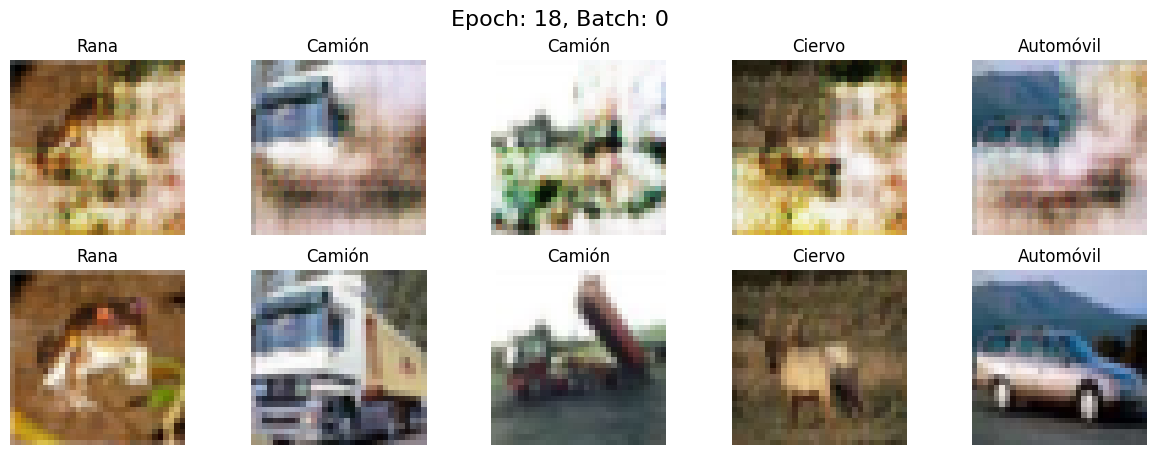

50 [D loss: 0.1112,	 acc.: 100.00%]	[G loss: 0.2146]
100 [D loss: 0.1428,	 acc.: 100.00%]	[G loss: 0.2287]
150 [D loss: 0.1101,	 acc.: 100.00%]	[G loss: 0.1626]
200 [D loss: 0.1105,	 acc.: 98.44%]	[G loss: 0.1208]
250 [D loss: 0.1041,	 acc.: 100.00%]	[G loss: 0.1108]
300 [D loss: 0.1080,	 acc.: 100.00%]	[G loss: 0.3109]
350 [D loss: 0.1018,	 acc.: 100.00%]	[G loss: 0.5081]
400 [D loss: 0.1135,	 acc.: 100.00%]	[G loss: 0.8879]
450 [D loss: 0.1291,	 acc.: 100.00%]	[G loss: 0.4236]
500 [D loss: 0.1157,	 acc.: 100.00%]	[G loss: 0.1748]


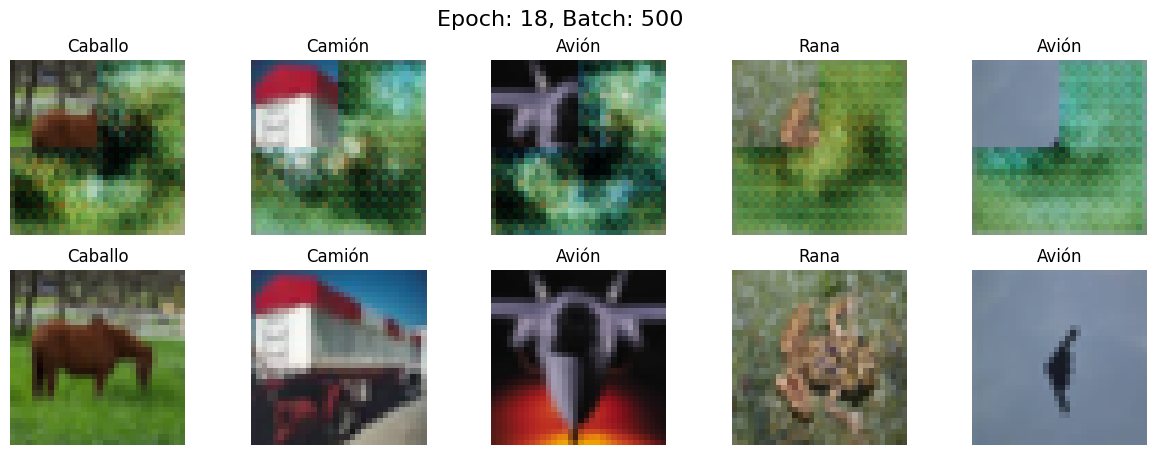

550 [D loss: 0.1217,	 acc.: 100.00%]	[G loss: 0.1357]
600 [D loss: 0.1717,	 acc.: 98.44%]	[G loss: 0.0228]
650 [D loss: 0.1026,	 acc.: 100.00%]	[G loss: 0.1437]
700 [D loss: 0.1102,	 acc.: 100.00%]	[G loss: 0.1038]
750 [D loss: 0.0974,	 acc.: 100.00%]	[G loss: 0.1696]
800 [D loss: 0.1099,	 acc.: 100.00%]	[G loss: 0.1795]
850 [D loss: 0.1146,	 acc.: 100.00%]	[G loss: 0.3746]
900 [D loss: 0.1444,	 acc.: 98.44%]	[G loss: 0.5431]
950 [D loss: 0.1501,	 acc.: 98.44%]	[G loss: 0.2903]
1000 [D loss: 0.1175,	 acc.: 100.00%]	[G loss: 0.1676]


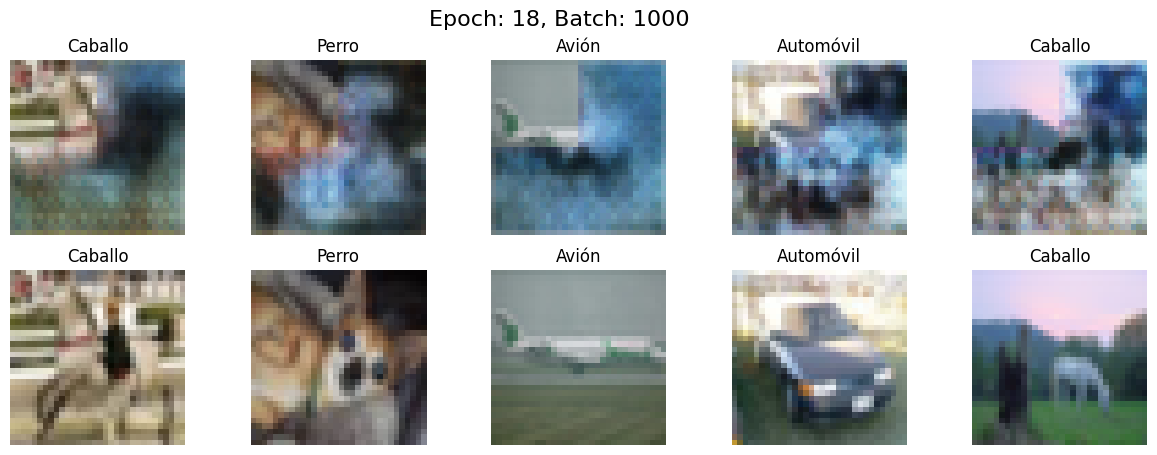

1050 [D loss: 0.1404,	 acc.: 98.44%]	[G loss: 0.2774]
1100 [D loss: 0.1118,	 acc.: 100.00%]	[G loss: 0.2379]
1150 [D loss: 0.1156,	 acc.: 100.00%]	[G loss: 0.1083]
1200 [D loss: 0.1175,	 acc.: 100.00%]	[G loss: 0.0993]
1250 [D loss: 0.1012,	 acc.: 100.00%]	[G loss: 0.2642]
1300 [D loss: 0.0951,	 acc.: 100.00%]	[G loss: 0.2915]
1350 [D loss: 0.1196,	 acc.: 100.00%]	[G loss: 0.1715]
1400 [D loss: 0.1094,	 acc.: 100.00%]	[G loss: 0.1505]
1450 [D loss: 0.1495,	 acc.: 98.44%]	[G loss: 0.4079]
1500 [D loss: 0.1495,	 acc.: 100.00%]	[G loss: 0.6349]


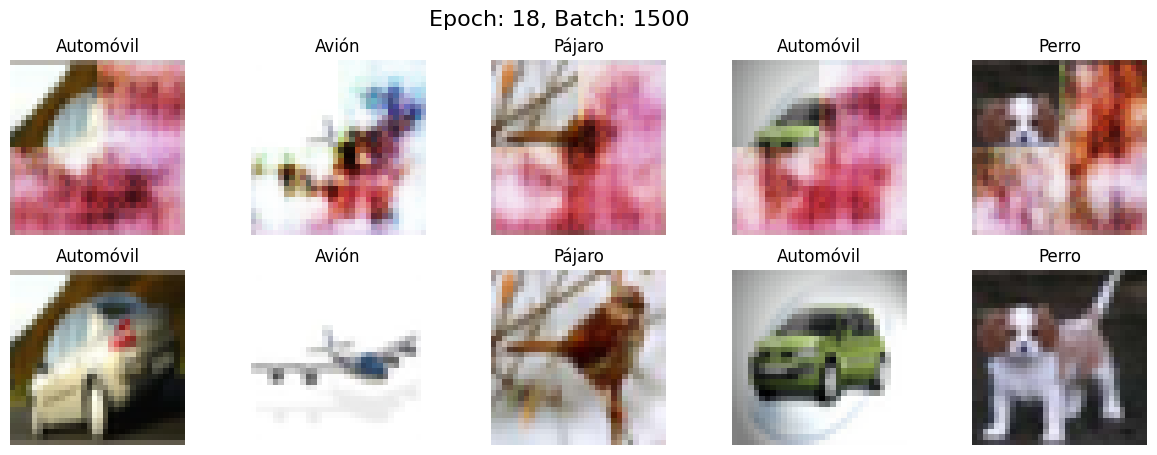

1550 [D loss: 0.1031,	 acc.: 100.00%]	[G loss: 0.2002]


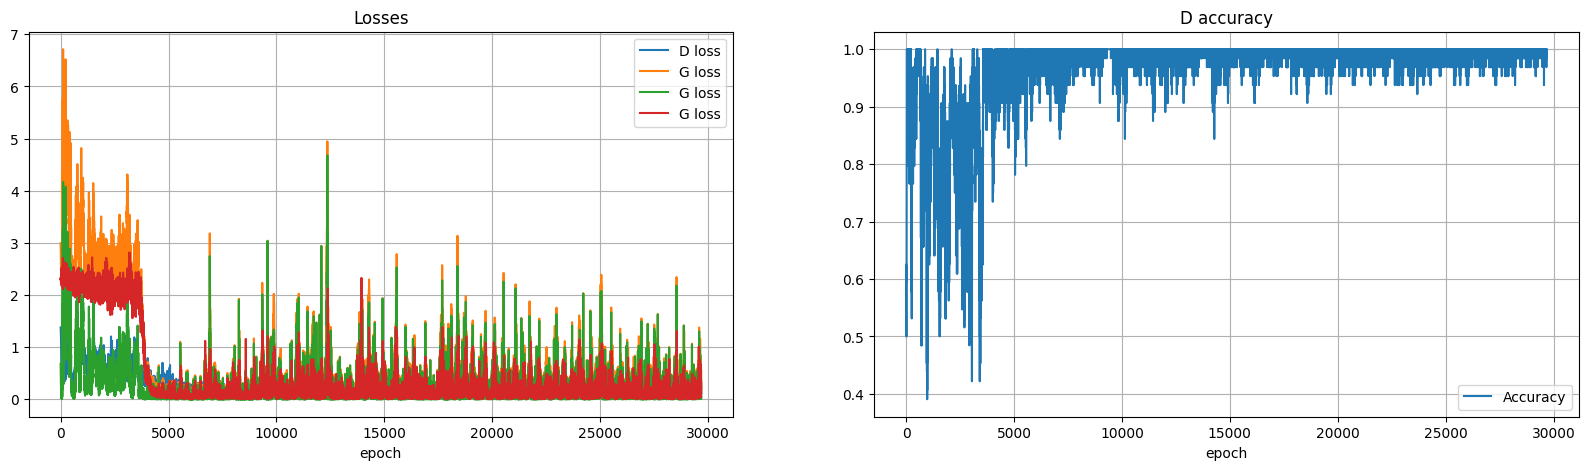

----EPOCH 19-----
0 [D loss: 0.1229,	 acc.: 100.00%]	[G loss: 0.4807]


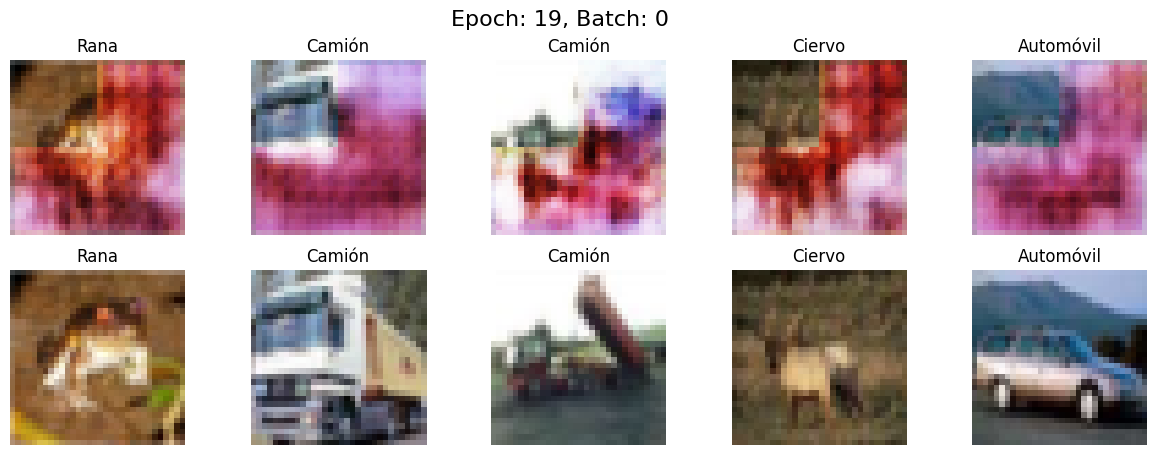

50 [D loss: 0.0926,	 acc.: 100.00%]	[G loss: 0.1361]
100 [D loss: 0.1152,	 acc.: 100.00%]	[G loss: 0.0601]
150 [D loss: 0.1094,	 acc.: 100.00%]	[G loss: 0.0353]
200 [D loss: 0.1415,	 acc.: 100.00%]	[G loss: 0.0819]
250 [D loss: 0.1048,	 acc.: 100.00%]	[G loss: 0.1037]
300 [D loss: 0.1112,	 acc.: 100.00%]	[G loss: 0.3452]
350 [D loss: 0.1043,	 acc.: 100.00%]	[G loss: 0.4974]
400 [D loss: 0.1027,	 acc.: 100.00%]	[G loss: 2.1503]
450 [D loss: 0.1612,	 acc.: 98.44%]	[G loss: 0.2815]
500 [D loss: 0.1114,	 acc.: 100.00%]	[G loss: 0.3199]


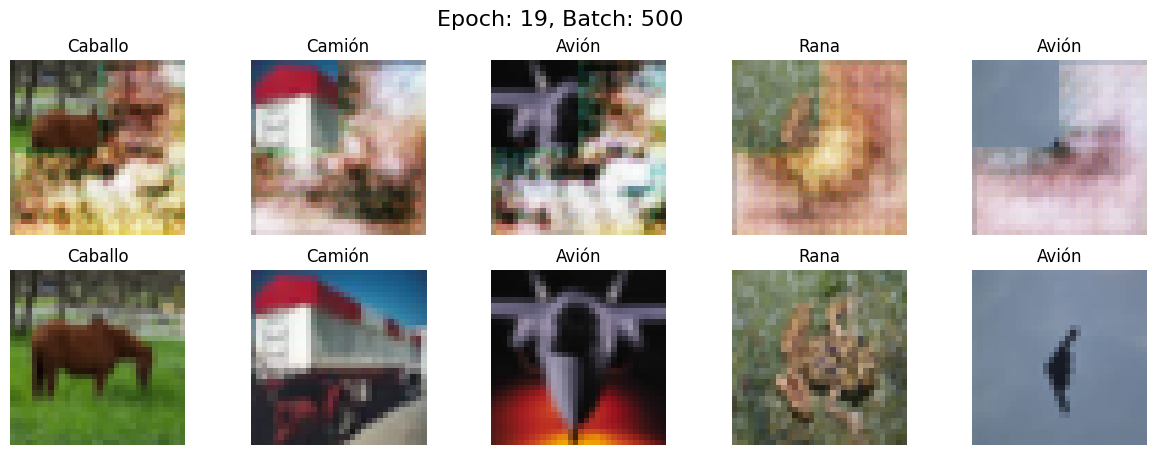

550 [D loss: 0.1090,	 acc.: 100.00%]	[G loss: 0.3728]
600 [D loss: 0.1202,	 acc.: 100.00%]	[G loss: 0.1899]
650 [D loss: 0.1094,	 acc.: 100.00%]	[G loss: 0.2179]
700 [D loss: 0.1318,	 acc.: 98.44%]	[G loss: 0.0810]
750 [D loss: 0.1025,	 acc.: 100.00%]	[G loss: 0.0701]
800 [D loss: 0.0932,	 acc.: 100.00%]	[G loss: 0.2177]
850 [D loss: 0.1158,	 acc.: 100.00%]	[G loss: 0.2087]
900 [D loss: 0.1580,	 acc.: 98.44%]	[G loss: 0.5993]
950 [D loss: 0.2515,	 acc.: 92.19%]	[G loss: 0.2963]
1000 [D loss: 0.1208,	 acc.: 100.00%]	[G loss: 0.1669]


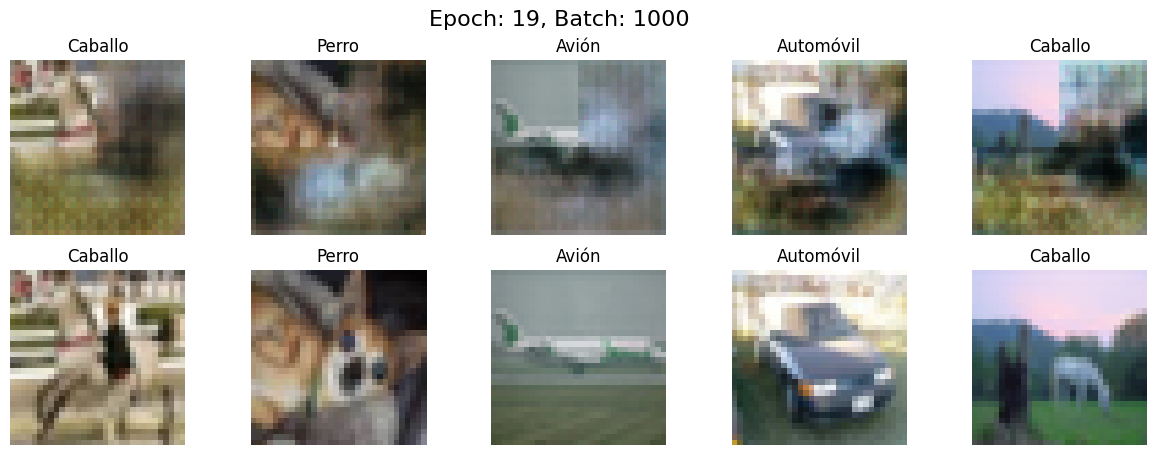

1050 [D loss: 0.1350,	 acc.: 100.00%]	[G loss: 0.1187]
1100 [D loss: 0.1953,	 acc.: 96.88%]	[G loss: 0.3617]
1150 [D loss: 0.1246,	 acc.: 100.00%]	[G loss: 0.2749]
1200 [D loss: 0.1199,	 acc.: 100.00%]	[G loss: 0.4655]
1250 [D loss: 0.1062,	 acc.: 100.00%]	[G loss: 0.3486]
1300 [D loss: 0.1328,	 acc.: 100.00%]	[G loss: 0.1553]
1350 [D loss: 0.1262,	 acc.: 100.00%]	[G loss: 0.3681]
1400 [D loss: 0.1304,	 acc.: 100.00%]	[G loss: 0.1537]
1450 [D loss: 0.1065,	 acc.: 100.00%]	[G loss: 0.0568]
1500 [D loss: 0.1819,	 acc.: 98.44%]	[G loss: 0.2597]


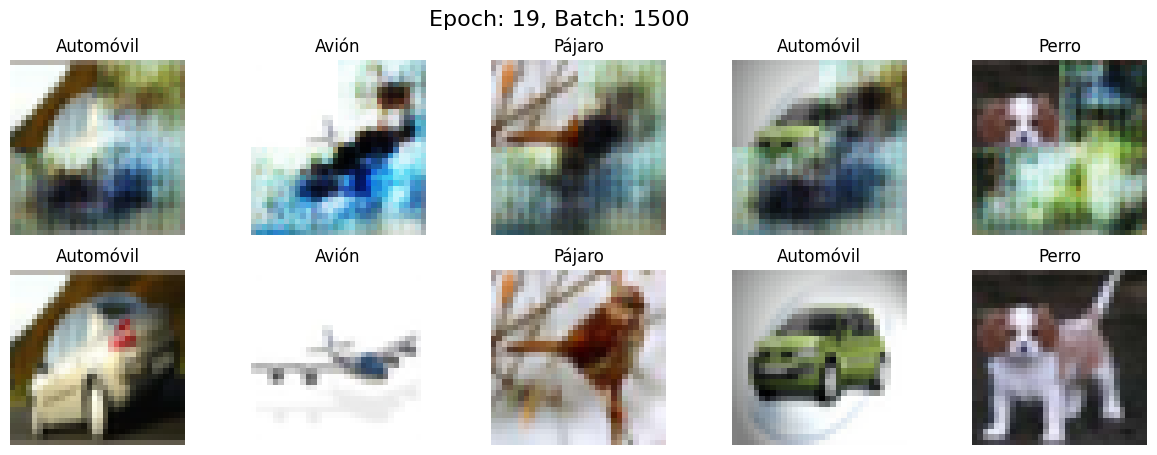

1550 [D loss: 0.0966,	 acc.: 100.00%]	[G loss: 0.1865]


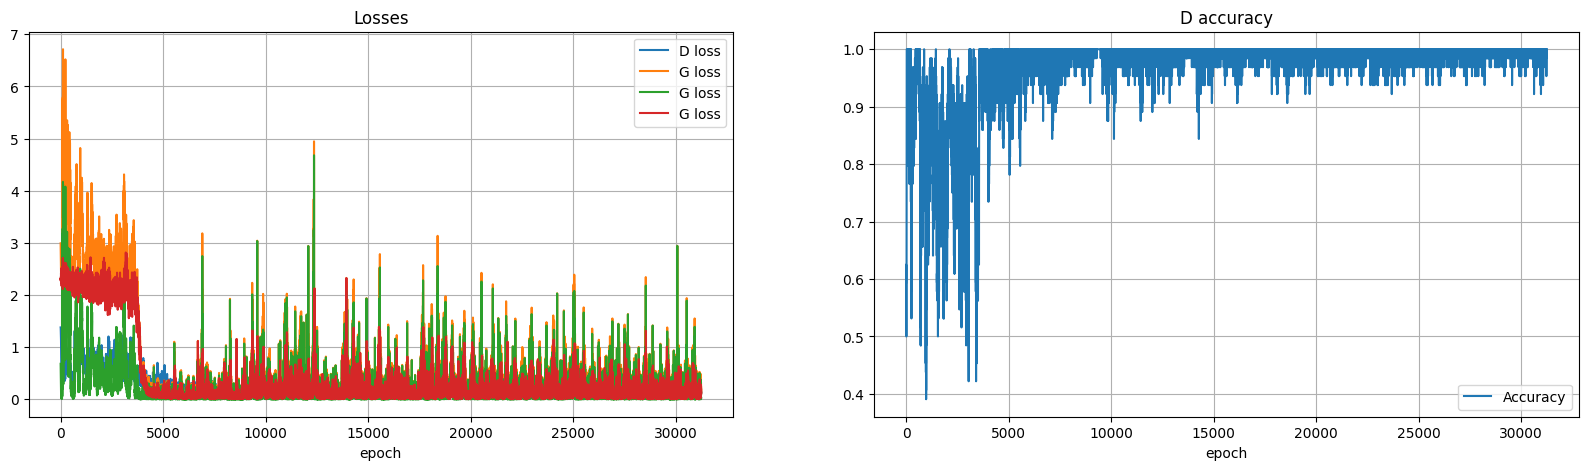

----EPOCH 20-----
0 [D loss: 0.1143,	 acc.: 100.00%]	[G loss: 0.1926]


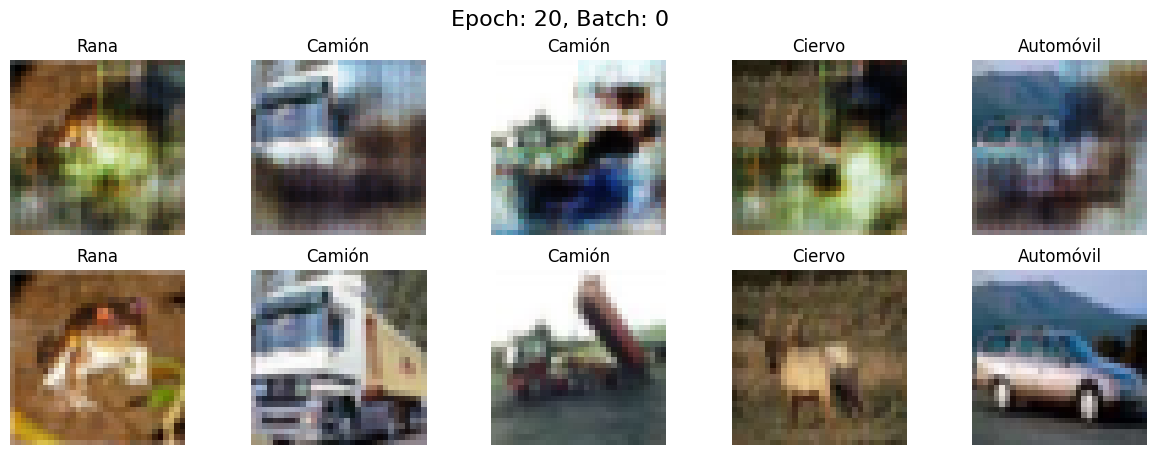

50 [D loss: 0.1216,	 acc.: 100.00%]	[G loss: 0.2108]
100 [D loss: 0.1387,	 acc.: 98.44%]	[G loss: 0.2966]
150 [D loss: 0.2425,	 acc.: 96.88%]	[G loss: 0.2307]
200 [D loss: 0.0961,	 acc.: 100.00%]	[G loss: 0.1976]
250 [D loss: 0.1095,	 acc.: 100.00%]	[G loss: 0.0876]
300 [D loss: 0.1279,	 acc.: 98.44%]	[G loss: 0.4232]
350 [D loss: 0.0993,	 acc.: 100.00%]	[G loss: 0.4461]
400 [D loss: 0.0994,	 acc.: 100.00%]	[G loss: 0.5918]
450 [D loss: 0.1233,	 acc.: 100.00%]	[G loss: 0.2798]
500 [D loss: 0.1353,	 acc.: 98.44%]	[G loss: 0.3086]


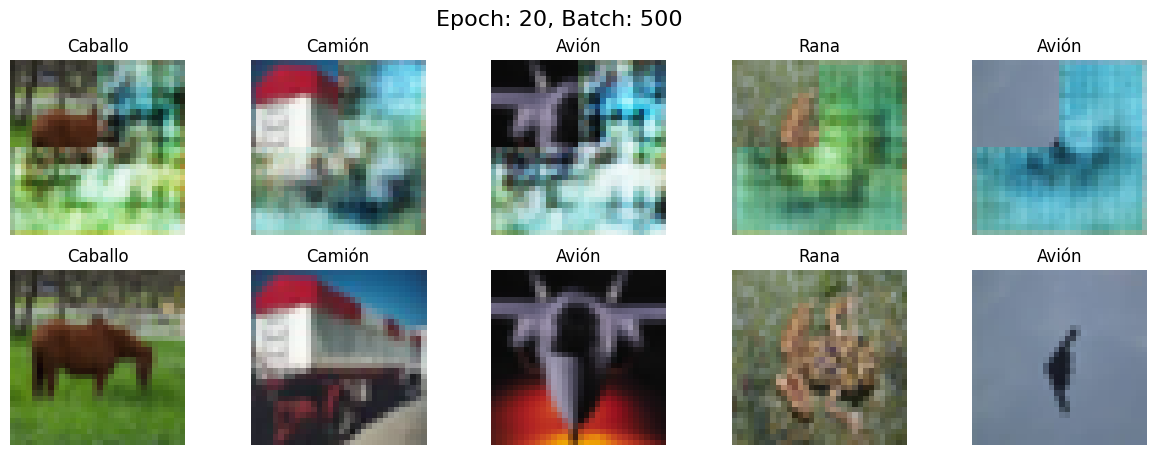

550 [D loss: 0.1085,	 acc.: 100.00%]	[G loss: 0.0669]
600 [D loss: 0.1222,	 acc.: 100.00%]	[G loss: 0.0355]
650 [D loss: 0.1592,	 acc.: 96.88%]	[G loss: 0.0517]
700 [D loss: 0.1444,	 acc.: 96.88%]	[G loss: 0.1547]
750 [D loss: 0.1908,	 acc.: 95.31%]	[G loss: 0.0779]


KeyboardInterrupt: ignored

In [ ]:
train(train_images, train_labels, generatorCF, discriminatorCF, combinedCF, epochs=1000, batch_size=32, sample_interval=10)

## Conclusión
La Generative Adversarial Network (GAN) desarrollada demuestra una notable capacidad para reconocer imágenes y generar representaciones visuales coherentes, considerando el contexto del cuadrado de entrada. Su habilidad para completar imágenes de manera coherente refleja la comprensión de patrones a niveles semi-bajos. Un aspecto destacado es la capacidad de la GAN para realizar autorrellenos precisos, como se ilustra en el ejemplo de la rana. En esta imagen, se aprecia una aproximación notable tanto en la forma como en el color, subrayando así la eficacia de la red en la generación de contenido visual convincente.

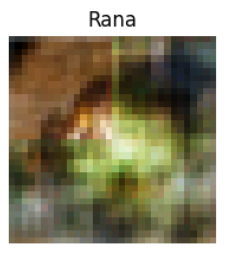